# A Machine Learning journey from customer reviews to business insights
# *Part 2: Data preparation for review text*

*Author: Federica Lionetto*  
*Email: federica.lionetto@gmail.com*  
*Date: 17 November 2020*  
*License: Creative Commons BY-NC-SA*

*Based on the dataset available at:*
- https://www.kaggle.com/efehandanisman/skytrax-airline-reviews

### Further readings

- Hutto, C.J. and Gilbert, E.E., 2014, "VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text", Eighth International Conference on Weblogs and Social Media (ICWSM-14), Ann Arbor, MI, June 2014, https://www.researchgate.net/publication/275828927_VADER_A_Parsimonious_Rule-based_Model_for_Sentiment_Analysis_of_Social_Media_Text
- Sentiment analysis using VADER, https://github.com/cjhutto/vaderSentiment
- "Detecting bad customer reviews with NLP", https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e

## 1 - Import modules and helper functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')

import datetime as dt
import dateutil

import string

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

import importlib

In [2]:
# Debugging capabilities.
import pdb

In [3]:
import sys  
sys.path.insert(0, './helper_functions')

In [4]:
# Related to visualization.
import plot_cmap
import plot_two_hists_comp_sns

# Related to NLP.
import get_wordnet_pos

## 2 - Load the input data

In [5]:
# Type of each field in the input data.
df_dtype = pd.read_csv('../Results/PreprocessedDataLightTypes.csv')
dict_dtype = df_dtype[['index','dtypes']].set_index('index').to_dict()['dtypes']
dict_dtype['recommended'] = 'bool'

In [6]:
# Input data.
df = pd.read_csv('../Results/PreprocessedDataLight.csv', dtype=dict_dtype, keep_default_na=False, na_values=['_'])
df.drop(columns=['Unnamed: 0'],inplace=True)

In [7]:
df.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,review_date_month,review_date_year,date_flown_day,date_flown_month,date_flown_year,review_date_date_flown_distance_days,review_characters,pos_neu_neg_review_score,has_layover,recommended
0,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,5.0,2019.0,1.0,5.0,2019.0,7.0,1094,pos,True,True
1,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,5.0,2019.0,1.0,5.0,2019.0,6.0,425,neg,False,False
2,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,5.0,2019.0,1.0,5.0,2019.0,6.0,1597,neg,True,False
3,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,5.0,2019.0,16.0,4.0,2019.0,20.0,875,pos,False,True
4,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,5.0,2019.0,1.0,5.0,2019.0,5.0,366,neg,True,False


In [8]:
df.shape

(22822, 22)

Get the names of the colums in the dataset.

In [9]:
cols = df.columns.to_list()
print('Columns in the dataset:')
print(cols)

Columns in the dataset:
['airline', 'review_score', 'traveller_type', 'cabin', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'review_text', 'review_date_day', 'review_date_month', 'review_date_year', 'date_flown_day', 'date_flown_month', 'date_flown_year', 'review_date_date_flown_distance_days', 'review_characters', 'pos_neu_neg_review_score', 'has_layover', 'recommended']


Get the total number of customer reviews in the dataset.

In [10]:
n_reviews = df.shape[0]
print('Number of customer reviews in the dataset: {:d}'.format(n_reviews))

Number of customer reviews in the dataset: 22822


## 3 Work with the review text

### 3.1 - Get review text and create a new data frame with NLP information

In [11]:
# Series of all review texts in the dataset.
reviews_list = df['review_text'].copy()

In [12]:
reviews_list.shape

(22822,)

In [13]:
df_nlp = df.copy()

### 3.2 - Sentiment analysis using VADER

Sentiment analysis is the field of NLP that aims at understanding the sentiment of a certain portion of text. One of the best-known packages for sentiment analysis is the open-source package VADER, which is part of NLTK.

The official description of VADER reads
"VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media."   
VADER is built on social media text but it is in general applicable to other domains, including customer reviews.  
VADER is based on a lexicon (vocabulary) that is validated by multiple human judges according to a well-defined and standard procedure. Each word in the lexicon is associated with a sentiment valence, consisting of two properties, polarity and intensity. The polarity describes if the text is positive/negative. The intensity describes how much the text is positive/negative, on a scale from -4 to 4. Words not included in the lexicon are classified as neutral. 

To evaluate the sentiment of a sentence or list of sentences, VADER looks for words in the text that are part of the lexicon, modifies the intensity and polarity of the identified words according to a series of rules, sums up these values and then normalises to the range [-1,1].  
VADER incorporates emojis (for example ":-)"), acronyms (for example "LOL") and slang (for example "nah"). The algorithm differs from a Bag of Words approach as it takes words order and degree modifiers into account, e.g. by increasing/decreasing the intensity of the sentiment.   
For example, the sentences:
- "This flight was great.", 
- "This flight was really great." 
- "This flight was really GREAT."
- "This flight was really GREAT!"
- "This flight was really GREAT! :-)"  
would have an increasing intensity, triggered by degree modifiers.

The output of the sentiment analysis is a series of scores, namely "compound", "pos", "neu" and "neg".  
The compound score is normalized between -1 (extremely negative) and 1 (extremely positive) and is a good metric if we need a single value that summarises the sentiment of a given sentence. The compound score can also be used to classify sentences into positive, neutral and negative by setting an appropriate threshold on the compound score. The official recommended threshold is:
- positive sentiment, compound score >= 0.05
- neutral sentiment, compound score <= 0.05 and >= -0.05
- negative sentiment, compound score <= -0.05  

The positive, neutral and negative scores represent the fraction of the sentence that has a positive, neutral and negative sentiment. The sum of these three scores should sum up to 1. The positive, neutral and negative scores are a good metric if we need multiple values that summarise the sentiment of a given sentence.

In [14]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nanakin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
sid = SentimentIntensityAnalyzer()

In [16]:
# Simple examples.
print(sid.polarity_scores("This flight was great."))
print(sid.polarity_scores("This flight was really great."))
print(sid.polarity_scores("This flight was really GREAT."))
print(sid.polarity_scores("This flight was really GREAT!"))
print(sid.polarity_scores("This flight was really GREAT! :-)"))

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.477, 'pos': 0.523, 'compound': 0.659}
{'neg': 0.0, 'neu': 0.438, 'pos': 0.562, 'compound': 0.7291}
{'neg': 0.0, 'neu': 0.425, 'pos': 0.575, 'compound': 0.752}
{'neg': 0.0, 'neu': 0.333, 'pos': 0.667, 'compound': 0.84}


In [17]:
# Examples.
review = reviews_list[0]
review_tok = tokenize.sent_tokenize(review)
print(review_tok)

[' First time Iâ€™d flown TK.', 'I found them very good in the air, cabin crew, planes, food, all very nice.', 'Not so great on the ground, ground staff, call centre, computer systems.', 'My flight from LHR was delayed so I missed the connection in Istanbul.', 'Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English.', 'I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport.', 'Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats.', 'However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat.', 'Luckily there was a spare exit row seat and the cabin crew sorted me out.', 'Overall, I think their cabin crew and planes are very good, g

In [18]:
# Example on a review level.
print('Review text:')
print(review)

review_polarity_scores = sid.polarity_scores(review)

for key in sorted(review_polarity_scores.keys()):
    print('{}: {}, '.format(key,review_polarity_scores[key]), end='')
print('\n')

Review text:
 First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and planes are very good, ground staff and 

In [19]:
# Example on a sentence level.
print('Review text:')
print(review_tok)

for sentence in review_tok:
    print('Sentence text:')
    print(sentence)
    sentence_polarity_scores = sid.polarity_scores(sentence)

    for key in sorted(sentence_polarity_scores.keys()):
        print('{}: {}, '.format(key,sentence_polarity_scores[key]), end='')
    print('\n')

Review text:
[' First time Iâ€™d flown TK.', 'I found them very good in the air, cabin crew, planes, food, all very nice.', 'Not so great on the ground, ground staff, call centre, computer systems.', 'My flight from LHR was delayed so I missed the connection in Istanbul.', 'Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English.', 'I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport.', 'Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats.', 'However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat.', 'Luckily there was a spare exit row seat and the cabin crew sorted me out.', 'Overall, I think their cabin crew and planes are

In [20]:
# Augment the dataset with the overall polarity score of the review, as obtained using VADER on the review level.
reviews_polarity = []

for i_review, review in enumerate(reviews_list):
    # print('Review text:')
    # print(review)

    review_polarity_scores = sid.polarity_scores(review)
    review_polarity_score_compound = review_polarity_scores['compound']
    
    print('Review #{:d}: '.format(i_review), end='')
    for key in sorted(review_polarity_scores.keys()):
        print('{}: {:.4f}, '.format(key,review_polarity_scores[key]), end='')
    print('')
    
    reviews_polarity.append(review_polarity_score_compound)

# print(reviews_polarity)

Review #0: compound: 0.9365, neg: 0.0610, neu: 0.8240, pos: 0.1140, 
Review #1: compound: 0.2732, neg: 0.0000, neu: 0.9730, pos: 0.0270, 
Review #2: compound: -0.9483, neg: 0.1420, neu: 0.7940, pos: 0.0630, 
Review #3: compound: 0.9764, neg: 0.0260, neu: 0.7960, pos: 0.1780, 
Review #4: compound: -0.7599, neg: 0.1290, neu: 0.8460, pos: 0.0260, 
Review #5: compound: -0.3400, neg: 0.1380, neu: 0.7610, pos: 0.1010, 
Review #6: compound: -0.8185, neg: 0.1880, neu: 0.8120, pos: 0.0000, 
Review #7: compound: 0.8836, neg: 0.0450, neu: 0.7960, pos: 0.1590, 
Review #8: compound: -0.8709, neg: 0.0710, neu: 0.9130, pos: 0.0150, 
Review #9: compound: -0.8122, neg: 0.0680, neu: 0.9070, pos: 0.0250, 
Review #10: compound: -0.8679, neg: 0.0920, neu: 0.8350, pos: 0.0720, 
Review #11: compound: 0.9001, neg: 0.0520, neu: 0.8150, pos: 0.1330, 
Review #12: compound: -0.9035, neg: 0.2110, neu: 0.7510, pos: 0.0380, 
Review #13: compound: 0.8807, neg: 0.0620, neu: 0.6760, pos: 0.2620, 
Review #14: compound: 

Review #152: compound: -0.8591, neg: 0.1860, neu: 0.7760, pos: 0.0380, 
Review #153: compound: -0.7506, neg: 0.1100, neu: 0.8900, pos: 0.0000, 
Review #154: compound: -0.9391, neg: 0.1090, neu: 0.8830, pos: 0.0080, 
Review #155: compound: -0.9636, neg: 0.1460, neu: 0.8070, pos: 0.0470, 
Review #156: compound: -0.9359, neg: 0.1350, neu: 0.8170, pos: 0.0480, 
Review #157: compound: 0.1931, neg: 0.1110, neu: 0.7840, pos: 0.1050, 
Review #158: compound: 0.9601, neg: 0.0190, neu: 0.8570, pos: 0.1240, 
Review #159: compound: -0.9935, neg: 0.1620, neu: 0.8040, pos: 0.0330, 
Review #160: compound: -0.9682, neg: 0.2050, neu: 0.7620, pos: 0.0330, 
Review #161: compound: -0.4786, neg: 0.0570, neu: 0.9150, pos: 0.0280, 
Review #162: compound: -0.9664, neg: 0.1500, neu: 0.8010, pos: 0.0480, 
Review #163: compound: 0.9715, neg: 0.0710, neu: 0.7620, pos: 0.1670, 
Review #164: compound: -0.5729, neg: 0.1050, neu: 0.8400, pos: 0.0550, 
Review #165: compound: -0.9878, neg: 0.1590, neu: 0.7770, pos: 0.06

Review #276: compound: 0.9948, neg: 0.0340, neu: 0.7330, pos: 0.2330, 
Review #277: compound: 0.8750, neg: 0.0550, neu: 0.8310, pos: 0.1140, 
Review #278: compound: -0.7959, neg: 0.0840, neu: 0.8880, pos: 0.0280, 
Review #279: compound: 0.9756, neg: 0.0000, neu: 0.7480, pos: 0.2520, 
Review #280: compound: 0.9342, neg: 0.0430, neu: 0.7270, pos: 0.2300, 
Review #281: compound: 0.8784, neg: 0.0870, neu: 0.6480, pos: 0.2650, 
Review #282: compound: -0.4987, neg: 0.1450, neu: 0.7120, pos: 0.1430, 
Review #283: compound: 0.9844, neg: 0.0150, neu: 0.7920, pos: 0.1930, 
Review #284: compound: -0.2568, neg: 0.0720, neu: 0.8500, pos: 0.0780, 
Review #285: compound: -0.2382, neg: 0.1180, neu: 0.7960, pos: 0.0860, 
Review #286: compound: 0.4782, neg: 0.1150, neu: 0.7600, pos: 0.1250, 
Review #287: compound: -0.8345, neg: 0.0860, neu: 0.9140, pos: 0.0000, 
Review #288: compound: -0.5770, neg: 0.0980, neu: 0.8370, pos: 0.0660, 
Review #289: compound: -0.9063, neg: 0.0880, neu: 0.8870, pos: 0.0250, 

Review #443: compound: 0.8076, neg: 0.0980, neu: 0.7930, pos: 0.1090, 
Review #444: compound: -0.9777, neg: 0.0910, neu: 0.8700, pos: 0.0400, 
Review #445: compound: -0.5337, neg: 0.1450, neu: 0.7390, pos: 0.1160, 
Review #446: compound: 0.9621, neg: 0.0330, neu: 0.7980, pos: 0.1690, 
Review #447: compound: 0.8323, neg: 0.0750, neu: 0.7390, pos: 0.1860, 
Review #448: compound: 0.9715, neg: 0.0630, neu: 0.7960, pos: 0.1410, 
Review #449: compound: 0.8610, neg: 0.0000, neu: 0.5940, pos: 0.4060, 
Review #450: compound: -0.5853, neg: 0.1010, neu: 0.8400, pos: 0.0590, 
Review #451: compound: 0.9623, neg: 0.0000, neu: 0.8860, pos: 0.1140, 
Review #452: compound: -0.6802, neg: 0.1180, neu: 0.8820, pos: 0.0000, 
Review #453: compound: 0.9842, neg: 0.0000, neu: 0.6360, pos: 0.3640, 
Review #454: compound: 0.9779, neg: 0.0200, neu: 0.7870, pos: 0.1930, 
Review #455: compound: 0.9040, neg: 0.0400, neu: 0.8080, pos: 0.1530, 
Review #456: compound: -0.8225, neg: 0.0450, neu: 0.9450, pos: 0.0100, 
R

Review #581: compound: 0.6509, neg: 0.0740, neu: 0.8320, pos: 0.0940, 
Review #582: compound: 0.9961, neg: 0.0650, neu: 0.7090, pos: 0.2260, 
Review #583: compound: -0.6314, neg: 0.1350, neu: 0.7600, pos: 0.1050, 
Review #584: compound: 0.8555, neg: 0.0960, neu: 0.7230, pos: 0.1810, 
Review #585: compound: -0.1548, neg: 0.0620, neu: 0.8730, pos: 0.0650, 
Review #586: compound: 0.9118, neg: 0.0000, neu: 0.7510, pos: 0.2490, 
Review #587: compound: 0.5413, neg: 0.0250, neu: 0.9150, pos: 0.0600, 
Review #588: compound: 0.9081, neg: 0.0000, neu: 0.7890, pos: 0.2110, 
Review #589: compound: 0.9376, neg: 0.0530, neu: 0.6950, pos: 0.2520, 
Review #590: compound: 0.5840, neg: 0.1110, neu: 0.7630, pos: 0.1260, 
Review #591: compound: 0.9795, neg: 0.0120, neu: 0.7790, pos: 0.2090, 
Review #592: compound: 0.8971, neg: 0.0600, neu: 0.7890, pos: 0.1510, 
Review #593: compound: 0.9777, neg: 0.0000, neu: 0.7840, pos: 0.2160, 
Review #594: compound: 0.2329, neg: 0.0820, neu: 0.8190, pos: 0.0980, 
Revi

Review #699: compound: 0.9848, neg: 0.0300, neu: 0.7650, pos: 0.2050, 
Review #700: compound: 0.9902, neg: 0.0340, neu: 0.7770, pos: 0.1880, 
Review #701: compound: 0.9425, neg: 0.0380, neu: 0.7660, pos: 0.1960, 
Review #702: compound: 0.9606, neg: 0.0780, neu: 0.7030, pos: 0.2200, 
Review #703: compound: -0.2547, neg: 0.0950, neu: 0.8200, pos: 0.0860, 
Review #704: compound: -0.9387, neg: 0.1320, neu: 0.8680, pos: 0.0000, 
Review #705: compound: -0.7976, neg: 0.0780, neu: 0.8870, pos: 0.0350, 
Review #706: compound: -0.1929, neg: 0.1980, neu: 0.6020, pos: 0.2000, 
Review #707: compound: -0.5859, neg: 0.0790, neu: 0.8490, pos: 0.0710, 
Review #708: compound: 0.9919, neg: 0.0970, neu: 0.7430, pos: 0.1610, 
Review #709: compound: 0.9128, neg: 0.0000, neu: 0.6450, pos: 0.3550, 
Review #710: compound: 0.1424, neg: 0.0950, neu: 0.7990, pos: 0.1060, 
Review #711: compound: 0.8625, neg: 0.0940, neu: 0.7310, pos: 0.1760, 
Review #712: compound: 0.9896, neg: 0.0500, neu: 0.6110, pos: 0.3390, 
R

Review #813: compound: 0.4767, neg: 0.0300, neu: 0.8840, pos: 0.0860, 
Review #814: compound: -0.8076, neg: 0.1250, neu: 0.8480, pos: 0.0270, 
Review #815: compound: 0.8768, neg: 0.0640, neu: 0.8600, pos: 0.0760, 
Review #816: compound: -0.9780, neg: 0.2200, neu: 0.7800, pos: 0.0000, 
Review #817: compound: 0.3919, neg: 0.0160, neu: 0.9430, pos: 0.0420, 
Review #818: compound: 0.9793, neg: 0.0390, neu: 0.8210, pos: 0.1400, 
Review #819: compound: -0.6968, neg: 0.1260, neu: 0.8740, pos: 0.0000, 
Review #820: compound: 0.9061, neg: 0.0000, neu: 0.6520, pos: 0.3480, 
Review #821: compound: -0.0900, neg: 0.0740, neu: 0.8680, pos: 0.0580, 
Review #822: compound: 0.3919, neg: 0.0000, neu: 0.9220, pos: 0.0780, 
Review #823: compound: -0.3604, neg: 0.0770, neu: 0.8620, pos: 0.0610, 
Review #824: compound: -0.7960, neg: 0.0450, neu: 0.9480, pos: 0.0060, 
Review #825: compound: -0.3919, neg: 0.1220, neu: 0.7900, pos: 0.0880, 
Review #826: compound: 0.9535, neg: 0.0000, neu: 0.8480, pos: 0.1520, 

Review #951: compound: -0.5989, neg: 0.1030, neu: 0.8390, pos: 0.0580, 
Review #952: compound: 0.9156, neg: 0.0520, neu: 0.8520, pos: 0.0970, 
Review #953: compound: 0.6825, neg: 0.0370, neu: 0.8920, pos: 0.0710, 
Review #954: compound: 0.7050, neg: 0.0470, neu: 0.7590, pos: 0.1940, 
Review #955: compound: 0.7932, neg: 0.0730, neu: 0.8160, pos: 0.1100, 
Review #956: compound: 0.9382, neg: 0.0000, neu: 0.6440, pos: 0.3560, 
Review #957: compound: 0.9385, neg: 0.0610, neu: 0.8180, pos: 0.1220, 
Review #958: compound: 0.7469, neg: 0.0510, neu: 0.8690, pos: 0.0800, 
Review #959: compound: 0.9565, neg: 0.0480, neu: 0.6810, pos: 0.2710, 
Review #960: compound: 0.9973, neg: 0.0420, neu: 0.8180, pos: 0.1400, 
Review #961: compound: 0.9337, neg: 0.0000, neu: 0.5300, pos: 0.4700, 
Review #962: compound: 0.9770, neg: 0.0000, neu: 0.4720, pos: 0.5280, 
Review #963: compound: 0.9112, neg: 0.0190, neu: 0.8040, pos: 0.1770, 
Review #964: compound: 0.9911, neg: 0.0620, neu: 0.7170, pos: 0.2210, 
Revie

Review #1099: compound: 0.9896, neg: 0.0820, neu: 0.6880, pos: 0.2310, 
Review #1100: compound: 0.9400, neg: 0.0000, neu: 0.7420, pos: 0.2580, 
Review #1101: compound: 0.9907, neg: 0.0150, neu: 0.7150, pos: 0.2700, 
Review #1102: compound: 0.7985, neg: 0.0410, neu: 0.7800, pos: 0.1790, 
Review #1103: compound: 0.8779, neg: 0.0680, neu: 0.7470, pos: 0.1850, 
Review #1104: compound: 0.9461, neg: 0.0260, neu: 0.8050, pos: 0.1690, 
Review #1105: compound: -0.5635, neg: 0.1230, neu: 0.7740, pos: 0.1040, 
Review #1106: compound: 0.9760, neg: 0.0000, neu: 0.7670, pos: 0.2330, 
Review #1107: compound: 0.9678, neg: 0.0210, neu: 0.7480, pos: 0.2310, 
Review #1108: compound: 0.9963, neg: 0.0400, neu: 0.6250, pos: 0.3350, 
Review #1109: compound: -0.6372, neg: 0.0500, neu: 0.9220, pos: 0.0280, 
Review #1110: compound: 0.9577, neg: 0.0000, neu: 0.7160, pos: 0.2840, 
Review #1111: compound: 0.9660, neg: 0.0000, neu: 0.6970, pos: 0.3030, 
Review #1112: compound: 0.9854, neg: 0.0110, neu: 0.7350, pos:

Review #1237: compound: 0.9111, neg: 0.0240, neu: 0.8500, pos: 0.1260, 
Review #1238: compound: 0.8733, neg: 0.0000, neu: 0.8450, pos: 0.1550, 
Review #1239: compound: 0.9432, neg: 0.0880, neu: 0.5740, pos: 0.3390, 
Review #1240: compound: 0.9814, neg: 0.0470, neu: 0.7020, pos: 0.2510, 
Review #1241: compound: 0.9607, neg: 0.0000, neu: 0.6380, pos: 0.3620, 
Review #1242: compound: 0.0543, neg: 0.1120, neu: 0.7730, pos: 0.1150, 
Review #1243: compound: 0.9801, neg: 0.0830, neu: 0.6970, pos: 0.2200, 
Review #1244: compound: 0.9841, neg: 0.0000, neu: 0.6280, pos: 0.3720, 
Review #1245: compound: 0.9129, neg: 0.0520, neu: 0.7820, pos: 0.1660, 
Review #1246: compound: 0.9684, neg: 0.0310, neu: 0.8430, pos: 0.1260, 
Review #1247: compound: 0.8106, neg: 0.0370, neu: 0.8440, pos: 0.1190, 
Review #1248: compound: 0.8515, neg: 0.1050, neu: 0.7400, pos: 0.1550, 
Review #1249: compound: 0.9505, neg: 0.0000, neu: 0.7690, pos: 0.2310, 
Review #1250: compound: 0.6729, neg: 0.1230, neu: 0.6740, pos: 0

Review #1356: compound: 0.9875, neg: 0.0000, neu: 0.7500, pos: 0.2500, 
Review #1357: compound: 0.9615, neg: 0.0330, neu: 0.8500, pos: 0.1170, 
Review #1358: compound: 0.9011, neg: 0.0000, neu: 0.7900, pos: 0.2100, 
Review #1359: compound: 0.9694, neg: 0.0000, neu: 0.5680, pos: 0.4320, 
Review #1360: compound: 0.5978, neg: 0.0940, neu: 0.7860, pos: 0.1200, 
Review #1361: compound: -0.3143, neg: 0.1150, neu: 0.7940, pos: 0.0910, 
Review #1362: compound: 0.9673, neg: 0.0210, neu: 0.7300, pos: 0.2490, 
Review #1363: compound: 0.9816, neg: 0.0450, neu: 0.8210, pos: 0.1340, 
Review #1364: compound: -0.7302, neg: 0.0980, neu: 0.8500, pos: 0.0520, 
Review #1365: compound: 0.9733, neg: 0.0000, neu: 0.8430, pos: 0.1570, 
Review #1366: compound: 0.8873, neg: 0.0240, neu: 0.8050, pos: 0.1710, 
Review #1367: compound: 0.9874, neg: 0.0530, neu: 0.7760, pos: 0.1700, 
Review #1368: compound: 0.9618, neg: 0.0000, neu: 0.7880, pos: 0.2120, 
Review #1369: compound: 0.9622, neg: 0.0300, neu: 0.8610, pos:

Review #1492: compound: 0.9661, neg: 0.0000, neu: 0.7510, pos: 0.2490, 
Review #1493: compound: -0.9156, neg: 0.1220, neu: 0.8260, pos: 0.0520, 
Review #1494: compound: 0.9826, neg: 0.0360, neu: 0.7420, pos: 0.2220, 
Review #1495: compound: 0.9387, neg: 0.0320, neu: 0.7950, pos: 0.1730, 
Review #1496: compound: 0.9081, neg: 0.0230, neu: 0.8820, pos: 0.0950, 
Review #1497: compound: 0.9923, neg: 0.0330, neu: 0.7150, pos: 0.2520, 
Review #1498: compound: -0.9439, neg: 0.0660, neu: 0.9140, pos: 0.0200, 
Review #1499: compound: -0.4464, neg: 0.0640, neu: 0.8720, pos: 0.0640, 
Review #1500: compound: 0.9919, neg: 0.0050, neu: 0.7990, pos: 0.1960, 
Review #1501: compound: 0.6770, neg: 0.1040, neu: 0.7250, pos: 0.1710, 
Review #1502: compound: 0.9601, neg: 0.0000, neu: 0.6750, pos: 0.3250, 
Review #1503: compound: 0.9203, neg: 0.0500, neu: 0.6780, pos: 0.2720, 
Review #1504: compound: 0.9434, neg: 0.0480, neu: 0.8320, pos: 0.1200, 
Review #1505: compound: -0.6792, neg: 0.1280, neu: 0.7900, po

Review #1621: compound: 0.9502, neg: 0.0440, neu: 0.8460, pos: 0.1100, 
Review #1622: compound: -0.8834, neg: 0.1030, neu: 0.8580, pos: 0.0390, 
Review #1623: compound: 0.9928, neg: 0.0000, neu: 0.7510, pos: 0.2490, 
Review #1624: compound: 0.9860, neg: 0.0560, neu: 0.7900, pos: 0.1540, 
Review #1625: compound: 0.9802, neg: 0.0250, neu: 0.7520, pos: 0.2230, 
Review #1626: compound: 0.4199, neg: 0.0000, neu: 0.6820, pos: 0.3180, 
Review #1627: compound: 0.8589, neg: 0.0000, neu: 0.9120, pos: 0.0880, 
Review #1628: compound: 0.9095, neg: 0.0000, neu: 0.6480, pos: 0.3520, 
Review #1629: compound: 0.8151, neg: 0.0000, neu: 0.8620, pos: 0.1380, 
Review #1630: compound: 0.9459, neg: 0.0000, neu: 0.7340, pos: 0.2660, 
Review #1631: compound: 0.9272, neg: 0.0500, neu: 0.6670, pos: 0.2830, 
Review #1632: compound: -0.2023, neg: 0.0150, neu: 0.9850, pos: 0.0000, 
Review #1633: compound: 0.9318, neg: 0.0000, neu: 0.7150, pos: 0.2850, 
Review #1634: compound: 0.8897, neg: 0.0200, neu: 0.8200, pos:

Review #1738: compound: 0.8271, neg: 0.1030, neu: 0.7450, pos: 0.1520, 
Review #1739: compound: 0.9428, neg: 0.0000, neu: 0.6930, pos: 0.3070, 
Review #1740: compound: 0.8932, neg: 0.0250, neu: 0.8180, pos: 0.1570, 
Review #1741: compound: 0.9607, neg: 0.0700, neu: 0.8050, pos: 0.1250, 
Review #1742: compound: 0.9619, neg: 0.1180, neu: 0.6890, pos: 0.1920, 
Review #1743: compound: -0.4956, neg: 0.0670, neu: 0.9160, pos: 0.0170, 
Review #1744: compound: 0.9824, neg: 0.0320, neu: 0.7970, pos: 0.1710, 
Review #1745: compound: -0.8859, neg: 0.0850, neu: 0.8620, pos: 0.0530, 
Review #1746: compound: -0.8860, neg: 0.3000, neu: 0.6440, pos: 0.0560, 
Review #1747: compound: 0.9933, neg: 0.0420, neu: 0.7280, pos: 0.2300, 
Review #1748: compound: 0.9806, neg: 0.0110, neu: 0.8460, pos: 0.1430, 
Review #1749: compound: 0.9286, neg: 0.0000, neu: 0.6460, pos: 0.3540, 
Review #1750: compound: 0.9472, neg: 0.0540, neu: 0.8050, pos: 0.1410, 
Review #1751: compound: 0.7005, neg: 0.0800, neu: 0.8090, pos

Review #1860: compound: 0.9252, neg: 0.0400, neu: 0.8070, pos: 0.1530, 
Review #1861: compound: 0.8883, neg: 0.0270, neu: 0.8690, pos: 0.1040, 
Review #1862: compound: -0.9534, neg: 0.1220, neu: 0.8300, pos: 0.0490, 
Review #1863: compound: 0.5994, neg: 0.0860, neu: 0.7910, pos: 0.1240, 
Review #1864: compound: -0.6471, neg: 0.0730, neu: 0.8770, pos: 0.0500, 
Review #1865: compound: 0.7351, neg: 0.0000, neu: 0.7800, pos: 0.2200, 
Review #1866: compound: -0.9300, neg: 0.1190, neu: 0.8810, pos: 0.0000, 
Review #1867: compound: -0.0462, neg: 0.0770, neu: 0.8380, pos: 0.0850, 
Review #1868: compound: 0.0906, neg: 0.1030, neu: 0.7950, pos: 0.1020, 
Review #1869: compound: -0.4380, neg: 0.1490, neu: 0.7400, pos: 0.1120, 
Review #1870: compound: -0.7089, neg: 0.1690, neu: 0.8310, pos: 0.0000, 
Review #1871: compound: -0.8931, neg: 0.0870, neu: 0.8720, pos: 0.0420, 
Review #1872: compound: -0.7636, neg: 0.1980, neu: 0.6560, pos: 0.1460, 
Review #1873: compound: 0.0387, neg: 0.1200, neu: 0.7580

Review #1995: compound: 0.6861, neg: 0.0810, neu: 0.8370, pos: 0.0830, 
Review #1996: compound: -0.4019, neg: 0.0530, neu: 0.9130, pos: 0.0340, 
Review #1997: compound: 0.8519, neg: 0.0350, neu: 0.7510, pos: 0.2140, 
Review #1998: compound: 0.9073, neg: 0.0350, neu: 0.8730, pos: 0.0920, 
Review #1999: compound: 0.9500, neg: 0.0290, neu: 0.7270, pos: 0.2430, 
Review #2000: compound: -0.8863, neg: 0.0800, neu: 0.8970, pos: 0.0220, 
Review #2001: compound: 0.0809, neg: 0.0590, neu: 0.8790, pos: 0.0620, 
Review #2002: compound: 0.9642, neg: 0.0000, neu: 0.6310, pos: 0.3690, 
Review #2003: compound: 0.9892, neg: 0.0340, neu: 0.6410, pos: 0.3250, 
Review #2004: compound: 0.9804, neg: 0.0360, neu: 0.8250, pos: 0.1390, 
Review #2005: compound: 0.9531, neg: 0.0000, neu: 0.7740, pos: 0.2260, 
Review #2006: compound: 0.9612, neg: 0.0520, neu: 0.8360, pos: 0.1130, 
Review #2007: compound: 0.9432, neg: 0.0000, neu: 0.7120, pos: 0.2880, 
Review #2008: compound: 0.5104, neg: 0.0800, neu: 0.8230, pos:

Review #2123: compound: 0.9738, neg: 0.0390, neu: 0.7300, pos: 0.2310, 
Review #2124: compound: 0.9851, neg: 0.0000, neu: 0.6690, pos: 0.3310, 
Review #2125: compound: 0.9504, neg: 0.0000, neu: 0.6690, pos: 0.3310, 
Review #2126: compound: 0.9545, neg: 0.0330, neu: 0.7360, pos: 0.2310, 
Review #2127: compound: -0.9600, neg: 0.1670, neu: 0.7480, pos: 0.0850, 
Review #2128: compound: 0.6158, neg: 0.0650, neu: 0.8240, pos: 0.1100, 
Review #2129: compound: -0.1308, neg: 0.0610, neu: 0.8830, pos: 0.0560, 
Review #2130: compound: -0.9533, neg: 0.1250, neu: 0.8410, pos: 0.0340, 
Review #2131: compound: 0.9504, neg: 0.0560, neu: 0.7100, pos: 0.2340, 
Review #2132: compound: 0.9476, neg: 0.0000, neu: 0.7560, pos: 0.2440, 
Review #2133: compound: -0.3797, neg: 0.1120, neu: 0.7820, pos: 0.1060, 
Review #2134: compound: 0.9895, neg: 0.0700, neu: 0.6980, pos: 0.2320, 
Review #2135: compound: 0.9837, neg: 0.1030, neu: 0.6250, pos: 0.2720, 
Review #2136: compound: -0.3976, neg: 0.1470, neu: 0.7160, p

Review #2237: compound: 0.9425, neg: 0.0000, neu: 0.6060, pos: 0.3940, 
Review #2238: compound: -0.8979, neg: 0.1100, neu: 0.8900, pos: 0.0000, 
Review #2239: compound: 0.3182, neg: 0.0440, neu: 0.8870, pos: 0.0690, 
Review #2240: compound: 0.8825, neg: 0.0590, neu: 0.7240, pos: 0.2170, 
Review #2241: compound: 0.9739, neg: 0.0480, neu: 0.8470, pos: 0.1050, 
Review #2242: compound: -0.9453, neg: 0.1430, neu: 0.7640, pos: 0.0920, 
Review #2243: compound: 0.9489, neg: 0.0350, neu: 0.7230, pos: 0.2410, 
Review #2244: compound: 0.9794, neg: 0.0000, neu: 0.6840, pos: 0.3160, 
Review #2245: compound: -0.9111, neg: 0.1430, neu: 0.7870, pos: 0.0710, 
Review #2246: compound: -0.8699, neg: 0.1350, neu: 0.7920, pos: 0.0740, 
Review #2247: compound: 0.8402, neg: 0.0190, neu: 0.8910, pos: 0.0900, 
Review #2248: compound: 0.7329, neg: 0.0690, neu: 0.8580, pos: 0.0740, 
Review #2249: compound: -0.9593, neg: 0.1070, neu: 0.8600, pos: 0.0330, 
Review #2250: compound: 0.9287, neg: 0.0160, neu: 0.8550, p

Review #2394: compound: 0.9814, neg: 0.0530, neu: 0.8460, pos: 0.1020, 
Review #2395: compound: 0.0267, neg: 0.0530, neu: 0.8980, pos: 0.0490, 
Review #2396: compound: 0.9318, neg: 0.0510, neu: 0.8440, pos: 0.1040, 
Review #2397: compound: -0.8921, neg: 0.0890, neu: 0.9030, pos: 0.0080, 
Review #2398: compound: 0.9913, neg: 0.0000, neu: 0.7170, pos: 0.2830, 
Review #2399: compound: -0.8334, neg: 0.0850, neu: 0.9050, pos: 0.0100, 
Review #2400: compound: -0.9274, neg: 0.1130, neu: 0.8630, pos: 0.0240, 
Review #2401: compound: -0.5758, neg: 0.1070, neu: 0.8290, pos: 0.0630, 
Review #2402: compound: -0.9018, neg: 0.2370, neu: 0.7260, pos: 0.0360, 
Review #2403: compound: 0.9795, neg: 0.0370, neu: 0.8680, pos: 0.0950, 
Review #2404: compound: -0.7336, neg: 0.1100, neu: 0.8090, pos: 0.0800, 
Review #2405: compound: -0.8807, neg: 0.1890, neu: 0.6930, pos: 0.1190, 
Review #2406: compound: 0.9924, neg: 0.0100, neu: 0.7580, pos: 0.2310, 
Review #2407: compound: 0.9973, neg: 0.0340, neu: 0.6970,

Review #2558: compound: -0.7836, neg: 0.0720, neu: 0.8960, pos: 0.0320, 
Review #2559: compound: 0.7072, neg: 0.0230, neu: 0.8840, pos: 0.0920, 
Review #2560: compound: -0.9218, neg: 0.1350, neu: 0.8330, pos: 0.0310, 
Review #2561: compound: 0.8200, neg: 0.0630, neu: 0.8220, pos: 0.1160, 
Review #2562: compound: -0.7451, neg: 0.0700, neu: 0.9070, pos: 0.0230, 
Review #2563: compound: 0.7650, neg: 0.0000, neu: 0.9020, pos: 0.0980, 
Review #2564: compound: 0.7821, neg: 0.1080, neu: 0.6810, pos: 0.2110, 
Review #2565: compound: -0.4003, neg: 0.0250, neu: 0.9680, pos: 0.0070, 
Review #2566: compound: -0.4933, neg: 0.0720, neu: 0.9280, pos: 0.0000, 
Review #2567: compound: 0.9235, neg: 0.0520, neu: 0.6540, pos: 0.2940, 
Review #2568: compound: -0.5553, neg: 0.1050, neu: 0.8210, pos: 0.0740, 
Review #2569: compound: -0.9177, neg: 0.2080, neu: 0.7220, pos: 0.0690, 
Review #2570: compound: 0.9382, neg: 0.0410, neu: 0.7520, pos: 0.2070, 
Review #2571: compound: 0.2396, neg: 0.0790, neu: 0.8290,

Review #2672: compound: -0.7753, neg: 0.1150, neu: 0.8130, pos: 0.0720, 
Review #2673: compound: 0.9623, neg: 0.0000, neu: 0.5350, pos: 0.4650, 
Review #2674: compound: 0.9721, neg: 0.0000, neu: 0.7080, pos: 0.2920, 
Review #2675: compound: -0.1243, neg: 0.0630, neu: 0.8810, pos: 0.0550, 
Review #2676: compound: 0.6814, neg: 0.0980, neu: 0.7850, pos: 0.1180, 
Review #2677: compound: -0.2232, neg: 0.0690, neu: 0.8800, pos: 0.0520, 
Review #2678: compound: 0.9022, neg: 0.0360, neu: 0.8530, pos: 0.1120, 
Review #2679: compound: 0.9576, neg: 0.0710, neu: 0.7380, pos: 0.1910, 
Review #2680: compound: 0.4588, neg: 0.0000, neu: 0.9130, pos: 0.0870, 
Review #2681: compound: -0.9723, neg: 0.1260, neu: 0.8400, pos: 0.0340, 
Review #2682: compound: 0.6887, neg: 0.1240, neu: 0.6330, pos: 0.2430, 
Review #2683: compound: 0.9776, neg: 0.0000, neu: 0.6790, pos: 0.3210, 
Review #2684: compound: -0.7647, neg: 0.1040, neu: 0.8340, pos: 0.0610, 
Review #2685: compound: -0.9342, neg: 0.1480, neu: 0.7730, 

Review #2818: compound: 0.9362, neg: 0.0320, neu: 0.8640, pos: 0.1040, 
Review #2819: compound: -0.2810, neg: 0.1120, neu: 0.7960, pos: 0.0920, 
Review #2820: compound: 0.9755, neg: 0.0580, neu: 0.8440, pos: 0.0980, 
Review #2821: compound: 0.9805, neg: 0.0000, neu: 0.6760, pos: 0.3240, 
Review #2822: compound: 0.9936, neg: 0.0460, neu: 0.7710, pos: 0.1820, 
Review #2823: compound: 0.7186, neg: 0.0870, neu: 0.7840, pos: 0.1290, 
Review #2824: compound: -0.5355, neg: 0.1070, neu: 0.8300, pos: 0.0630, 
Review #2825: compound: 0.9522, neg: 0.0000, neu: 0.7130, pos: 0.2870, 
Review #2826: compound: -0.8020, neg: 0.0900, neu: 0.9100, pos: 0.0000, 
Review #2827: compound: -0.9844, neg: 0.1040, neu: 0.8590, pos: 0.0370, 
Review #2828: compound: -0.5423, neg: 0.1900, neu: 0.7190, pos: 0.0920, 
Review #2829: compound: -0.9461, neg: 0.1470, neu: 0.8400, pos: 0.0130, 
Review #2830: compound: 0.7922, neg: 0.0610, neu: 0.8400, pos: 0.0990, 
Review #2831: compound: -0.8224, neg: 0.0800, neu: 0.8680,

Review #2953: compound: 0.9931, neg: 0.0770, neu: 0.6410, pos: 0.2830, 
Review #2954: compound: 0.4588, neg: 0.0000, neu: 0.8670, pos: 0.1330, 
Review #2955: compound: -0.3167, neg: 0.1820, neu: 0.6700, pos: 0.1480, 
Review #2956: compound: -0.4758, neg: 0.1400, neu: 0.7520, pos: 0.1080, 
Review #2957: compound: -0.0516, neg: 0.0560, neu: 0.8810, pos: 0.0630, 
Review #2958: compound: 0.9430, neg: 0.0000, neu: 0.8790, pos: 0.1210, 
Review #2959: compound: -0.8126, neg: 0.1740, neu: 0.8260, pos: 0.0000, 
Review #2960: compound: -0.9796, neg: 0.2310, neu: 0.7690, pos: 0.0000, 
Review #2961: compound: -0.6511, neg: 0.0760, neu: 0.8620, pos: 0.0620, 
Review #2962: compound: 0.9622, neg: 0.0000, neu: 0.7470, pos: 0.2530, 
Review #2963: compound: 0.9859, neg: 0.0000, neu: 0.7740, pos: 0.2260, 
Review #2964: compound: 0.9847, neg: 0.0250, neu: 0.8300, pos: 0.1450, 
Review #2965: compound: 0.9769, neg: 0.0340, neu: 0.7880, pos: 0.1780, 
Review #2966: compound: 0.9157, neg: 0.0480, neu: 0.8080, 

Review #3069: compound: 0.9653, neg: 0.0950, neu: 0.7280, pos: 0.1760, 
Review #3070: compound: -0.0187, neg: 0.0440, neu: 0.9060, pos: 0.0500, 
Review #3071: compound: 0.9217, neg: 0.0000, neu: 0.8090, pos: 0.1910, 
Review #3072: compound: 0.5933, neg: 0.0560, neu: 0.8750, pos: 0.0690, 
Review #3073: compound: 0.3491, neg: 0.0700, neu: 0.8390, pos: 0.0910, 
Review #3074: compound: 0.8941, neg: 0.1210, neu: 0.6400, pos: 0.2390, 
Review #3075: compound: 0.9596, neg: 0.0000, neu: 0.7940, pos: 0.2060, 
Review #3076: compound: 0.9711, neg: 0.0560, neu: 0.7670, pos: 0.1770, 
Review #3077: compound: 0.9702, neg: 0.0000, neu: 0.7150, pos: 0.2850, 
Review #3078: compound: 0.6628, neg: 0.0360, neu: 0.9190, pos: 0.0450, 
Review #3079: compound: 0.9917, neg: 0.0000, neu: 0.8300, pos: 0.1700, 
Review #3080: compound: 0.7475, neg: 0.0420, neu: 0.8600, pos: 0.0980, 
Review #3081: compound: 0.6479, neg: 0.0320, neu: 0.8980, pos: 0.0690, 
Review #3082: compound: 0.8609, neg: 0.0750, neu: 0.7450, pos: 

Review #3203: compound: 0.9530, neg: 0.0000, neu: 0.7120, pos: 0.2880, 
Review #3204: compound: 0.3263, neg: 0.0740, neu: 0.8450, pos: 0.0810, 
Review #3205: compound: 0.9270, neg: 0.0480, neu: 0.8070, pos: 0.1450, 
Review #3206: compound: 0.9796, neg: 0.0370, neu: 0.8110, pos: 0.1520, 
Review #3207: compound: 0.9088, neg: 0.0310, neu: 0.8110, pos: 0.1570, 
Review #3208: compound: -0.8777, neg: 0.0930, neu: 0.8700, pos: 0.0370, 
Review #3209: compound: 0.9843, neg: 0.0000, neu: 0.6900, pos: 0.3100, 
Review #3210: compound: 0.9856, neg: 0.0320, neu: 0.7790, pos: 0.1880, 
Review #3211: compound: 0.9930, neg: 0.0090, neu: 0.7360, pos: 0.2550, 
Review #3212: compound: 0.9252, neg: 0.0360, neu: 0.7430, pos: 0.2210, 
Review #3213: compound: -0.7920, neg: 0.0830, neu: 0.8590, pos: 0.0580, 
Review #3214: compound: 0.8805, neg: 0.0200, neu: 0.8170, pos: 0.1630, 
Review #3215: compound: 0.9307, neg: 0.0310, neu: 0.7540, pos: 0.2150, 
Review #3216: compound: 0.9470, neg: 0.0000, neu: 0.8400, pos:

Review #3352: compound: -0.5106, neg: 0.0680, neu: 0.8760, pos: 0.0560, 
Review #3353: compound: 0.9267, neg: 0.0980, neu: 0.7350, pos: 0.1670, 
Review #3354: compound: -0.8769, neg: 0.1260, neu: 0.8020, pos: 0.0720, 
Review #3355: compound: 0.8958, neg: 0.0430, neu: 0.7480, pos: 0.2090, 
Review #3356: compound: 0.8201, neg: 0.0570, neu: 0.8400, pos: 0.1020, 
Review #3357: compound: 0.9765, neg: 0.0000, neu: 0.6800, pos: 0.3200, 
Review #3358: compound: 0.9768, neg: 0.0790, neu: 0.7930, pos: 0.1290, 
Review #3359: compound: -0.4019, neg: 0.0440, neu: 0.9430, pos: 0.0130, 
Review #3360: compound: 0.7506, neg: 0.0000, neu: 0.9220, pos: 0.0780, 
Review #3361: compound: -0.5773, neg: 0.1630, neu: 0.7360, pos: 0.1010, 
Review #3362: compound: 0.8410, neg: 0.0400, neu: 0.7660, pos: 0.1940, 
Review #3363: compound: -0.8481, neg: 0.0860, neu: 0.8950, pos: 0.0190, 
Review #3364: compound: 0.9837, neg: 0.0270, neu: 0.7870, pos: 0.1860, 
Review #3365: compound: -0.9678, neg: 0.1460, neu: 0.7670, 

Review #3479: compound: -0.9600, neg: 0.0970, neu: 0.9030, pos: 0.0000, 
Review #3480: compound: -0.2820, neg: 0.0930, neu: 0.8420, pos: 0.0650, 
Review #3481: compound: 0.5934, neg: 0.0990, neu: 0.7640, pos: 0.1370, 
Review #3482: compound: 0.9758, neg: 0.0500, neu: 0.8240, pos: 0.1250, 
Review #3483: compound: -0.9920, neg: 0.1340, neu: 0.8480, pos: 0.0180, 
Review #3484: compound: 0.9562, neg: 0.0000, neu: 0.8180, pos: 0.1820, 
Review #3485: compound: -0.8615, neg: 0.1190, neu: 0.8450, pos: 0.0350, 
Review #3486: compound: 0.9590, neg: 0.0000, neu: 0.6400, pos: 0.3600, 
Review #3487: compound: 0.9836, neg: 0.0000, neu: 0.6110, pos: 0.3890, 
Review #3488: compound: -0.8196, neg: 0.1420, neu: 0.7650, pos: 0.0930, 
Review #3489: compound: 0.9431, neg: 0.0330, neu: 0.8330, pos: 0.1330, 
Review #3490: compound: 0.9968, neg: 0.0940, neu: 0.6220, pos: 0.2830, 
Review #3491: compound: 0.9908, neg: 0.0000, neu: 0.7720, pos: 0.2280, 
Review #3492: compound: 0.9912, neg: 0.0220, neu: 0.8020, p

Review #3594: compound: 0.9550, neg: 0.0860, neu: 0.5970, pos: 0.3170, 
Review #3595: compound: -0.4435, neg: 0.1120, neu: 0.7960, pos: 0.0920, 
Review #3596: compound: 0.9867, neg: 0.0000, neu: 0.7060, pos: 0.2940, 
Review #3597: compound: 0.9013, neg: 0.0000, neu: 0.8350, pos: 0.1650, 
Review #3598: compound: 0.8839, neg: 0.0260, neu: 0.7820, pos: 0.1920, 
Review #3599: compound: 0.8930, neg: 0.0000, neu: 0.7860, pos: 0.2140, 
Review #3600: compound: -0.4295, neg: 0.0870, neu: 0.8180, pos: 0.0950, 
Review #3601: compound: -0.7189, neg: 0.1520, neu: 0.8480, pos: 0.0000, 
Review #3602: compound: 0.9337, neg: 0.0000, neu: 0.6500, pos: 0.3500, 
Review #3603: compound: 0.9173, neg: 0.0000, neu: 0.7790, pos: 0.2210, 
Review #3604: compound: 0.9749, neg: 0.0000, neu: 0.7820, pos: 0.2180, 
Review #3605: compound: 0.8833, neg: 0.0370, neu: 0.8330, pos: 0.1300, 
Review #3606: compound: 0.6743, neg: 0.1540, neu: 0.6850, pos: 0.1610, 
Review #3607: compound: 0.9873, neg: 0.0000, neu: 0.5620, pos

Review #3735: compound: -0.8384, neg: 0.2200, neu: 0.7340, pos: 0.0460, 
Review #3736: compound: 0.9772, neg: 0.0350, neu: 0.8500, pos: 0.1160, 
Review #3737: compound: 0.9685, neg: 0.0000, neu: 0.5730, pos: 0.4270, 
Review #3738: compound: 0.7460, neg: 0.0640, neu: 0.8270, pos: 0.1100, 
Review #3739: compound: -0.9359, neg: 0.1820, neu: 0.7550, pos: 0.0630, 
Review #3740: compound: 0.9077, neg: 0.0320, neu: 0.7180, pos: 0.2490, 
Review #3741: compound: 0.9930, neg: 0.0230, neu: 0.7840, pos: 0.1930, 
Review #3742: compound: -0.7556, neg: 0.0680, neu: 0.9320, pos: 0.0000, 
Review #3743: compound: -0.5578, neg: 0.1180, neu: 0.8090, pos: 0.0730, 
Review #3744: compound: -0.7861, neg: 0.0670, neu: 0.9070, pos: 0.0260, 
Review #3745: compound: -0.9642, neg: 0.1780, neu: 0.7440, pos: 0.0780, 
Review #3746: compound: -0.8458, neg: 0.1130, neu: 0.8490, pos: 0.0370, 
Review #3747: compound: -0.6221, neg: 0.0810, neu: 0.8640, pos: 0.0550, 
Review #3748: compound: -0.5256, neg: 0.1480, neu: 0.755

Review #3862: compound: -0.6808, neg: 0.0930, neu: 0.8570, pos: 0.0500, 
Review #3863: compound: 0.5719, neg: 0.0450, neu: 0.8420, pos: 0.1140, 
Review #3864: compound: -0.0038, neg: 0.0820, neu: 0.8240, pos: 0.0950, 
Review #3865: compound: -0.6542, neg: 0.1070, neu: 0.8610, pos: 0.0320, 
Review #3866: compound: -0.8993, neg: 0.1040, neu: 0.8560, pos: 0.0400, 
Review #3867: compound: -0.8271, neg: 0.1410, neu: 0.8590, pos: 0.0000, 
Review #3868: compound: -0.1260, neg: 0.0960, neu: 0.8010, pos: 0.1030, 
Review #3869: compound: 0.9090, neg: 0.0590, neu: 0.8260, pos: 0.1150, 
Review #3870: compound: -0.9378, neg: 0.3920, neu: 0.6080, pos: 0.0000, 
Review #3871: compound: 0.8225, neg: 0.0530, neu: 0.8570, pos: 0.0890, 
Review #3872: compound: -0.6239, neg: 0.1250, neu: 0.8090, pos: 0.0660, 
Review #3873: compound: 0.9856, neg: 0.0150, neu: 0.7600, pos: 0.2240, 
Review #3874: compound: -0.9463, neg: 0.1560, neu: 0.7670, pos: 0.0780, 
Review #3875: compound: -0.3841, neg: 0.0790, neu: 0.84

Review #4021: compound: 0.2035, neg: 0.0880, neu: 0.8440, pos: 0.0680, 
Review #4022: compound: -0.9060, neg: 0.2210, neu: 0.7070, pos: 0.0720, 
Review #4023: compound: -0.6128, neg: 0.0920, neu: 0.8390, pos: 0.0690, 
Review #4024: compound: 0.4215, neg: 0.0330, neu: 0.9180, pos: 0.0490, 
Review #4025: compound: -0.8748, neg: 0.1170, neu: 0.8540, pos: 0.0300, 
Review #4026: compound: -0.6510, neg: 0.0960, neu: 0.8500, pos: 0.0540, 
Review #4027: compound: -0.5114, neg: 0.0720, neu: 0.9030, pos: 0.0250, 
Review #4028: compound: -0.4738, neg: 0.0460, neu: 0.9230, pos: 0.0310, 
Review #4029: compound: 0.9681, neg: 0.0280, neu: 0.7430, pos: 0.2290, 
Review #4030: compound: -0.6098, neg: 0.0730, neu: 0.8690, pos: 0.0580, 
Review #4031: compound: -0.9689, neg: 0.2030, neu: 0.7970, pos: 0.0000, 
Review #4032: compound: 0.9743, neg: 0.0610, neu: 0.7150, pos: 0.2250, 
Review #4033: compound: -0.9664, neg: 0.0930, neu: 0.8900, pos: 0.0170, 
Review #4034: compound: 0.4559, neg: 0.0870, neu: 0.763

Review #4145: compound: -0.8879, neg: 0.1340, neu: 0.8420, pos: 0.0240, 
Review #4146: compound: 0.8416, neg: 0.0750, neu: 0.8200, pos: 0.1050, 
Review #4147: compound: 0.1531, neg: 0.0800, neu: 0.8210, pos: 0.0990, 
Review #4148: compound: -0.6705, neg: 0.1590, neu: 0.7680, pos: 0.0730, 
Review #4149: compound: 0.9127, neg: 0.0460, neu: 0.6450, pos: 0.3090, 
Review #4150: compound: 0.0772, neg: 0.0000, neu: 0.9890, pos: 0.0110, 
Review #4151: compound: -0.8647, neg: 0.0910, neu: 0.8820, pos: 0.0270, 
Review #4152: compound: 0.4738, neg: 0.0520, neu: 0.8750, pos: 0.0720, 
Review #4153: compound: -0.9280, neg: 0.2260, neu: 0.7150, pos: 0.0580, 
Review #4154: compound: -0.9522, neg: 0.1560, neu: 0.7670, pos: 0.0770, 
Review #4155: compound: -0.9568, neg: 0.1460, neu: 0.8340, pos: 0.0200, 
Review #4156: compound: 0.2473, neg: 0.1680, neu: 0.7170, pos: 0.1160, 
Review #4157: compound: -0.7582, neg: 0.1300, neu: 0.8220, pos: 0.0480, 
Review #4158: compound: 0.9459, neg: 0.0000, neu: 0.8340,

Review #4283: compound: -0.8993, neg: 0.0940, neu: 0.9060, pos: 0.0000, 
Review #4284: compound: -0.0413, neg: 0.0820, neu: 0.8390, pos: 0.0790, 
Review #4285: compound: 0.9938, neg: 0.0000, neu: 0.7000, pos: 0.3000, 
Review #4286: compound: -0.9404, neg: 0.1740, neu: 0.7690, pos: 0.0570, 
Review #4287: compound: -0.4678, neg: 0.0710, neu: 0.8640, pos: 0.0650, 
Review #4288: compound: -0.9524, neg: 0.1760, neu: 0.7930, pos: 0.0310, 
Review #4289: compound: -0.9287, neg: 0.1460, neu: 0.8180, pos: 0.0360, 
Review #4290: compound: -0.8287, neg: 0.1810, neu: 0.7380, pos: 0.0820, 
Review #4291: compound: 0.8644, neg: 0.0000, neu: 0.8250, pos: 0.1750, 
Review #4292: compound: 0.9676, neg: 0.0000, neu: 0.7360, pos: 0.2640, 
Review #4293: compound: 0.9883, neg: 0.0300, neu: 0.5850, pos: 0.3860, 
Review #4294: compound: 0.8225, neg: 0.0580, neu: 0.7820, pos: 0.1590, 
Review #4295: compound: 0.9888, neg: 0.0140, neu: 0.7910, pos: 0.1950, 
Review #4296: compound: 0.1027, neg: 0.0810, neu: 0.8440,

Review #4405: compound: -0.5399, neg: 0.0890, neu: 0.8770, pos: 0.0340, 
Review #4406: compound: -0.5767, neg: 0.0580, neu: 0.9140, pos: 0.0270, 
Review #4407: compound: -0.9595, neg: 0.2060, neu: 0.7540, pos: 0.0400, 
Review #4408: compound: -0.0772, neg: 0.0580, neu: 0.9050, pos: 0.0370, 
Review #4409: compound: -0.3147, neg: 0.0750, neu: 0.9250, pos: 0.0000, 
Review #4410: compound: -0.8957, neg: 0.2100, neu: 0.7060, pos: 0.0840, 
Review #4411: compound: 0.9774, neg: 0.0190, neu: 0.7940, pos: 0.1870, 
Review #4412: compound: -0.7255, neg: 0.1240, neu: 0.7800, pos: 0.0960, 
Review #4413: compound: 0.9915, neg: 0.0200, neu: 0.8020, pos: 0.1780, 
Review #4414: compound: -0.8287, neg: 0.1350, neu: 0.8090, pos: 0.0550, 
Review #4415: compound: -0.7695, neg: 0.0820, neu: 0.8640, pos: 0.0540, 
Review #4416: compound: -0.9251, neg: 0.1710, neu: 0.7690, pos: 0.0600, 
Review #4417: compound: 0.3197, neg: 0.1110, neu: 0.7530, pos: 0.1370, 
Review #4418: compound: 0.4019, neg: 0.0000, neu: 0.95

Review #4533: compound: 0.9870, neg: 0.0110, neu: 0.8160, pos: 0.1740, 
Review #4534: compound: 0.9931, neg: 0.0090, neu: 0.7800, pos: 0.2110, 
Review #4535: compound: 0.9779, neg: 0.0350, neu: 0.6800, pos: 0.2850, 
Review #4536: compound: 0.1280, neg: 0.0640, neu: 0.8740, pos: 0.0610, 
Review #4537: compound: -0.9681, neg: 0.1340, neu: 0.8530, pos: 0.0130, 
Review #4538: compound: -0.6135, neg: 0.1310, neu: 0.7770, pos: 0.0920, 
Review #4539: compound: -0.6239, neg: 0.0720, neu: 0.8900, pos: 0.0380, 
Review #4540: compound: 0.6369, neg: 0.0360, neu: 0.8760, pos: 0.0890, 
Review #4541: compound: -0.5849, neg: 0.0640, neu: 0.8930, pos: 0.0440, 
Review #4542: compound: 0.7105, neg: 0.0710, neu: 0.8050, pos: 0.1240, 
Review #4543: compound: -0.7865, neg: 0.0860, neu: 0.8460, pos: 0.0690, 
Review #4544: compound: 0.9539, neg: 0.0500, neu: 0.8310, pos: 0.1180, 
Review #4545: compound: -0.2617, neg: 0.0580, neu: 0.9020, pos: 0.0400, 
Review #4546: compound: 0.0241, neg: 0.0790, neu: 0.8420, 

Review #4652: compound: -0.8371, neg: 0.0830, neu: 0.8660, pos: 0.0500, 
Review #4653: compound: -0.8427, neg: 0.1660, neu: 0.7350, pos: 0.0990, 
Review #4654: compound: -0.2752, neg: 0.0740, neu: 0.8800, pos: 0.0450, 
Review #4655: compound: 0.5422, neg: 0.0440, neu: 0.8630, pos: 0.0930, 
Review #4656: compound: -0.9086, neg: 0.1020, neu: 0.8870, pos: 0.0110, 
Review #4657: compound: -0.5628, neg: 0.0890, neu: 0.8680, pos: 0.0430, 
Review #4658: compound: 0.7469, neg: 0.0680, neu: 0.8250, pos: 0.1070, 
Review #4659: compound: 0.9843, neg: 0.0000, neu: 0.7240, pos: 0.2760, 
Review #4660: compound: -0.9139, neg: 0.1630, neu: 0.8240, pos: 0.0130, 
Review #4661: compound: -0.9598, neg: 0.1440, neu: 0.7520, pos: 0.1040, 
Review #4662: compound: -0.9261, neg: 0.1120, neu: 0.8290, pos: 0.0590, 
Review #4663: compound: -0.4457, neg: 0.1040, neu: 0.8380, pos: 0.0580, 
Review #4664: compound: 0.9605, neg: 0.0000, neu: 0.8030, pos: 0.1970, 
Review #4665: compound: -0.5848, neg: 0.0860, neu: 0.86

Review #4766: compound: 0.3654, neg: 0.1050, neu: 0.7770, pos: 0.1190, 
Review #4767: compound: -0.9032, neg: 0.1260, neu: 0.8230, pos: 0.0500, 
Review #4768: compound: -0.3597, neg: 0.1440, neu: 0.7550, pos: 0.1020, 
Review #4769: compound: -0.8316, neg: 0.1160, neu: 0.8840, pos: 0.0000, 
Review #4770: compound: -0.9766, neg: 0.1340, neu: 0.8240, pos: 0.0420, 
Review #4771: compound: 0.8405, neg: 0.0550, neu: 0.8260, pos: 0.1190, 
Review #4772: compound: -0.8426, neg: 0.1410, neu: 0.7950, pos: 0.0640, 
Review #4773: compound: -0.4588, neg: 0.0350, neu: 0.9650, pos: 0.0000, 
Review #4774: compound: 0.8908, neg: 0.0670, neu: 0.6850, pos: 0.2480, 
Review #4775: compound: -0.8482, neg: 0.1010, neu: 0.8480, pos: 0.0510, 
Review #4776: compound: -0.9505, neg: 0.2320, neu: 0.7420, pos: 0.0270, 
Review #4777: compound: -0.7430, neg: 0.2050, neu: 0.6910, pos: 0.1040, 
Review #4778: compound: -0.8462, neg: 0.0700, neu: 0.9020, pos: 0.0280, 
Review #4779: compound: -0.9726, neg: 0.1310, neu: 0.8

Review #4895: compound: 0.6444, neg: 0.1130, neu: 0.7280, pos: 0.1600, 
Review #4896: compound: -0.7939, neg: 0.0790, neu: 0.8970, pos: 0.0240, 
Review #4897: compound: -0.0572, neg: 0.1180, neu: 0.7590, pos: 0.1230, 
Review #4898: compound: 0.7178, neg: 0.0400, neu: 0.8730, pos: 0.0860, 
Review #4899: compound: 0.8682, neg: 0.0000, neu: 0.7790, pos: 0.2210, 
Review #4900: compound: 0.8097, neg: 0.0230, neu: 0.8670, pos: 0.1100, 
Review #4901: compound: 0.8837, neg: 0.0530, neu: 0.8480, pos: 0.0990, 
Review #4902: compound: 0.9313, neg: 0.0570, neu: 0.7510, pos: 0.1920, 
Review #4903: compound: -0.9154, neg: 0.1060, neu: 0.8940, pos: 0.0000, 
Review #4904: compound: -0.5571, neg: 0.1000, neu: 0.8590, pos: 0.0420, 
Review #4905: compound: -0.8915, neg: 0.1180, neu: 0.8390, pos: 0.0430, 
Review #4906: compound: 0.9468, neg: 0.0000, neu: 0.7280, pos: 0.2720, 
Review #4907: compound: 0.3400, neg: 0.0650, neu: 0.8410, pos: 0.0940, 
Review #4908: compound: 0.8074, neg: 0.0230, neu: 0.8650, p

Review #5026: compound: -0.6372, neg: 0.1350, neu: 0.7670, pos: 0.0980, 
Review #5027: compound: 0.9294, neg: 0.0190, neu: 0.7980, pos: 0.1830, 
Review #5028: compound: 0.7261, neg: 0.0720, neu: 0.7960, pos: 0.1320, 
Review #5029: compound: 0.9841, neg: 0.0580, neu: 0.7880, pos: 0.1540, 
Review #5030: compound: -0.3459, neg: 0.0940, neu: 0.8140, pos: 0.0920, 
Review #5031: compound: 0.8339, neg: 0.0000, neu: 0.7980, pos: 0.2020, 
Review #5032: compound: 0.6705, neg: 0.0260, neu: 0.8390, pos: 0.1350, 
Review #5033: compound: 0.2263, neg: 0.0750, neu: 0.8240, pos: 0.1010, 
Review #5034: compound: 0.7932, neg: 0.0830, neu: 0.7440, pos: 0.1730, 
Review #5035: compound: 0.8949, neg: 0.1150, neu: 0.6560, pos: 0.2290, 
Review #5036: compound: 0.5663, neg: 0.0770, neu: 0.8470, pos: 0.0760, 
Review #5037: compound: 0.8809, neg: 0.0880, neu: 0.6590, pos: 0.2530, 
Review #5038: compound: -0.9686, neg: 0.1200, neu: 0.8610, pos: 0.0180, 
Review #5039: compound: -0.1506, neg: 0.1300, neu: 0.7660, po

Review #5142: compound: -0.6705, neg: 0.1630, neu: 0.7600, pos: 0.0770, 
Review #5143: compound: 0.7175, neg: 0.0290, neu: 0.8530, pos: 0.1190, 
Review #5144: compound: 0.9618, neg: 0.0000, neu: 0.6600, pos: 0.3400, 
Review #5145: compound: -0.2708, neg: 0.0600, neu: 0.8850, pos: 0.0540, 
Review #5146: compound: -0.6115, neg: 0.3100, neu: 0.5160, pos: 0.1740, 
Review #5147: compound: 0.7308, neg: 0.0270, neu: 0.8620, pos: 0.1110, 
Review #5148: compound: 0.8555, neg: 0.0000, neu: 0.8620, pos: 0.1380, 
Review #5149: compound: -0.4747, neg: 0.0640, neu: 0.8670, pos: 0.0690, 
Review #5150: compound: -0.9406, neg: 0.1880, neu: 0.7380, pos: 0.0750, 
Review #5151: compound: -0.9080, neg: 0.1520, neu: 0.8480, pos: 0.0000, 
Review #5152: compound: 0.3791, neg: 0.0330, neu: 0.9120, pos: 0.0550, 
Review #5153: compound: -0.4599, neg: 0.0950, neu: 0.8620, pos: 0.0430, 
Review #5154: compound: 0.4588, neg: 0.0730, neu: 0.8010, pos: 0.1270, 
Review #5155: compound: 0.9768, neg: 0.0150, neu: 0.8290,

Review #5280: compound: -0.3108, neg: 0.0710, neu: 0.8720, pos: 0.0580, 
Review #5281: compound: -0.8439, neg: 0.1120, neu: 0.8880, pos: 0.0000, 
Review #5282: compound: 0.9462, neg: 0.0000, neu: 0.6460, pos: 0.3540, 
Review #5283: compound: 0.6996, neg: 0.0000, neu: 0.9630, pos: 0.0370, 
Review #5284: compound: -0.9839, neg: 0.1560, neu: 0.7980, pos: 0.0460, 
Review #5285: compound: 0.9397, neg: 0.0000, neu: 0.6780, pos: 0.3220, 
Review #5286: compound: 0.9389, neg: 0.0460, neu: 0.8440, pos: 0.1100, 
Review #5287: compound: 0.0018, neg: 0.1550, neu: 0.6890, pos: 0.1560, 
Review #5288: compound: -0.7178, neg: 0.0820, neu: 0.9180, pos: 0.0000, 
Review #5289: compound: 0.9524, neg: 0.0690, neu: 0.6970, pos: 0.2340, 
Review #5290: compound: 0.9741, neg: 0.0000, neu: 0.5750, pos: 0.4250, 
Review #5291: compound: -0.5983, neg: 0.1790, neu: 0.7350, pos: 0.0870, 
Review #5292: compound: -0.5976, neg: 0.0880, neu: 0.8510, pos: 0.0610, 
Review #5293: compound: 0.3483, neg: 0.0000, neu: 0.8440, 

Review #5417: compound: -0.5606, neg: 0.0560, neu: 0.9150, pos: 0.0290, 
Review #5418: compound: -0.8049, neg: 0.2030, neu: 0.7280, pos: 0.0700, 
Review #5419: compound: -0.8134, neg: 0.0700, neu: 0.9140, pos: 0.0160, 
Review #5420: compound: -0.8775, neg: 0.1320, neu: 0.8340, pos: 0.0330, 
Review #5421: compound: -0.9588, neg: 0.1380, neu: 0.8130, pos: 0.0490, 
Review #5422: compound: 0.9425, neg: 0.0850, neu: 0.7240, pos: 0.1910, 
Review #5423: compound: 0.9636, neg: 0.0420, neu: 0.7840, pos: 0.1730, 
Review #5424: compound: -0.9369, neg: 0.2060, neu: 0.7330, pos: 0.0610, 
Review #5425: compound: -0.9060, neg: 0.3170, neu: 0.5710, pos: 0.1120, 
Review #5426: compound: -0.4939, neg: 0.1150, neu: 0.8150, pos: 0.0700, 
Review #5427: compound: 0.9485, neg: 0.0000, neu: 0.7890, pos: 0.2110, 
Review #5428: compound: -0.2263, neg: 0.0980, neu: 0.8020, pos: 0.1000, 
Review #5429: compound: 0.9853, neg: 0.0000, neu: 0.5730, pos: 0.4270, 
Review #5430: compound: -0.7741, neg: 0.1840, neu: 0.77

Review #5539: compound: 0.0772, neg: 0.0000, neu: 0.9740, pos: 0.0260, 
Review #5540: compound: -0.9771, neg: 0.1040, neu: 0.8340, pos: 0.0620, 
Review #5541: compound: 0.9638, neg: 0.0000, neu: 0.6610, pos: 0.3390, 
Review #5542: compound: -0.8138, neg: 0.0820, neu: 0.8690, pos: 0.0490, 
Review #5543: compound: -0.9299, neg: 0.3300, neu: 0.6700, pos: 0.0000, 
Review #5544: compound: 0.9538, neg: 0.0640, neu: 0.7560, pos: 0.1800, 
Review #5545: compound: 0.9489, neg: 0.0820, neu: 0.6600, pos: 0.2580, 
Review #5546: compound: -0.1010, neg: 0.1190, neu: 0.7650, pos: 0.1160, 
Review #5547: compound: 0.9532, neg: 0.0000, neu: 0.7480, pos: 0.2520, 
Review #5548: compound: -0.8966, neg: 0.1340, neu: 0.8530, pos: 0.0130, 
Review #5549: compound: 0.9186, neg: 0.0490, neu: 0.8460, pos: 0.1060, 
Review #5550: compound: 0.9774, neg: 0.0000, neu: 0.6830, pos: 0.3170, 
Review #5551: compound: 0.9783, neg: 0.0460, neu: 0.8650, pos: 0.0880, 
Review #5552: compound: 0.9904, neg: 0.0200, neu: 0.7830, p

Review #5688: compound: -0.8475, neg: 0.1090, neu: 0.8520, pos: 0.0390, 
Review #5689: compound: 0.1255, neg: 0.0690, neu: 0.8530, pos: 0.0770, 
Review #5690: compound: 0.9917, neg: 0.0190, neu: 0.8160, pos: 0.1660, 
Review #5691: compound: 0.9777, neg: 0.0450, neu: 0.8560, pos: 0.0990, 
Review #5692: compound: 0.9757, neg: 0.0000, neu: 0.6480, pos: 0.3520, 
Review #5693: compound: 0.4031, neg: 0.0600, neu: 0.8730, pos: 0.0680, 
Review #5694: compound: -0.7309, neg: 0.0740, neu: 0.8880, pos: 0.0380, 
Review #5695: compound: 0.8582, neg: 0.0520, neu: 0.8440, pos: 0.1040, 
Review #5696: compound: -0.4257, neg: 0.0440, neu: 0.9560, pos: 0.0000, 
Review #5697: compound: 0.8020, neg: 0.0000, neu: 0.8490, pos: 0.1510, 
Review #5698: compound: -0.9210, neg: 0.1150, neu: 0.8480, pos: 0.0380, 
Review #5699: compound: 0.9774, neg: 0.1060, neu: 0.6950, pos: 0.1990, 
Review #5700: compound: 0.7430, neg: 0.0970, neu: 0.7030, pos: 0.2010, 
Review #5701: compound: 0.9749, neg: 0.0430, neu: 0.7010, po

Review #5807: compound: 0.9805, neg: 0.0190, neu: 0.8120, pos: 0.1690, 
Review #5808: compound: 0.9608, neg: 0.0710, neu: 0.6970, pos: 0.2320, 
Review #5809: compound: 0.3400, neg: 0.0340, neu: 0.9220, pos: 0.0440, 
Review #5810: compound: 0.9399, neg: 0.0000, neu: 0.6290, pos: 0.3710, 
Review #5811: compound: 0.2118, neg: 0.1230, neu: 0.7110, pos: 0.1660, 
Review #5812: compound: 0.7525, neg: 0.0500, neu: 0.8230, pos: 0.1270, 
Review #5813: compound: 0.9283, neg: 0.0470, neu: 0.5870, pos: 0.3660, 
Review #5814: compound: 0.7360, neg: 0.0300, neu: 0.9230, pos: 0.0470, 
Review #5815: compound: -0.6187, neg: 0.0970, neu: 0.8700, pos: 0.0330, 
Review #5816: compound: -0.8910, neg: 0.2340, neu: 0.7660, pos: 0.0000, 
Review #5817: compound: 0.9393, neg: 0.0370, neu: 0.6670, pos: 0.2970, 
Review #5818: compound: -0.8979, neg: 0.2430, neu: 0.7570, pos: 0.0000, 
Review #5819: compound: -0.7896, neg: 0.0760, neu: 0.8970, pos: 0.0280, 
Review #5820: compound: -0.7688, neg: 0.0940, neu: 0.8660, p

Review #5931: compound: -0.9005, neg: 0.1480, neu: 0.7930, pos: 0.0580, 
Review #5932: compound: 0.9345, neg: 0.0330, neu: 0.8310, pos: 0.1360, 
Review #5933: compound: 0.1531, neg: 0.0490, neu: 0.8850, pos: 0.0660, 
Review #5934: compound: -0.9372, neg: 0.0990, neu: 0.9010, pos: 0.0000, 
Review #5935: compound: -0.8482, neg: 0.2210, neu: 0.7430, pos: 0.0360, 
Review #5936: compound: 0.7808, neg: 0.0480, neu: 0.8710, pos: 0.0810, 
Review #5937: compound: -0.7184, neg: 0.1260, neu: 0.7980, pos: 0.0760, 
Review #5938: compound: -0.9305, neg: 0.1830, neu: 0.7930, pos: 0.0240, 
Review #5939: compound: 0.4108, neg: 0.0910, neu: 0.7950, pos: 0.1140, 
Review #5940: compound: -0.8403, neg: 0.1260, neu: 0.8740, pos: 0.0000, 
Review #5941: compound: 0.8576, neg: 0.0000, neu: 0.8950, pos: 0.1050, 
Review #5942: compound: -0.7720, neg: 0.1070, neu: 0.8380, pos: 0.0550, 
Review #5943: compound: 0.9841, neg: 0.0200, neu: 0.7720, pos: 0.2080, 
Review #5944: compound: 0.9358, neg: 0.0690, neu: 0.8130,

Review #6056: compound: 0.9916, neg: 0.0290, neu: 0.8230, pos: 0.1490, 
Review #6057: compound: 0.3182, neg: 0.1370, neu: 0.7240, pos: 0.1390, 
Review #6058: compound: -0.5721, neg: 0.0970, neu: 0.8250, pos: 0.0780, 
Review #6059: compound: 0.9861, neg: 0.0430, neu: 0.6980, pos: 0.2590, 
Review #6060: compound: -0.8591, neg: 0.2040, neu: 0.7560, pos: 0.0400, 
Review #6061: compound: -0.3451, neg: 0.1110, neu: 0.8260, pos: 0.0630, 
Review #6062: compound: -0.6684, neg: 0.0820, neu: 0.8840, pos: 0.0340, 
Review #6063: compound: -0.3356, neg: 0.0480, neu: 0.9150, pos: 0.0370, 
Review #6064: compound: 0.8981, neg: 0.0620, neu: 0.8270, pos: 0.1110, 
Review #6065: compound: -0.6124, neg: 0.0490, neu: 0.9510, pos: 0.0000, 
Review #6066: compound: 0.9347, neg: 0.0170, neu: 0.8840, pos: 0.0990, 
Review #6067: compound: 0.9758, neg: 0.0000, neu: 0.6600, pos: 0.3400, 
Review #6068: compound: 0.7960, neg: 0.0410, neu: 0.8500, pos: 0.1090, 
Review #6069: compound: -0.1275, neg: 0.0600, neu: 0.9100,

Review #6201: compound: -0.8435, neg: 0.1430, neu: 0.7750, pos: 0.0820, 
Review #6202: compound: 0.7256, neg: 0.0000, neu: 0.8440, pos: 0.1560, 
Review #6203: compound: 0.4647, neg: 0.0830, neu: 0.7920, pos: 0.1250, 
Review #6204: compound: 0.5868, neg: 0.0380, neu: 0.8840, pos: 0.0780, 
Review #6205: compound: -0.9618, neg: 0.3580, neu: 0.6420, pos: 0.0000, 
Review #6206: compound: 0.8794, neg: 0.0800, neu: 0.7530, pos: 0.1660, 
Review #6207: compound: -0.8047, neg: 0.1240, neu: 0.8380, pos: 0.0380, 
Review #6208: compound: 0.9033, neg: 0.1090, neu: 0.6930, pos: 0.1980, 
Review #6209: compound: 0.9726, neg: 0.0000, neu: 0.6910, pos: 0.3090, 
Review #6210: compound: 0.9649, neg: 0.0550, neu: 0.7690, pos: 0.1760, 
Review #6211: compound: 0.9854, neg: 0.0460, neu: 0.7380, pos: 0.2160, 
Review #6212: compound: -0.8910, neg: 0.2280, neu: 0.7720, pos: 0.0000, 
Review #6213: compound: 0.8763, neg: 0.0470, neu: 0.7900, pos: 0.1630, 
Review #6214: compound: 0.6486, neg: 0.1370, neu: 0.6890, po

Review #6334: compound: 0.9970, neg: 0.0590, neu: 0.7840, pos: 0.1570, 
Review #6335: compound: -0.5733, neg: 0.1610, neu: 0.7510, pos: 0.0880, 
Review #6336: compound: -0.4019, neg: 0.0810, neu: 0.8790, pos: 0.0400, 
Review #6337: compound: -0.6942, neg: 0.0860, neu: 0.8380, pos: 0.0760, 
Review #6338: compound: 0.9274, neg: 0.0000, neu: 0.6650, pos: 0.3350, 
Review #6339: compound: -0.7667, neg: 0.1340, neu: 0.7890, pos: 0.0780, 
Review #6340: compound: -0.8676, neg: 0.1700, neu: 0.7470, pos: 0.0840, 
Review #6341: compound: 0.5655, neg: 0.0650, neu: 0.8140, pos: 0.1210, 
Review #6342: compound: 0.0516, neg: 0.0500, neu: 0.8970, pos: 0.0530, 
Review #6343: compound: 0.8316, neg: 0.0640, neu: 0.7900, pos: 0.1460, 
Review #6344: compound: -0.5498, neg: 0.0810, neu: 0.8430, pos: 0.0750, 
Review #6345: compound: 0.9759, neg: 0.0000, neu: 0.7080, pos: 0.2920, 
Review #6346: compound: -0.4519, neg: 0.1050, neu: 0.8070, pos: 0.0880, 
Review #6347: compound: -0.7404, neg: 0.1070, neu: 0.8290

Review #6475: compound: 0.9764, neg: 0.0650, neu: 0.7990, pos: 0.1360, 
Review #6476: compound: -0.1629, neg: 0.0760, neu: 0.8550, pos: 0.0690, 
Review #6477: compound: -0.8415, neg: 0.1750, neu: 0.7940, pos: 0.0310, 
Review #6478: compound: -0.8658, neg: 0.1110, neu: 0.8540, pos: 0.0360, 
Review #6479: compound: -0.3740, neg: 0.0450, neu: 0.9350, pos: 0.0200, 
Review #6480: compound: 0.2681, neg: 0.0510, neu: 0.8910, pos: 0.0580, 
Review #6481: compound: -0.7156, neg: 0.1290, neu: 0.8080, pos: 0.0630, 
Review #6482: compound: -0.6847, neg: 0.1050, neu: 0.8220, pos: 0.0730, 
Review #6483: compound: -0.0418, neg: 0.0700, neu: 0.8610, pos: 0.0690, 
Review #6484: compound: 0.8271, neg: 0.0150, neu: 0.8590, pos: 0.1260, 
Review #6485: compound: 0.0387, neg: 0.1270, neu: 0.7150, pos: 0.1580, 
Review #6486: compound: 0.9944, neg: 0.0000, neu: 0.6870, pos: 0.3130, 
Review #6487: compound: 0.1298, neg: 0.0510, neu: 0.8730, pos: 0.0760, 
Review #6488: compound: -0.4767, neg: 0.0500, neu: 0.9180

Review #6611: compound: 0.0961, neg: 0.1570, neu: 0.6650, pos: 0.1780, 
Review #6612: compound: 0.9197, neg: 0.0250, neu: 0.8110, pos: 0.1640, 
Review #6613: compound: -0.8542, neg: 0.2090, neu: 0.7460, pos: 0.0440, 
Review #6614: compound: 0.9431, neg: 0.0900, neu: 0.7240, pos: 0.1860, 
Review #6615: compound: -0.5111, neg: 0.0800, neu: 0.8550, pos: 0.0650, 
Review #6616: compound: 0.6805, neg: 0.0470, neu: 0.8020, pos: 0.1510, 
Review #6617: compound: -0.9196, neg: 0.1810, neu: 0.7860, pos: 0.0340, 
Review #6618: compound: -0.9088, neg: 0.1560, neu: 0.7450, pos: 0.0990, 
Review #6619: compound: 0.9299, neg: 0.0000, neu: 0.5210, pos: 0.4790, 
Review #6620: compound: -0.9282, neg: 0.1190, neu: 0.8370, pos: 0.0450, 
Review #6621: compound: -0.8769, neg: 0.1640, neu: 0.8100, pos: 0.0260, 
Review #6622: compound: 0.9633, neg: 0.0000, neu: 0.6500, pos: 0.3500, 
Review #6623: compound: -0.5823, neg: 0.1280, neu: 0.8060, pos: 0.0660, 
Review #6624: compound: -0.7426, neg: 0.0690, neu: 0.8990

Review #6762: compound: 0.9823, neg: 0.0150, neu: 0.8120, pos: 0.1730, 
Review #6763: compound: -0.7774, neg: 0.1070, neu: 0.8120, pos: 0.0810, 
Review #6764: compound: 0.5994, neg: 0.1060, neu: 0.7320, pos: 0.1620, 
Review #6765: compound: 0.9934, neg: 0.0220, neu: 0.8280, pos: 0.1500, 
Review #6766: compound: 0.8462, neg: 0.1330, neu: 0.6400, pos: 0.2270, 
Review #6767: compound: -0.9663, neg: 0.1290, neu: 0.7990, pos: 0.0720, 
Review #6768: compound: 0.6378, neg: 0.0440, neu: 0.8400, pos: 0.1160, 
Review #6769: compound: 0.9755, neg: 0.0260, neu: 0.7660, pos: 0.2080, 
Review #6770: compound: -0.4721, neg: 0.1460, neu: 0.7960, pos: 0.0580, 
Review #6771: compound: 0.9828, neg: 0.0000, neu: 0.7800, pos: 0.2200, 
Review #6772: compound: 0.8431, neg: 0.0870, neu: 0.8190, pos: 0.0940, 
Review #6773: compound: -0.6597, neg: 0.1520, neu: 0.7720, pos: 0.0760, 
Review #6774: compound: 0.7440, neg: 0.0820, neu: 0.8210, pos: 0.0970, 
Review #6775: compound: 0.6174, neg: 0.0950, neu: 0.7620, po

Review #6880: compound: -0.8564, neg: 0.0750, neu: 0.8710, pos: 0.0540, 
Review #6881: compound: 0.7845, neg: 0.0500, neu: 0.8690, pos: 0.0810, 
Review #6882: compound: 0.8820, neg: 0.0000, neu: 0.8240, pos: 0.1760, 
Review #6883: compound: -0.7688, neg: 0.0750, neu: 0.8660, pos: 0.0590, 
Review #6884: compound: 0.9619, neg: 0.0110, neu: 0.8130, pos: 0.1770, 
Review #6885: compound: 0.6784, neg: 0.0360, neu: 0.9170, pos: 0.0470, 
Review #6886: compound: 0.2059, neg: 0.1040, neu: 0.8190, pos: 0.0770, 
Review #6887: compound: 0.9851, neg: 0.0660, neu: 0.7910, pos: 0.1440, 
Review #6888: compound: 0.9955, neg: 0.0350, neu: 0.7630, pos: 0.2020, 
Review #6889: compound: 0.9229, neg: 0.0650, neu: 0.7880, pos: 0.1480, 
Review #6890: compound: 0.9895, neg: 0.0290, neu: 0.7720, pos: 0.1990, 
Review #6891: compound: -0.2059, neg: 0.0630, neu: 0.8910, pos: 0.0460, 
Review #6892: compound: 0.8482, neg: 0.0660, neu: 0.7510, pos: 0.1830, 
Review #6893: compound: 0.9545, neg: 0.0000, neu: 0.7670, pos

Review #7005: compound: 0.7867, neg: 0.0420, neu: 0.8620, pos: 0.0970, 
Review #7006: compound: 0.4049, neg: 0.0680, neu: 0.8310, pos: 0.1010, 
Review #7007: compound: -0.0754, neg: 0.0510, neu: 0.9000, pos: 0.0480, 
Review #7008: compound: -0.9140, neg: 0.1390, neu: 0.8610, pos: 0.0000, 
Review #7009: compound: 0.9647, neg: 0.0430, neu: 0.7960, pos: 0.1610, 
Review #7010: compound: 0.9785, neg: 0.1010, neu: 0.7360, pos: 0.1630, 
Review #7011: compound: -0.9140, neg: 0.1400, neu: 0.8600, pos: 0.0000, 
Review #7012: compound: 0.9736, neg: 0.0310, neu: 0.8830, pos: 0.0870, 
Review #7013: compound: 0.9642, neg: 0.0380, neu: 0.8870, pos: 0.0750, 
Review #7014: compound: -0.9500, neg: 0.1360, neu: 0.8200, pos: 0.0440, 
Review #7015: compound: -0.9121, neg: 0.0860, neu: 0.8830, pos: 0.0310, 
Review #7016: compound: -0.6789, neg: 0.0840, neu: 0.8450, pos: 0.0710, 
Review #7017: compound: -0.8540, neg: 0.1490, neu: 0.7910, pos: 0.0600, 
Review #7018: compound: 0.9317, neg: 0.0580, neu: 0.7750,

Review #7123: compound: 0.5684, neg: 0.0580, neu: 0.8600, pos: 0.0820, 
Review #7124: compound: -0.5697, neg: 0.0800, neu: 0.8710, pos: 0.0490, 
Review #7125: compound: 0.7280, neg: 0.0860, neu: 0.7760, pos: 0.1380, 
Review #7126: compound: 0.9436, neg: 0.0810, neu: 0.7810, pos: 0.1380, 
Review #7127: compound: 0.9868, neg: 0.0470, neu: 0.7880, pos: 0.1650, 
Review #7128: compound: -0.9073, neg: 0.2640, neu: 0.6500, pos: 0.0850, 
Review #7129: compound: 0.3769, neg: 0.0910, neu: 0.7960, pos: 0.1130, 
Review #7130: compound: 0.9231, neg: 0.1230, neu: 0.7370, pos: 0.1400, 
Review #7131: compound: 0.7981, neg: 0.0680, neu: 0.7860, pos: 0.1470, 
Review #7132: compound: -0.9548, neg: 0.1390, neu: 0.8000, pos: 0.0610, 
Review #7133: compound: 0.8614, neg: 0.0600, neu: 0.8130, pos: 0.1280, 
Review #7134: compound: -0.9823, neg: 0.1580, neu: 0.7760, pos: 0.0650, 
Review #7135: compound: -0.1481, neg: 0.1170, neu: 0.7800, pos: 0.1030, 
Review #7136: compound: -0.4694, neg: 0.0790, neu: 0.8960, 

Review #7236: compound: 0.9464, neg: 0.0000, neu: 0.7910, pos: 0.2090, 
Review #7237: compound: 0.9863, neg: 0.0720, neu: 0.7430, pos: 0.1850, 
Review #7238: compound: 0.9117, neg: 0.0000, neu: 0.6740, pos: 0.3260, 
Review #7239: compound: -0.1189, neg: 0.0950, neu: 0.8430, pos: 0.0620, 
Review #7240: compound: 0.9260, neg: 0.0460, neu: 0.8210, pos: 0.1340, 
Review #7241: compound: 0.9819, neg: 0.0700, neu: 0.6990, pos: 0.2310, 
Review #7242: compound: 0.8968, neg: 0.0470, neu: 0.7920, pos: 0.1600, 
Review #7243: compound: 0.6240, neg: 0.1030, neu: 0.7650, pos: 0.1330, 
Review #7244: compound: -0.7532, neg: 0.1000, neu: 0.8220, pos: 0.0780, 
Review #7245: compound: -0.9449, neg: 0.1520, neu: 0.8090, pos: 0.0390, 
Review #7246: compound: 0.9745, neg: 0.0440, neu: 0.7070, pos: 0.2490, 
Review #7247: compound: -0.8181, neg: 0.1170, neu: 0.8630, pos: 0.0200, 
Review #7248: compound: -0.6375, neg: 0.1190, neu: 0.8110, pos: 0.0700, 
Review #7249: compound: -0.2023, neg: 0.0970, neu: 0.9030, 

Review #7390: compound: 0.9571, neg: 0.0000, neu: 0.6920, pos: 0.3080, 
Review #7391: compound: 0.9771, neg: 0.0000, neu: 0.7910, pos: 0.2090, 
Review #7392: compound: -0.5242, neg: 0.0730, neu: 0.8640, pos: 0.0630, 
Review #7393: compound: 0.5170, neg: 0.0000, neu: 0.9100, pos: 0.0900, 
Review #7394: compound: 0.6065, neg: 0.0790, neu: 0.8160, pos: 0.1050, 
Review #7395: compound: 0.9245, neg: 0.0450, neu: 0.7990, pos: 0.1560, 
Review #7396: compound: -0.4215, neg: 0.1280, neu: 0.8720, pos: 0.0000, 
Review #7397: compound: -0.9228, neg: 0.1030, neu: 0.8650, pos: 0.0310, 
Review #7398: compound: 0.4754, neg: 0.0000, neu: 0.6940, pos: 0.3060, 
Review #7399: compound: 0.9806, neg: 0.0230, neu: 0.6590, pos: 0.3180, 
Review #7400: compound: 0.8977, neg: 0.0410, neu: 0.7050, pos: 0.2540, 
Review #7401: compound: -0.9373, neg: 0.1700, neu: 0.8300, pos: 0.0000, 
Review #7402: compound: 0.9318, neg: 0.0000, neu: 0.7550, pos: 0.2450, 
Review #7403: compound: -0.7858, neg: 0.1480, neu: 0.7560, p

Review #7519: compound: 0.9500, neg: 0.0250, neu: 0.7560, pos: 0.2190, 
Review #7520: compound: 0.2732, neg: 0.0220, neu: 0.9420, pos: 0.0350, 
Review #7521: compound: 0.9607, neg: 0.0240, neu: 0.6420, pos: 0.3340, 
Review #7522: compound: 0.9325, neg: 0.0450, neu: 0.7650, pos: 0.1900, 
Review #7523: compound: 0.9735, neg: 0.0160, neu: 0.8330, pos: 0.1500, 
Review #7524: compound: -0.1728, neg: 0.0940, neu: 0.8230, pos: 0.0830, 
Review #7525: compound: 0.9740, neg: 0.0200, neu: 0.7930, pos: 0.1870, 
Review #7526: compound: 0.9450, neg: 0.0350, neu: 0.6340, pos: 0.3310, 
Review #7527: compound: 0.9892, neg: 0.0000, neu: 0.7110, pos: 0.2890, 
Review #7528: compound: -0.7835, neg: 0.1450, neu: 0.8260, pos: 0.0290, 
Review #7529: compound: 0.6597, neg: 0.0300, neu: 0.8790, pos: 0.0910, 
Review #7530: compound: -0.2609, neg: 0.0670, neu: 0.8780, pos: 0.0560, 
Review #7531: compound: 0.9482, neg: 0.0210, neu: 0.8080, pos: 0.1710, 
Review #7532: compound: 0.9877, neg: 0.0380, neu: 0.7420, pos

Review #7656: compound: 0.9476, neg: 0.0340, neu: 0.6810, pos: 0.2850, 
Review #7657: compound: 0.9575, neg: 0.0480, neu: 0.7750, pos: 0.1760, 
Review #7658: compound: 0.9836, neg: 0.0000, neu: 0.7830, pos: 0.2170, 
Review #7659: compound: 0.9678, neg: 0.0240, neu: 0.7360, pos: 0.2400, 
Review #7660: compound: 0.9617, neg: 0.0000, neu: 0.7310, pos: 0.2690, 
Review #7661: compound: 0.9711, neg: 0.0190, neu: 0.7330, pos: 0.2480, 
Review #7662: compound: 0.9524, neg: 0.0430, neu: 0.7170, pos: 0.2400, 
Review #7663: compound: 0.9678, neg: 0.0310, neu: 0.6990, pos: 0.2700, 
Review #7664: compound: 0.9595, neg: 0.0000, neu: 0.7510, pos: 0.2490, 
Review #7665: compound: 0.9081, neg: 0.0470, neu: 0.7570, pos: 0.1960, 
Review #7666: compound: 0.9976, neg: 0.0360, neu: 0.7190, pos: 0.2450, 
Review #7667: compound: 0.9830, neg: 0.0000, neu: 0.8230, pos: 0.1770, 
Review #7668: compound: -0.6486, neg: 0.1760, neu: 0.6530, pos: 0.1710, 
Review #7669: compound: 0.8439, neg: 0.0700, neu: 0.8020, pos: 

Review #7807: compound: -0.8933, neg: 0.1190, neu: 0.8240, pos: 0.0570, 
Review #7808: compound: 0.4215, neg: 0.0310, neu: 0.9300, pos: 0.0390, 
Review #7809: compound: -0.7627, neg: 0.1310, neu: 0.7990, pos: 0.0700, 
Review #7810: compound: -0.8885, neg: 0.1080, neu: 0.8920, pos: 0.0000, 
Review #7811: compound: -0.6369, neg: 0.1040, neu: 0.8590, pos: 0.0370, 
Review #7812: compound: -0.9800, neg: 0.1240, neu: 0.8710, pos: 0.0050, 
Review #7813: compound: 0.9321, neg: 0.0530, neu: 0.6710, pos: 0.2760, 
Review #7814: compound: -0.7981, neg: 0.1850, neu: 0.7430, pos: 0.0720, 
Review #7815: compound: 0.9230, neg: 0.0000, neu: 0.7600, pos: 0.2400, 
Review #7816: compound: -0.8839, neg: 0.1090, neu: 0.8110, pos: 0.0790, 
Review #7817: compound: 0.9542, neg: 0.0400, neu: 0.7900, pos: 0.1700, 
Review #7818: compound: -0.9459, neg: 0.0710, neu: 0.8890, pos: 0.0400, 
Review #7819: compound: -0.7498, neg: 0.0590, neu: 0.9150, pos: 0.0250, 
Review #7820: compound: 0.9099, neg: 0.0390, neu: 0.623

Review #7932: compound: 0.2382, neg: 0.0730, neu: 0.8510, pos: 0.0770, 
Review #7933: compound: -0.7028, neg: 0.0790, neu: 0.8800, pos: 0.0420, 
Review #7934: compound: -0.9133, neg: 0.1000, neu: 0.8720, pos: 0.0280, 
Review #7935: compound: -0.9852, neg: 0.1840, neu: 0.7950, pos: 0.0200, 
Review #7936: compound: -0.5093, neg: 0.1130, neu: 0.8320, pos: 0.0550, 
Review #7937: compound: -0.9839, neg: 0.1950, neu: 0.7460, pos: 0.0600, 
Review #7938: compound: 0.0488, neg: 0.0580, neu: 0.8810, pos: 0.0610, 
Review #7939: compound: 0.9674, neg: 0.0310, neu: 0.7930, pos: 0.1770, 
Review #7940: compound: 0.9401, neg: 0.1070, neu: 0.7210, pos: 0.1710, 
Review #7941: compound: -0.9343, neg: 0.0780, neu: 0.8980, pos: 0.0240, 
Review #7942: compound: -0.9757, neg: 0.1300, neu: 0.8330, pos: 0.0380, 
Review #7943: compound: 0.9589, neg: 0.0000, neu: 0.7280, pos: 0.2720, 
Review #7944: compound: -0.8077, neg: 0.1040, neu: 0.8460, pos: 0.0500, 
Review #7945: compound: -0.9426, neg: 0.1140, neu: 0.839

Review #8095: compound: -0.9198, neg: 0.2310, neu: 0.7220, pos: 0.0470, 
Review #8096: compound: -0.1531, neg: 0.0520, neu: 0.9110, pos: 0.0370, 
Review #8097: compound: 0.9290, neg: 0.0390, neu: 0.6740, pos: 0.2870, 
Review #8098: compound: 0.6808, neg: 0.0000, neu: 0.8290, pos: 0.1710, 
Review #8099: compound: -0.8537, neg: 0.0930, neu: 0.8920, pos: 0.0150, 
Review #8100: compound: 0.0018, neg: 0.0830, neu: 0.8090, pos: 0.1080, 
Review #8101: compound: 0.9267, neg: 0.0000, neu: 0.6290, pos: 0.3710, 
Review #8102: compound: -0.6829, neg: 0.1810, neu: 0.7530, pos: 0.0660, 
Review #8103: compound: -0.4767, neg: 0.0720, neu: 0.9280, pos: 0.0000, 
Review #8104: compound: -0.9275, neg: 0.1090, neu: 0.8700, pos: 0.0210, 
Review #8105: compound: 0.9186, neg: 0.0000, neu: 0.7400, pos: 0.2600, 
Review #8106: compound: -0.9424, neg: 0.1550, neu: 0.8130, pos: 0.0320, 
Review #8107: compound: -0.2732, neg: 0.0880, neu: 0.8530, pos: 0.0590, 
Review #8108: compound: 0.3685, neg: 0.1330, neu: 0.7140

Review #8231: compound: -0.8044, neg: 0.3000, neu: 0.6210, pos: 0.0790, 
Review #8232: compound: 0.0418, neg: 0.0440, neu: 0.9100, pos: 0.0460, 
Review #8233: compound: -0.7609, neg: 0.0910, neu: 0.8960, pos: 0.0130, 
Review #8234: compound: -0.3929, neg: 0.0510, neu: 0.9010, pos: 0.0480, 
Review #8235: compound: -0.3182, neg: 0.0260, neu: 0.9740, pos: 0.0000, 
Review #8236: compound: 0.8793, neg: 0.0430, neu: 0.7920, pos: 0.1650, 
Review #8237: compound: 0.8294, neg: 0.0000, neu: 0.7060, pos: 0.2940, 
Review #8238: compound: -0.7835, neg: 0.0960, neu: 0.8820, pos: 0.0210, 
Review #8239: compound: 0.9632, neg: 0.0730, neu: 0.7160, pos: 0.2110, 
Review #8240: compound: 0.9661, neg: 0.0000, neu: 0.6770, pos: 0.3230, 
Review #8241: compound: 0.4939, neg: 0.0450, neu: 0.8570, pos: 0.0980, 
Review #8242: compound: 0.8885, neg: 0.0580, neu: 0.7250, pos: 0.2170, 
Review #8243: compound: 0.6520, neg: 0.0620, neu: 0.8690, pos: 0.0690, 
Review #8244: compound: 0.9691, neg: 0.0000, neu: 0.7930, p

Review #8381: compound: -0.8619, neg: 0.0920, neu: 0.8860, pos: 0.0210, 
Review #8382: compound: -0.9572, neg: 0.0890, neu: 0.8890, pos: 0.0210, 
Review #8383: compound: -0.3536, neg: 0.1170, neu: 0.8080, pos: 0.0750, 
Review #8384: compound: 0.8702, neg: 0.0820, neu: 0.7540, pos: 0.1650, 
Review #8385: compound: -0.8225, neg: 0.1120, neu: 0.8880, pos: 0.0000, 
Review #8386: compound: -0.0685, neg: 0.0210, neu: 0.9650, pos: 0.0130, 
Review #8387: compound: 0.0258, neg: 0.0660, neu: 0.8790, pos: 0.0550, 
Review #8388: compound: 0.6701, neg: 0.0460, neu: 0.9060, pos: 0.0480, 
Review #8389: compound: -0.4491, neg: 0.1300, neu: 0.7740, pos: 0.0960, 
Review #8390: compound: -0.9142, neg: 0.0390, neu: 0.9420, pos: 0.0190, 
Review #8391: compound: -0.8910, neg: 0.0960, neu: 0.8710, pos: 0.0320, 
Review #8392: compound: 0.9408, neg: 0.0370, neu: 0.8130, pos: 0.1500, 
Review #8393: compound: -0.5946, neg: 0.0760, neu: 0.8720, pos: 0.0520, 
Review #8394: compound: 0.9391, neg: 0.0000, neu: 0.659

Review #8515: compound: 0.5203, neg: 0.0760, neu: 0.8260, pos: 0.0970, 
Review #8516: compound: 0.8615, neg: 0.0400, neu: 0.8410, pos: 0.1190, 
Review #8517: compound: -0.6908, neg: 0.0970, neu: 0.8610, pos: 0.0420, 
Review #8518: compound: 0.5093, neg: 0.0910, neu: 0.8040, pos: 0.1050, 
Review #8519: compound: 0.6310, neg: 0.0500, neu: 0.8840, pos: 0.0660, 
Review #8520: compound: 0.5796, neg: 0.0300, neu: 0.9310, pos: 0.0390, 
Review #8521: compound: 0.9459, neg: 0.0160, neu: 0.8390, pos: 0.1450, 
Review #8522: compound: -0.0428, neg: 0.0500, neu: 0.9120, pos: 0.0380, 
Review #8523: compound: 0.9926, neg: 0.0000, neu: 0.6980, pos: 0.3020, 
Review #8524: compound: 0.8647, neg: 0.0540, neu: 0.7880, pos: 0.1590, 
Review #8525: compound: 0.1280, neg: 0.0330, neu: 0.9390, pos: 0.0280, 
Review #8526: compound: 0.9058, neg: 0.0340, neu: 0.8410, pos: 0.1240, 
Review #8527: compound: -0.8639, neg: 0.1280, neu: 0.8610, pos: 0.0110, 
Review #8528: compound: -0.5131, neg: 0.1580, neu: 0.7260, po

Review #8664: compound: -0.7902, neg: 0.1010, neu: 0.8760, pos: 0.0230, 
Review #8665: compound: -0.5423, neg: 0.1050, neu: 0.8310, pos: 0.0640, 
Review #8666: compound: -0.8900, neg: 0.0930, neu: 0.9070, pos: 0.0000, 
Review #8667: compound: 0.1073, neg: 0.0700, neu: 0.8800, pos: 0.0500, 
Review #8668: compound: 0.8910, neg: 0.0000, neu: 0.7510, pos: 0.2490, 
Review #8669: compound: -0.9630, neg: 0.1850, neu: 0.7820, pos: 0.0330, 
Review #8670: compound: 0.2382, neg: 0.0800, neu: 0.8220, pos: 0.0980, 
Review #8671: compound: 0.8928, neg: 0.0510, neu: 0.8260, pos: 0.1230, 
Review #8672: compound: -0.6798, neg: 0.0930, neu: 0.8350, pos: 0.0720, 
Review #8673: compound: 0.7351, neg: 0.0330, neu: 0.8250, pos: 0.1420, 
Review #8674: compound: -0.5927, neg: 0.1330, neu: 0.8020, pos: 0.0650, 
Review #8675: compound: -0.7993, neg: 0.0720, neu: 0.9160, pos: 0.0120, 
Review #8676: compound: -0.9117, neg: 0.1890, neu: 0.7680, pos: 0.0430, 
Review #8677: compound: 0.8968, neg: 0.0910, neu: 0.7830

Review #8796: compound: -0.9283, neg: 0.1590, neu: 0.7590, pos: 0.0810, 
Review #8797: compound: 0.9395, neg: 0.0320, neu: 0.7220, pos: 0.2460, 
Review #8798: compound: -0.5282, neg: 0.0810, neu: 0.8640, pos: 0.0550, 
Review #8799: compound: -0.4592, neg: 0.0830, neu: 0.8480, pos: 0.0680, 
Review #8800: compound: 0.9755, neg: 0.0000, neu: 0.8380, pos: 0.1620, 
Review #8801: compound: 0.6978, neg: 0.0550, neu: 0.8410, pos: 0.1040, 
Review #8802: compound: 0.8977, neg: 0.0220, neu: 0.8310, pos: 0.1480, 
Review #8803: compound: 0.9689, neg: 0.0300, neu: 0.8080, pos: 0.1620, 
Review #8804: compound: 0.9822, neg: 0.0290, neu: 0.7930, pos: 0.1780, 
Review #8805: compound: -0.8935, neg: 0.0910, neu: 0.8480, pos: 0.0610, 
Review #8806: compound: 0.9898, neg: 0.0000, neu: 0.7780, pos: 0.2220, 
Review #8807: compound: 0.9823, neg: 0.0000, neu: 0.8090, pos: 0.1910, 
Review #8808: compound: 0.9804, neg: 0.0000, neu: 0.5950, pos: 0.4050, 
Review #8809: compound: 0.9911, neg: 0.0360, neu: 0.8360, po

Review #8938: compound: 0.9518, neg: 0.0890, neu: 0.7590, pos: 0.1520, 
Review #8939: compound: 0.9565, neg: 0.0000, neu: 0.7740, pos: 0.2260, 
Review #8940: compound: 0.8658, neg: 0.0000, neu: 0.6730, pos: 0.3270, 
Review #8941: compound: 0.6599, neg: 0.0490, neu: 0.8570, pos: 0.0940, 
Review #8942: compound: 0.8485, neg: 0.1560, neu: 0.6100, pos: 0.2340, 
Review #8943: compound: 0.8654, neg: 0.0190, neu: 0.8610, pos: 0.1210, 
Review #8944: compound: 0.7906, neg: 0.0000, neu: 0.8410, pos: 0.1590, 
Review #8945: compound: 0.9786, neg: 0.0000, neu: 0.7800, pos: 0.2200, 
Review #8946: compound: 0.3818, neg: 0.0580, neu: 0.8420, pos: 0.1000, 
Review #8947: compound: -0.9072, neg: 0.1660, neu: 0.8340, pos: 0.0000, 
Review #8948: compound: 0.8265, neg: 0.0550, neu: 0.7910, pos: 0.1540, 
Review #8949: compound: 0.9963, neg: 0.0120, neu: 0.8080, pos: 0.1800, 
Review #8950: compound: 0.9933, neg: 0.0700, neu: 0.7530, pos: 0.1760, 
Review #8951: compound: 0.7666, neg: 0.0760, neu: 0.8010, pos: 

Review #9054: compound: -0.8472, neg: 0.0800, neu: 0.8790, pos: 0.0410, 
Review #9055: compound: 0.1324, neg: 0.0680, neu: 0.8590, pos: 0.0720, 
Review #9056: compound: 0.9976, neg: 0.0000, neu: 0.6370, pos: 0.3630, 
Review #9057: compound: 0.7855, neg: 0.1150, neu: 0.7070, pos: 0.1790, 
Review #9058: compound: 0.9672, neg: 0.0760, neu: 0.7730, pos: 0.1510, 
Review #9059: compound: 0.9719, neg: 0.0000, neu: 0.6100, pos: 0.3900, 
Review #9060: compound: -0.3134, neg: 0.0600, neu: 0.9090, pos: 0.0300, 
Review #9061: compound: 0.9722, neg: 0.0000, neu: 0.7940, pos: 0.2060, 
Review #9062: compound: 0.9884, neg: 0.0350, neu: 0.7590, pos: 0.2060, 
Review #9063: compound: 0.9494, neg: 0.0840, neu: 0.7570, pos: 0.1590, 
Review #9064: compound: 0.9627, neg: 0.0370, neu: 0.7720, pos: 0.1900, 
Review #9065: compound: 0.0527, neg: 0.1210, neu: 0.7570, pos: 0.1220, 
Review #9066: compound: -0.9708, neg: 0.1180, neu: 0.8250, pos: 0.0570, 
Review #9067: compound: 0.9854, neg: 0.0220, neu: 0.6450, pos

Review #9212: compound: -0.5038, neg: 0.1780, neu: 0.7110, pos: 0.1120, 
Review #9213: compound: 0.9640, neg: 0.0490, neu: 0.7090, pos: 0.2430, 
Review #9214: compound: 0.9622, neg: 0.0420, neu: 0.8040, pos: 0.1540, 
Review #9215: compound: 0.8591, neg: 0.0230, neu: 0.8610, pos: 0.1170, 
Review #9216: compound: 0.1531, neg: 0.0850, neu: 0.8090, pos: 0.1070, 
Review #9217: compound: 0.9621, neg: 0.0320, neu: 0.7980, pos: 0.1700, 
Review #9218: compound: 0.9917, neg: 0.0000, neu: 0.7260, pos: 0.2740, 
Review #9219: compound: 0.9508, neg: 0.0470, neu: 0.8140, pos: 0.1380, 
Review #9220: compound: 0.8369, neg: 0.0700, neu: 0.8000, pos: 0.1310, 
Review #9221: compound: 0.8623, neg: 0.0920, neu: 0.7370, pos: 0.1710, 
Review #9222: compound: 0.8398, neg: 0.0000, neu: 0.8130, pos: 0.1870, 
Review #9223: compound: 0.9726, neg: 0.0210, neu: 0.7890, pos: 0.1890, 
Review #9224: compound: 0.9670, neg: 0.0460, neu: 0.8160, pos: 0.1380, 
Review #9225: compound: 0.8150, neg: 0.0330, neu: 0.8410, pos: 

Review #9342: compound: 0.7297, neg: 0.0480, neu: 0.8780, pos: 0.0740, 
Review #9343: compound: 0.8999, neg: 0.0000, neu: 0.7780, pos: 0.2220, 
Review #9344: compound: -0.7925, neg: 0.2170, neu: 0.7830, pos: 0.0000, 
Review #9345: compound: -0.9382, neg: 0.1800, neu: 0.8200, pos: 0.0000, 
Review #9346: compound: 0.8640, neg: 0.0590, neu: 0.7770, pos: 0.1640, 
Review #9347: compound: 0.9723, neg: 0.0310, neu: 0.8560, pos: 0.1130, 
Review #9348: compound: -0.5267, neg: 0.1030, neu: 0.8620, pos: 0.0340, 
Review #9349: compound: -0.4316, neg: 0.0480, neu: 0.9160, pos: 0.0360, 
Review #9350: compound: -0.8407, neg: 0.1140, neu: 0.8590, pos: 0.0280, 
Review #9351: compound: -0.3149, neg: 0.1330, neu: 0.7660, pos: 0.1010, 
Review #9352: compound: 0.9807, neg: 0.0300, neu: 0.8180, pos: 0.1520, 
Review #9353: compound: 0.9495, neg: 0.0430, neu: 0.8610, pos: 0.0960, 
Review #9354: compound: 0.9364, neg: 0.0530, neu: 0.8270, pos: 0.1200, 
Review #9355: compound: 0.9692, neg: 0.0370, neu: 0.7780, 

Review #9500: compound: -0.7096, neg: 0.0770, neu: 0.8770, pos: 0.0460, 
Review #9501: compound: 0.9214, neg: 0.0360, neu: 0.9010, pos: 0.0640, 
Review #9502: compound: 0.5839, neg: 0.0630, neu: 0.8530, pos: 0.0830, 
Review #9503: compound: 0.4926, neg: 0.1000, neu: 0.7830, pos: 0.1170, 
Review #9504: compound: -0.9411, neg: 0.1070, neu: 0.8670, pos: 0.0260, 
Review #9505: compound: 0.9974, neg: 0.0300, neu: 0.6460, pos: 0.3250, 
Review #9506: compound: 0.9612, neg: 0.0410, neu: 0.7480, pos: 0.2110, 
Review #9507: compound: 0.7227, neg: 0.0160, neu: 0.8870, pos: 0.0970, 
Review #9508: compound: -0.0516, neg: 0.0510, neu: 0.9030, pos: 0.0460, 
Review #9509: compound: -0.9300, neg: 0.1570, neu: 0.8180, pos: 0.0260, 
Review #9510: compound: 0.7823, neg: 0.1000, neu: 0.7120, pos: 0.1880, 
Review #9511: compound: 0.9364, neg: 0.0790, neu: 0.7270, pos: 0.1940, 
Review #9512: compound: 0.0258, neg: 0.1330, neu: 0.7450, pos: 0.1220, 
Review #9513: compound: 0.9939, neg: 0.0000, neu: 0.7800, po

Review #9630: compound: -0.9266, neg: 0.0900, neu: 0.8780, pos: 0.0320, 
Review #9631: compound: 0.2242, neg: 0.1250, neu: 0.7500, pos: 0.1250, 
Review #9632: compound: -0.8122, neg: 0.2430, neu: 0.6330, pos: 0.1230, 
Review #9633: compound: 0.4961, neg: 0.0670, neu: 0.8560, pos: 0.0770, 
Review #9634: compound: 0.9454, neg: 0.0000, neu: 0.6430, pos: 0.3570, 
Review #9635: compound: 0.9811, neg: 0.0000, neu: 0.6860, pos: 0.3140, 
Review #9636: compound: 0.9849, neg: 0.0370, neu: 0.7860, pos: 0.1770, 
Review #9637: compound: -0.2144, neg: 0.0740, neu: 0.8740, pos: 0.0520, 
Review #9638: compound: -0.6594, neg: 0.0910, neu: 0.8660, pos: 0.0440, 
Review #9639: compound: 0.5499, neg: 0.0000, neu: 0.8970, pos: 0.1030, 
Review #9640: compound: 0.9970, neg: 0.0590, neu: 0.7080, pos: 0.2330, 
Review #9641: compound: 0.3392, neg: 0.0000, neu: 0.9620, pos: 0.0380, 
Review #9642: compound: 0.9992, neg: 0.0140, neu: 0.7300, pos: 0.2570, 
Review #9643: compound: 0.9747, neg: 0.0610, neu: 0.7350, po

Review #9769: compound: 0.9872, neg: 0.0450, neu: 0.8410, pos: 0.1140, 
Review #9770: compound: -0.5761, neg: 0.0800, neu: 0.8460, pos: 0.0750, 
Review #9771: compound: 0.9645, neg: 0.0550, neu: 0.8320, pos: 0.1140, 
Review #9772: compound: 0.9095, neg: 0.0540, neu: 0.7750, pos: 0.1720, 
Review #9773: compound: -0.8863, neg: 0.1300, neu: 0.7790, pos: 0.0910, 
Review #9774: compound: -0.8797, neg: 0.2230, neu: 0.6440, pos: 0.1340, 
Review #9775: compound: -0.4019, neg: 0.0970, neu: 0.8540, pos: 0.0500, 
Review #9776: compound: -0.9493, neg: 0.1800, neu: 0.7820, pos: 0.0380, 
Review #9777: compound: 0.9127, neg: 0.0410, neu: 0.7690, pos: 0.1910, 
Review #9778: compound: -0.9874, neg: 0.1140, neu: 0.8520, pos: 0.0340, 
Review #9779: compound: -0.8659, neg: 0.0770, neu: 0.8780, pos: 0.0450, 
Review #9780: compound: -0.7957, neg: 0.0970, neu: 0.8600, pos: 0.0430, 
Review #9781: compound: 0.0486, neg: 0.1280, neu: 0.7380, pos: 0.1340, 
Review #9782: compound: -0.7184, neg: 0.0600, neu: 0.916

Review #9908: compound: 0.9867, neg: 0.0670, neu: 0.7670, pos: 0.1670, 
Review #9909: compound: 0.9473, neg: 0.0620, neu: 0.7880, pos: 0.1500, 
Review #9910: compound: -0.9048, neg: 0.1590, neu: 0.7810, pos: 0.0590, 
Review #9911: compound: -0.6808, neg: 0.1580, neu: 0.7500, pos: 0.0930, 
Review #9912: compound: 0.7307, neg: 0.1280, neu: 0.7210, pos: 0.1510, 
Review #9913: compound: -0.7809, neg: 0.1370, neu: 0.7690, pos: 0.0940, 
Review #9914: compound: 0.9957, neg: 0.0760, neu: 0.7500, pos: 0.1740, 
Review #9915: compound: -0.9330, neg: 0.2170, neu: 0.7830, pos: 0.0000, 
Review #9916: compound: 0.7287, neg: 0.0640, neu: 0.8470, pos: 0.0890, 
Review #9917: compound: -0.6808, neg: 0.1300, neu: 0.8170, pos: 0.0530, 
Review #9918: compound: -0.9176, neg: 0.0960, neu: 0.8450, pos: 0.0590, 
Review #9919: compound: -0.8016, neg: 0.1160, neu: 0.8300, pos: 0.0540, 
Review #9920: compound: -0.6257, neg: 0.0710, neu: 0.8920, pos: 0.0370, 
Review #9921: compound: -0.3998, neg: 0.0980, neu: 0.821

Review #10042: compound: -0.9789, neg: 0.1440, neu: 0.8000, pos: 0.0570, 
Review #10043: compound: 0.2828, neg: 0.0970, neu: 0.8070, pos: 0.0960, 
Review #10044: compound: 0.8919, neg: 0.0000, neu: 0.7980, pos: 0.2020, 
Review #10045: compound: 0.9358, neg: 0.0580, neu: 0.8030, pos: 0.1380, 
Review #10046: compound: 0.9868, neg: 0.0530, neu: 0.7800, pos: 0.1670, 
Review #10047: compound: -0.7095, neg: 0.0760, neu: 0.8960, pos: 0.0280, 
Review #10048: compound: -0.9240, neg: 0.2200, neu: 0.7800, pos: 0.0000, 
Review #10049: compound: -0.8874, neg: 0.0790, neu: 0.8750, pos: 0.0470, 
Review #10050: compound: 0.8827, neg: 0.1030, neu: 0.6880, pos: 0.2090, 
Review #10051: compound: -0.5469, neg: 0.1080, neu: 0.7860, pos: 0.1070, 
Review #10052: compound: 0.9403, neg: 0.0000, neu: 0.7160, pos: 0.2840, 
Review #10053: compound: -0.4201, neg: 0.0750, neu: 0.8860, pos: 0.0380, 
Review #10054: compound: -0.9195, neg: 0.1260, neu: 0.7830, pos: 0.0900, 
Review #10055: compound: 0.9432, neg: 0.1090

Review #10175: compound: -0.8344, neg: 0.0820, neu: 0.8540, pos: 0.0640, 
Review #10176: compound: 0.9633, neg: 0.0280, neu: 0.7350, pos: 0.2380, 
Review #10177: compound: 0.1045, neg: 0.0780, neu: 0.8530, pos: 0.0690, 
Review #10178: compound: -0.9505, neg: 0.1540, neu: 0.7590, pos: 0.0880, 
Review #10179: compound: 0.9111, neg: 0.0300, neu: 0.8330, pos: 0.1380, 
Review #10180: compound: 0.9421, neg: 0.0530, neu: 0.7140, pos: 0.2330, 
Review #10181: compound: 0.8242, neg: 0.0860, neu: 0.8250, pos: 0.0890, 
Review #10182: compound: -0.9062, neg: 0.1450, neu: 0.8340, pos: 0.0210, 
Review #10183: compound: 0.9337, neg: 0.0000, neu: 0.8420, pos: 0.1580, 
Review #10184: compound: 0.9551, neg: 0.0330, neu: 0.6920, pos: 0.2750, 
Review #10185: compound: -0.9143, neg: 0.0880, neu: 0.8880, pos: 0.0240, 
Review #10186: compound: 0.9120, neg: 0.0490, neu: 0.8520, pos: 0.1000, 
Review #10187: compound: 0.9945, neg: 0.0520, neu: 0.7510, pos: 0.1970, 
Review #10188: compound: -0.8622, neg: 0.1210, 

Review #10298: compound: -0.9092, neg: 0.1550, neu: 0.7570, pos: 0.0880, 
Review #10299: compound: 0.9377, neg: 0.0250, neu: 0.8360, pos: 0.1390, 
Review #10300: compound: 0.7759, neg: 0.1370, neu: 0.7070, pos: 0.1560, 
Review #10301: compound: 0.9538, neg: 0.0810, neu: 0.7740, pos: 0.1450, 
Review #10302: compound: -0.6266, neg: 0.1660, neu: 0.7240, pos: 0.1100, 
Review #10303: compound: 0.9856, neg: 0.0300, neu: 0.7210, pos: 0.2490, 
Review #10304: compound: 0.9691, neg: 0.0000, neu: 0.6840, pos: 0.3160, 
Review #10305: compound: -0.9292, neg: 0.1140, neu: 0.8250, pos: 0.0610, 
Review #10306: compound: 0.8813, neg: 0.0690, neu: 0.7570, pos: 0.1740, 
Review #10307: compound: 0.0670, neg: 0.0800, neu: 0.8380, pos: 0.0820, 
Review #10308: compound: -0.6697, neg: 0.0960, neu: 0.8380, pos: 0.0660, 
Review #10309: compound: 0.9848, neg: 0.0100, neu: 0.7850, pos: 0.2050, 
Review #10310: compound: 0.9406, neg: 0.0280, neu: 0.7760, pos: 0.1960, 
Review #10311: compound: 0.6563, neg: 0.1480, n

Review #10444: compound: 0.2014, neg: 0.0860, neu: 0.8300, pos: 0.0850, 
Review #10445: compound: 0.9716, neg: 0.0540, neu: 0.8350, pos: 0.1110, 
Review #10446: compound: 0.9549, neg: 0.0270, neu: 0.7850, pos: 0.1890, 
Review #10447: compound: 0.9648, neg: 0.0330, neu: 0.8140, pos: 0.1540, 
Review #10448: compound: -0.8807, neg: 0.2320, neu: 0.7680, pos: 0.0000, 
Review #10449: compound: -0.4723, neg: 0.1120, neu: 0.7900, pos: 0.0980, 
Review #10450: compound: 0.9153, neg: 0.0310, neu: 0.8720, pos: 0.0960, 
Review #10451: compound: -0.9301, neg: 0.0870, neu: 0.8870, pos: 0.0260, 
Review #10452: compound: 0.9780, neg: 0.0770, neu: 0.7940, pos: 0.1300, 
Review #10453: compound: -0.7529, neg: 0.0900, neu: 0.8500, pos: 0.0600, 
Review #10454: compound: 0.8573, neg: 0.1090, neu: 0.7390, pos: 0.1520, 
Review #10455: compound: 0.9647, neg: 0.0000, neu: 0.5780, pos: 0.4220, 
Review #10456: compound: -0.3737, neg: 0.1570, neu: 0.7580, pos: 0.0860, 
Review #10457: compound: 0.8532, neg: 0.0260, 

Review #10591: compound: -0.6520, neg: 0.0600, neu: 0.9030, pos: 0.0370, 
Review #10592: compound: 0.6712, neg: 0.0000, neu: 0.8760, pos: 0.1240, 
Review #10593: compound: -0.9645, neg: 0.0970, neu: 0.8510, pos: 0.0510, 
Review #10594: compound: 0.9352, neg: 0.0520, neu: 0.8260, pos: 0.1220, 
Review #10595: compound: -0.5239, neg: 0.0640, neu: 0.8990, pos: 0.0370, 
Review #10596: compound: 0.1275, neg: 0.0540, neu: 0.8990, pos: 0.0460, 
Review #10597: compound: 0.9246, neg: 0.0580, neu: 0.7650, pos: 0.1770, 
Review #10598: compound: 0.2617, neg: 0.0510, neu: 0.8880, pos: 0.0610, 
Review #10599: compound: -0.5423, neg: 0.0600, neu: 0.9100, pos: 0.0310, 
Review #10600: compound: 0.9850, neg: 0.0000, neu: 0.6410, pos: 0.3590, 
Review #10601: compound: -0.9001, neg: 0.1200, neu: 0.8200, pos: 0.0610, 
Review #10602: compound: 0.6029, neg: 0.0730, neu: 0.8340, pos: 0.0930, 
Review #10603: compound: 0.3291, neg: 0.0000, neu: 0.9300, pos: 0.0700, 
Review #10604: compound: 0.2023, neg: 0.0530, 

Review #10712: compound: -0.6191, neg: 0.0700, neu: 0.8780, pos: 0.0520, 
Review #10713: compound: -0.9694, neg: 0.1190, neu: 0.8170, pos: 0.0630, 
Review #10714: compound: -0.5274, neg: 0.1140, neu: 0.7940, pos: 0.0910, 
Review #10715: compound: 0.9684, neg: 0.1070, neu: 0.6220, pos: 0.2710, 
Review #10716: compound: 0.9417, neg: 0.0490, neu: 0.8480, pos: 0.1030, 
Review #10717: compound: -0.9459, neg: 0.1380, neu: 0.8240, pos: 0.0380, 
Review #10718: compound: 0.2533, neg: 0.0680, neu: 0.8560, pos: 0.0750, 
Review #10719: compound: 0.2344, neg: 0.0710, neu: 0.8580, pos: 0.0710, 
Review #10720: compound: 0.6250, neg: 0.0910, neu: 0.8150, pos: 0.0940, 
Review #10721: compound: 0.2721, neg: 0.0870, neu: 0.8200, pos: 0.0930, 
Review #10722: compound: -0.2960, neg: 0.0500, neu: 0.9500, pos: 0.0000, 
Review #10723: compound: -0.2960, neg: 0.0470, neu: 0.9140, pos: 0.0400, 
Review #10724: compound: 0.9111, neg: 0.0910, neu: 0.7570, pos: 0.1530, 
Review #10725: compound: 0.7474, neg: 0.0580,

Review #10832: compound: -0.9547, neg: 0.1620, neu: 0.8110, pos: 0.0270, 
Review #10833: compound: -0.7140, neg: 0.1310, neu: 0.7620, pos: 0.1070, 
Review #10834: compound: 0.7876, neg: 0.0360, neu: 0.9130, pos: 0.0520, 
Review #10835: compound: 0.9611, neg: 0.0350, neu: 0.7660, pos: 0.1990, 
Review #10836: compound: -0.8049, neg: 0.1040, neu: 0.8960, pos: 0.0000, 
Review #10837: compound: -0.6272, neg: 0.1280, neu: 0.8720, pos: 0.0000, 
Review #10838: compound: -0.5423, neg: 0.1030, neu: 0.8970, pos: 0.0000, 
Review #10839: compound: -0.9645, neg: 0.1180, neu: 0.8350, pos: 0.0470, 
Review #10840: compound: 0.9601, neg: 0.0000, neu: 0.8430, pos: 0.1570, 
Review #10841: compound: -0.7991, neg: 0.0430, neu: 0.9350, pos: 0.0220, 
Review #10842: compound: -0.9507, neg: 0.0900, neu: 0.8420, pos: 0.0670, 
Review #10843: compound: -0.7485, neg: 0.0980, neu: 0.8210, pos: 0.0810, 
Review #10844: compound: 0.9856, neg: 0.0160, neu: 0.7340, pos: 0.2500, 
Review #10845: compound: 0.8620, neg: 0.04

Review #10953: compound: -0.7630, neg: 0.1180, neu: 0.8080, pos: 0.0750, 
Review #10954: compound: 0.8768, neg: 0.0380, neu: 0.7610, pos: 0.2010, 
Review #10955: compound: -0.7527, neg: 0.1700, neu: 0.8300, pos: 0.0000, 
Review #10956: compound: 0.7786, neg: 0.0780, neu: 0.7530, pos: 0.1690, 
Review #10957: compound: -0.8807, neg: 0.1290, neu: 0.8230, pos: 0.0480, 
Review #10958: compound: -0.2380, neg: 0.0730, neu: 0.8670, pos: 0.0600, 
Review #10959: compound: 0.9831, neg: 0.0440, neu: 0.6870, pos: 0.2690, 
Review #10960: compound: 0.9458, neg: 0.0000, neu: 0.7300, pos: 0.2700, 
Review #10961: compound: 0.8779, neg: 0.0570, neu: 0.8440, pos: 0.0990, 
Review #10962: compound: -0.9643, neg: 0.1220, neu: 0.8160, pos: 0.0610, 
Review #10963: compound: 0.5267, neg: 0.0920, neu: 0.7720, pos: 0.1370, 
Review #10964: compound: 0.9203, neg: 0.0470, neu: 0.8310, pos: 0.1220, 
Review #10965: compound: -0.9518, neg: 0.3710, neu: 0.5860, pos: 0.0430, 
Review #10966: compound: 0.9761, neg: 0.0000,

Review #11095: compound: -0.8286, neg: 0.0710, neu: 0.8990, pos: 0.0300, 
Review #11096: compound: -0.9578, neg: 0.1660, neu: 0.8110, pos: 0.0220, 
Review #11097: compound: -0.4002, neg: 0.0510, neu: 0.9150, pos: 0.0340, 
Review #11098: compound: -0.8885, neg: 0.2440, neu: 0.6570, pos: 0.0990, 
Review #11099: compound: -0.8761, neg: 0.1230, neu: 0.8240, pos: 0.0540, 
Review #11100: compound: -0.5367, neg: 0.1360, neu: 0.7550, pos: 0.1090, 
Review #11101: compound: -0.7364, neg: 0.2530, neu: 0.6950, pos: 0.0520, 
Review #11102: compound: -0.1680, neg: 0.1100, neu: 0.7860, pos: 0.1030, 
Review #11103: compound: -0.4995, neg: 0.0570, neu: 0.8910, pos: 0.0510, 
Review #11104: compound: -0.9045, neg: 0.1010, neu: 0.8640, pos: 0.0360, 
Review #11105: compound: -0.8834, neg: 0.1440, neu: 0.7690, pos: 0.0870, 
Review #11106: compound: -0.9828, neg: 0.1600, neu: 0.8400, pos: 0.0000, 
Review #11107: compound: -0.4404, neg: 0.1130, neu: 0.8190, pos: 0.0680, 
Review #11108: compound: -0.5994, neg:

Review #11226: compound: 0.9774, neg: 0.0100, neu: 0.8440, pos: 0.1460, 
Review #11227: compound: 0.8860, neg: 0.0440, neu: 0.8390, pos: 0.1170, 
Review #11228: compound: 0.9602, neg: 0.0160, neu: 0.8350, pos: 0.1490, 
Review #11229: compound: 0.8807, neg: 0.0000, neu: 0.8620, pos: 0.1380, 
Review #11230: compound: 0.9879, neg: 0.0000, neu: 0.6590, pos: 0.3410, 
Review #11231: compound: 0.9918, neg: 0.0560, neu: 0.8300, pos: 0.1140, 
Review #11232: compound: -0.7778, neg: 0.0770, neu: 0.9110, pos: 0.0120, 
Review #11233: compound: 0.9887, neg: 0.0170, neu: 0.6640, pos: 0.3190, 
Review #11234: compound: 0.9539, neg: 0.0200, neu: 0.8160, pos: 0.1640, 
Review #11235: compound: 0.9795, neg: 0.0000, neu: 0.6040, pos: 0.3960, 
Review #11236: compound: 0.9455, neg: 0.0000, neu: 0.7260, pos: 0.2740, 
Review #11237: compound: 0.9467, neg: 0.0260, neu: 0.7540, pos: 0.2200, 
Review #11238: compound: 0.9542, neg: 0.0310, neu: 0.7890, pos: 0.1790, 
Review #11239: compound: 0.8689, neg: 0.0000, neu:

Review #11347: compound: 0.7929, neg: 0.0000, neu: 0.8530, pos: 0.1470, 
Review #11348: compound: -0.0171, neg: 0.0700, neu: 0.8710, pos: 0.0590, 
Review #11349: compound: 0.9310, neg: 0.0000, neu: 0.8170, pos: 0.1830, 
Review #11350: compound: 0.6597, neg: 0.0880, neu: 0.7610, pos: 0.1510, 
Review #11351: compound: -0.7778, neg: 0.1690, neu: 0.7590, pos: 0.0720, 
Review #11352: compound: -0.3956, neg: 0.1180, neu: 0.7750, pos: 0.1070, 
Review #11353: compound: 0.9552, neg: 0.0000, neu: 0.7870, pos: 0.2130, 
Review #11354: compound: 0.9624, neg: 0.0430, neu: 0.7340, pos: 0.2230, 
Review #11355: compound: 0.8860, neg: 0.0000, neu: 0.7080, pos: 0.2920, 
Review #11356: compound: 0.1779, neg: 0.0950, neu: 0.7790, pos: 0.1260, 
Review #11357: compound: 0.9109, neg: 0.0470, neu: 0.7420, pos: 0.2120, 
Review #11358: compound: 0.8890, neg: 0.0360, neu: 0.8140, pos: 0.1490, 
Review #11359: compound: 0.6083, neg: 0.0770, neu: 0.7830, pos: 0.1390, 
Review #11360: compound: 0.8990, neg: 0.0450, ne

Review #11492: compound: 0.9573, neg: 0.0310, neu: 0.8360, pos: 0.1330, 
Review #11493: compound: 0.9513, neg: 0.0540, neu: 0.6060, pos: 0.3400, 
Review #11494: compound: 0.9805, neg: 0.0000, neu: 0.6720, pos: 0.3280, 
Review #11495: compound: 0.7345, neg: 0.1040, neu: 0.7640, pos: 0.1320, 
Review #11496: compound: -0.9553, neg: 0.1470, neu: 0.8160, pos: 0.0370, 
Review #11497: compound: 0.9904, neg: 0.0000, neu: 0.6840, pos: 0.3160, 
Review #11498: compound: -0.7976, neg: 0.2240, neu: 0.6740, pos: 0.1010, 
Review #11499: compound: 0.9468, neg: 0.0400, neu: 0.6920, pos: 0.2680, 
Review #11500: compound: 0.9619, neg: 0.0000, neu: 0.7540, pos: 0.2460, 
Review #11501: compound: 0.9819, neg: 0.0000, neu: 0.6930, pos: 0.3070, 
Review #11502: compound: -0.5237, neg: 0.0870, neu: 0.8370, pos: 0.0760, 
Review #11503: compound: 0.8845, neg: 0.0930, neu: 0.7780, pos: 0.1290, 
Review #11504: compound: -0.8313, neg: 0.1210, neu: 0.8560, pos: 0.0230, 
Review #11505: compound: 0.9170, neg: 0.0460, n

Review #11609: compound: 0.9299, neg: 0.0000, neu: 0.7570, pos: 0.2430, 
Review #11610: compound: 0.9042, neg: 0.0520, neu: 0.7540, pos: 0.1940, 
Review #11611: compound: 0.9011, neg: 0.0000, neu: 0.8730, pos: 0.1270, 
Review #11612: compound: -0.8896, neg: 0.1230, neu: 0.8040, pos: 0.0730, 
Review #11613: compound: 0.8622, neg: 0.0730, neu: 0.6700, pos: 0.2570, 
Review #11614: compound: 0.9703, neg: 0.0220, neu: 0.8250, pos: 0.1530, 
Review #11615: compound: -0.5550, neg: 0.0430, neu: 0.9230, pos: 0.0340, 
Review #11616: compound: 0.9307, neg: 0.0000, neu: 0.6450, pos: 0.3550, 
Review #11617: compound: -0.7999, neg: 0.1410, neu: 0.8270, pos: 0.0320, 
Review #11618: compound: 0.8622, neg: 0.0250, neu: 0.8250, pos: 0.1500, 
Review #11619: compound: 0.4552, neg: 0.0510, neu: 0.8880, pos: 0.0610, 
Review #11620: compound: 0.6445, neg: 0.1010, neu: 0.7170, pos: 0.1820, 
Review #11621: compound: 0.9371, neg: 0.0000, neu: 0.7680, pos: 0.2320, 
Review #11622: compound: 0.7184, neg: 0.0000, ne

Review #11769: compound: -0.3912, neg: 0.1970, neu: 0.6210, pos: 0.1820, 
Review #11770: compound: 0.9912, neg: 0.0570, neu: 0.5350, pos: 0.4080, 
Review #11771: compound: -0.9546, neg: 0.1990, neu: 0.8010, pos: 0.0000, 
Review #11772: compound: 0.9133, neg: 0.0430, neu: 0.7010, pos: 0.2550, 
Review #11773: compound: 0.9509, neg: 0.0000, neu: 0.7580, pos: 0.2420, 
Review #11774: compound: 0.9757, neg: 0.0000, neu: 0.7030, pos: 0.2970, 
Review #11775: compound: 0.9420, neg: 0.0000, neu: 0.8430, pos: 0.1570, 
Review #11776: compound: 0.2382, neg: 0.0530, neu: 0.8950, pos: 0.0520, 
Review #11777: compound: 0.3624, neg: 0.1220, neu: 0.6640, pos: 0.2140, 
Review #11778: compound: 0.8357, neg: 0.0000, neu: 0.8890, pos: 0.1110, 
Review #11779: compound: 0.9944, neg: 0.0440, neu: 0.8170, pos: 0.1390, 
Review #11780: compound: 0.9729, neg: 0.0000, neu: 0.6140, pos: 0.3860, 
Review #11781: compound: 0.5569, neg: 0.0740, neu: 0.8120, pos: 0.1140, 
Review #11782: compound: 0.9861, neg: 0.0610, neu

Review #11885: compound: 0.9593, neg: 0.0000, neu: 0.6930, pos: 0.3070, 
Review #11886: compound: 0.9552, neg: 0.0000, neu: 0.8450, pos: 0.1550, 
Review #11887: compound: 0.9272, neg: 0.0000, neu: 0.8070, pos: 0.1930, 
Review #11888: compound: 0.9062, neg: 0.0000, neu: 0.8490, pos: 0.1510, 
Review #11889: compound: 0.9627, neg: 0.0000, neu: 0.7460, pos: 0.2540, 
Review #11890: compound: 0.8074, neg: 0.0370, neu: 0.7350, pos: 0.2280, 
Review #11891: compound: 0.9316, neg: 0.0530, neu: 0.7170, pos: 0.2310, 
Review #11892: compound: 0.8655, neg: 0.0000, neu: 0.8430, pos: 0.1570, 
Review #11893: compound: 0.9110, neg: 0.0120, neu: 0.8370, pos: 0.1510, 
Review #11894: compound: 0.9001, neg: 0.0000, neu: 0.7940, pos: 0.2060, 
Review #11895: compound: 0.9450, neg: 0.0000, neu: 0.8450, pos: 0.1550, 
Review #11896: compound: 0.9216, neg: 0.0000, neu: 0.7470, pos: 0.2530, 
Review #11897: compound: 0.8859, neg: 0.0980, neu: 0.6160, pos: 0.2860, 
Review #11898: compound: 0.8910, neg: 0.0000, neu: 

Review #12012: compound: 0.9612, neg: 0.0300, neu: 0.7980, pos: 0.1720, 
Review #12013: compound: 0.9667, neg: 0.0000, neu: 0.8080, pos: 0.1920, 
Review #12014: compound: 0.9732, neg: 0.0000, neu: 0.7710, pos: 0.2290, 
Review #12015: compound: 0.9701, neg: 0.0000, neu: 0.6970, pos: 0.3030, 
Review #12016: compound: 0.9888, neg: 0.0440, neu: 0.7870, pos: 0.1690, 
Review #12017: compound: 0.9690, neg: 0.0000, neu: 0.5390, pos: 0.4610, 
Review #12018: compound: 0.9062, neg: 0.0000, neu: 0.6610, pos: 0.3390, 
Review #12019: compound: 0.8481, neg: 0.0000, neu: 0.5190, pos: 0.4810, 
Review #12020: compound: 0.9885, neg: 0.0000, neu: 0.7950, pos: 0.2050, 
Review #12021: compound: 0.3987, neg: 0.0670, neu: 0.8540, pos: 0.0790, 
Review #12022: compound: 0.8516, neg: 0.0230, neu: 0.8430, pos: 0.1330, 
Review #12023: compound: 0.9704, neg: 0.0210, neu: 0.7500, pos: 0.2290, 
Review #12024: compound: 0.9606, neg: 0.0000, neu: 0.7950, pos: 0.2050, 
Review #12025: compound: 0.9484, neg: 0.0000, neu: 

Review #12128: compound: 0.9953, neg: 0.0120, neu: 0.7640, pos: 0.2230, 
Review #12129: compound: 0.6705, neg: 0.0410, neu: 0.8490, pos: 0.1100, 
Review #12130: compound: 0.7579, neg: 0.0900, neu: 0.7790, pos: 0.1310, 
Review #12131: compound: 0.8115, neg: 0.0290, neu: 0.8220, pos: 0.1480, 
Review #12132: compound: 0.9449, neg: 0.0860, neu: 0.7210, pos: 0.1930, 
Review #12133: compound: 0.9494, neg: 0.0480, neu: 0.6870, pos: 0.2650, 
Review #12134: compound: 0.9544, neg: 0.0920, neu: 0.7250, pos: 0.1830, 
Review #12135: compound: 0.9095, neg: 0.0580, neu: 0.8160, pos: 0.1260, 
Review #12136: compound: 0.3269, neg: 0.0520, neu: 0.8870, pos: 0.0620, 
Review #12137: compound: 0.9750, neg: 0.0000, neu: 0.6670, pos: 0.3330, 
Review #12138: compound: 0.9587, neg: 0.0150, neu: 0.8140, pos: 0.1710, 
Review #12139: compound: 0.9379, neg: 0.0260, neu: 0.6490, pos: 0.3250, 
Review #12140: compound: 0.7003, neg: 0.0320, neu: 0.8560, pos: 0.1120, 
Review #12141: compound: 0.9117, neg: 0.0000, neu: 

Review #12249: compound: 0.8516, neg: 0.0000, neu: 0.8840, pos: 0.1160, 
Review #12250: compound: -0.8397, neg: 0.1700, neu: 0.8300, pos: 0.0000, 
Review #12251: compound: 0.5994, neg: 0.1120, neu: 0.6860, pos: 0.2010, 
Review #12252: compound: 0.9828, neg: 0.0610, neu: 0.6470, pos: 0.2920, 
Review #12253: compound: 0.5868, neg: 0.0720, neu: 0.8050, pos: 0.1230, 
Review #12254: compound: -0.5647, neg: 0.0450, neu: 0.9550, pos: 0.0000, 
Review #12255: compound: 0.9776, neg: 0.0310, neu: 0.8030, pos: 0.1660, 
Review #12256: compound: 0.9281, neg: 0.0000, neu: 0.7070, pos: 0.2930, 
Review #12257: compound: 0.8399, neg: 0.0000, neu: 0.6090, pos: 0.3910, 
Review #12258: compound: 0.9766, neg: 0.0000, neu: 0.6230, pos: 0.3770, 
Review #12259: compound: 0.9200, neg: 0.0280, neu: 0.6880, pos: 0.2850, 
Review #12260: compound: -0.9837, neg: 0.0850, neu: 0.8770, pos: 0.0390, 
Review #12261: compound: -0.4939, neg: 0.0500, neu: 0.9500, pos: 0.0000, 
Review #12262: compound: -0.9820, neg: 0.1400, 

Review #12383: compound: 0.9972, neg: 0.0280, neu: 0.7920, pos: 0.1800, 
Review #12384: compound: 0.9716, neg: 0.0230, neu: 0.6600, pos: 0.3180, 
Review #12385: compound: -0.8715, neg: 0.0560, neu: 0.9270, pos: 0.0170, 
Review #12386: compound: -0.9556, neg: 0.2280, neu: 0.7070, pos: 0.0650, 
Review #12387: compound: -0.6249, neg: 0.1530, neu: 0.7360, pos: 0.1110, 
Review #12388: compound: 0.9933, neg: 0.0100, neu: 0.7460, pos: 0.2440, 
Review #12389: compound: -0.9792, neg: 0.1450, neu: 0.8060, pos: 0.0490, 
Review #12390: compound: 0.5840, neg: 0.0520, neu: 0.8830, pos: 0.0640, 
Review #12391: compound: -0.6474, neg: 0.0730, neu: 0.8690, pos: 0.0580, 
Review #12392: compound: 0.9839, neg: 0.0540, neu: 0.8010, pos: 0.1450, 
Review #12393: compound: 0.8947, neg: 0.1360, neu: 0.5710, pos: 0.2930, 
Review #12394: compound: -0.9771, neg: 0.1160, neu: 0.8450, pos: 0.0390, 
Review #12395: compound: -0.9488, neg: 0.1510, neu: 0.7930, pos: 0.0560, 
Review #12396: compound: 0.0927, neg: 0.0670

Review #12517: compound: 0.9983, neg: 0.0350, neu: 0.7960, pos: 0.1690, 
Review #12518: compound: -0.9485, neg: 0.1670, neu: 0.7410, pos: 0.0920, 
Review #12519: compound: -0.8638, neg: 0.2380, neu: 0.7620, pos: 0.0000, 
Review #12520: compound: 0.9907, neg: 0.1060, neu: 0.5990, pos: 0.2960, 
Review #12521: compound: 0.8762, neg: 0.0400, neu: 0.7250, pos: 0.2350, 
Review #12522: compound: -0.9206, neg: 0.3550, neu: 0.5840, pos: 0.0610, 
Review #12523: compound: 0.9089, neg: 0.0340, neu: 0.8070, pos: 0.1590, 
Review #12524: compound: 0.9100, neg: 0.0000, neu: 0.7630, pos: 0.2370, 
Review #12525: compound: -0.4754, neg: 0.1540, neu: 0.7260, pos: 0.1200, 
Review #12526: compound: 0.9802, neg: 0.0160, neu: 0.7160, pos: 0.2680, 
Review #12527: compound: 0.9931, neg: 0.0640, neu: 0.6530, pos: 0.2830, 
Review #12528: compound: 0.9848, neg: 0.0690, neu: 0.7610, pos: 0.1700, 
Review #12529: compound: 0.9489, neg: 0.0140, neu: 0.8470, pos: 0.1390, 
Review #12530: compound: 0.0150, neg: 0.0530, n

Review #12641: compound: -0.5212, neg: 0.0940, neu: 0.8270, pos: 0.0790, 
Review #12642: compound: 0.5050, neg: 0.0660, neu: 0.8120, pos: 0.1220, 
Review #12643: compound: -0.7419, neg: 0.0870, neu: 0.8610, pos: 0.0530, 
Review #12644: compound: 0.9477, neg: 0.0650, neu: 0.8380, pos: 0.0970, 
Review #12645: compound: -0.9206, neg: 0.1320, neu: 0.8270, pos: 0.0410, 
Review #12646: compound: 0.9662, neg: 0.0370, neu: 0.7090, pos: 0.2540, 
Review #12647: compound: 0.9773, neg: 0.0290, neu: 0.7810, pos: 0.1900, 
Review #12648: compound: 0.7707, neg: 0.0570, neu: 0.8430, pos: 0.1000, 
Review #12649: compound: 0.4779, neg: 0.0830, neu: 0.7880, pos: 0.1290, 
Review #12650: compound: 0.9936, neg: 0.0000, neu: 0.5860, pos: 0.4140, 
Review #12651: compound: 0.9251, neg: 0.0660, neu: 0.8220, pos: 0.1110, 
Review #12652: compound: -0.6643, neg: 0.1440, neu: 0.7550, pos: 0.1010, 
Review #12653: compound: 0.9792, neg: 0.0270, neu: 0.6840, pos: 0.2880, 
Review #12654: compound: -0.9925, neg: 0.1600, 

Review #12771: compound: 0.9559, neg: 0.0000, neu: 0.6600, pos: 0.3400, 
Review #12772: compound: -0.5621, neg: 0.1560, neu: 0.8440, pos: 0.0000, 
Review #12773: compound: 0.3802, neg: 0.1010, neu: 0.7280, pos: 0.1710, 
Review #12774: compound: 0.9908, neg: 0.0270, neu: 0.5880, pos: 0.3850, 
Review #12775: compound: -0.9621, neg: 0.2250, neu: 0.7050, pos: 0.0700, 
Review #12776: compound: -0.9435, neg: 0.1030, neu: 0.8460, pos: 0.0510, 
Review #12777: compound: 0.9513, neg: 0.0000, neu: 0.7960, pos: 0.2040, 
Review #12778: compound: -0.4554, neg: 0.2030, neu: 0.6450, pos: 0.1520, 
Review #12779: compound: -0.9879, neg: 0.1240, neu: 0.8410, pos: 0.0350, 
Review #12780: compound: 0.8869, neg: 0.0230, neu: 0.8440, pos: 0.1330, 
Review #12781: compound: -0.6836, neg: 0.1160, neu: 0.8350, pos: 0.0490, 
Review #12782: compound: 0.7351, neg: 0.0600, neu: 0.7570, pos: 0.1830, 
Review #12783: compound: 0.9797, neg: 0.0520, neu: 0.7260, pos: 0.2220, 
Review #12784: compound: -0.6593, neg: 0.1180

Review #12894: compound: -0.4601, neg: 0.0800, neu: 0.8730, pos: 0.0470, 
Review #12895: compound: -0.5574, neg: 0.0420, neu: 0.9470, pos: 0.0110, 
Review #12896: compound: 0.9113, neg: 0.0630, neu: 0.7210, pos: 0.2160, 
Review #12897: compound: 0.9413, neg: 0.0090, neu: 0.8650, pos: 0.1260, 
Review #12898: compound: 0.9413, neg: 0.0080, neu: 0.8870, pos: 0.1050, 
Review #12899: compound: -0.9688, neg: 0.0850, neu: 0.9030, pos: 0.0110, 
Review #12900: compound: 0.9020, neg: 0.0420, neu: 0.8490, pos: 0.1080, 
Review #12901: compound: -0.5998, neg: 0.1330, neu: 0.7940, pos: 0.0720, 
Review #12902: compound: -0.9232, neg: 0.0830, neu: 0.8620, pos: 0.0550, 
Review #12903: compound: -0.0101, neg: 0.0500, neu: 0.9000, pos: 0.0500, 
Review #12904: compound: 0.9632, neg: 0.0720, neu: 0.7380, pos: 0.1890, 
Review #12905: compound: 0.9880, neg: 0.0000, neu: 0.7010, pos: 0.2990, 
Review #12906: compound: 0.9507, neg: 0.0700, neu: 0.8150, pos: 0.1150, 
Review #12907: compound: -0.9519, neg: 0.1090

Review #13027: compound: 0.9946, neg: 0.0000, neu: 0.7710, pos: 0.2290, 
Review #13028: compound: 0.9330, neg: 0.0310, neu: 0.8310, pos: 0.1380, 
Review #13029: compound: 0.7722, neg: 0.0870, neu: 0.7960, pos: 0.1160, 
Review #13030: compound: 0.9853, neg: 0.0170, neu: 0.8370, pos: 0.1460, 
Review #13031: compound: 0.9811, neg: 0.0270, neu: 0.8460, pos: 0.1280, 
Review #13032: compound: 0.9890, neg: 0.0330, neu: 0.7260, pos: 0.2400, 
Review #13033: compound: 0.9650, neg: 0.0210, neu: 0.7590, pos: 0.2200, 
Review #13034: compound: 0.9747, neg: 0.0000, neu: 0.6010, pos: 0.3990, 
Review #13035: compound: 0.9636, neg: 0.0000, neu: 0.6350, pos: 0.3650, 
Review #13036: compound: 0.9907, neg: 0.0000, neu: 0.8530, pos: 0.1470, 
Review #13037: compound: -0.5704, neg: 0.0840, neu: 0.8810, pos: 0.0350, 
Review #13038: compound: 0.8176, neg: 0.0000, neu: 0.9020, pos: 0.0980, 
Review #13039: compound: 0.0020, neg: 0.0550, neu: 0.8810, pos: 0.0640, 
Review #13040: compound: 0.8445, neg: 0.0620, neu:

Review #13143: compound: 0.5719, neg: 0.0000, neu: 0.9320, pos: 0.0680, 
Review #13144: compound: 0.9800, neg: 0.0420, neu: 0.8230, pos: 0.1350, 
Review #13145: compound: 0.8126, neg: 0.0580, neu: 0.7960, pos: 0.1460, 
Review #13146: compound: 0.9583, neg: 0.0000, neu: 0.6830, pos: 0.3170, 
Review #13147: compound: 0.9458, neg: 0.0240, neu: 0.7960, pos: 0.1800, 
Review #13148: compound: 0.9953, neg: 0.0520, neu: 0.6570, pos: 0.2910, 
Review #13149: compound: 0.8206, neg: 0.0980, neu: 0.7070, pos: 0.1950, 
Review #13150: compound: 0.9649, neg: 0.0260, neu: 0.7480, pos: 0.2260, 
Review #13151: compound: -0.8957, neg: 0.1860, neu: 0.7550, pos: 0.0590, 
Review #13152: compound: -0.4830, neg: 0.1450, neu: 0.7600, pos: 0.0950, 
Review #13153: compound: -0.8236, neg: 0.1440, neu: 0.7990, pos: 0.0570, 
Review #13154: compound: -0.2654, neg: 0.1170, neu: 0.7870, pos: 0.0960, 
Review #13155: compound: 0.8620, neg: 0.0670, neu: 0.7540, pos: 0.1800, 
Review #13156: compound: -0.0398, neg: 0.0690, 

Review #13281: compound: 0.4806, neg: 0.0860, neu: 0.8330, pos: 0.0810, 
Review #13282: compound: 0.9725, neg: 0.0000, neu: 0.6830, pos: 0.3170, 
Review #13283: compound: 0.9444, neg: 0.0290, neu: 0.7280, pos: 0.2430, 
Review #13284: compound: 0.9665, neg: 0.0270, neu: 0.8310, pos: 0.1420, 
Review #13285: compound: 0.9717, neg: 0.0340, neu: 0.7720, pos: 0.1940, 
Review #13286: compound: 0.9287, neg: 0.0000, neu: 0.7780, pos: 0.2220, 
Review #13287: compound: 0.9947, neg: 0.0510, neu: 0.7960, pos: 0.1530, 
Review #13288: compound: 0.7498, neg: 0.0000, neu: 0.8440, pos: 0.1560, 
Review #13289: compound: -0.3708, neg: 0.0660, neu: 0.8860, pos: 0.0470, 
Review #13290: compound: 0.9274, neg: 0.0000, neu: 0.4890, pos: 0.5110, 
Review #13291: compound: 0.6239, neg: 0.0740, neu: 0.8130, pos: 0.1130, 
Review #13292: compound: 0.9674, neg: 0.0000, neu: 0.6520, pos: 0.3480, 
Review #13293: compound: 0.9809, neg: 0.0000, neu: 0.8490, pos: 0.1510, 
Review #13294: compound: 0.7937, neg: 0.0260, neu:

Review #13396: compound: -0.9810, neg: 0.1560, neu: 0.7800, pos: 0.0640, 
Review #13397: compound: -0.8250, neg: 0.1410, neu: 0.8020, pos: 0.0570, 
Review #13398: compound: -0.6126, neg: 0.0260, neu: 0.9650, pos: 0.0090, 
Review #13399: compound: 0.9134, neg: 0.0000, neu: 0.6540, pos: 0.3460, 
Review #13400: compound: -0.9804, neg: 0.1040, neu: 0.8560, pos: 0.0400, 
Review #13401: compound: 0.6124, neg: 0.0160, neu: 0.9310, pos: 0.0530, 
Review #13402: compound: -0.9823, neg: 0.1080, neu: 0.8620, pos: 0.0300, 
Review #13403: compound: 0.9403, neg: 0.0000, neu: 0.6370, pos: 0.3630, 
Review #13404: compound: -0.8452, neg: 0.0960, neu: 0.8620, pos: 0.0410, 
Review #13405: compound: -0.1280, neg: 0.0900, neu: 0.8580, pos: 0.0510, 
Review #13406: compound: -0.5926, neg: 0.0640, neu: 0.8910, pos: 0.0450, 
Review #13407: compound: -0.6369, neg: 0.0900, neu: 0.8670, pos: 0.0430, 
Review #13408: compound: -0.8807, neg: 0.1470, neu: 0.8260, pos: 0.0280, 
Review #13409: compound: 0.4767, neg: 0.0

Review #13508: compound: -0.8833, neg: 0.0550, neu: 0.9150, pos: 0.0300, 
Review #13509: compound: 0.9374, neg: 0.0620, neu: 0.8280, pos: 0.1100, 
Review #13510: compound: -0.1779, neg: 0.0970, neu: 0.8520, pos: 0.0500, 
Review #13511: compound: 0.9363, neg: 0.0670, neu: 0.7770, pos: 0.1570, 
Review #13512: compound: 0.9847, neg: 0.0000, neu: 0.6630, pos: 0.3370, 
Review #13513: compound: 0.4922, neg: 0.0980, neu: 0.7710, pos: 0.1300, 
Review #13514: compound: -0.0627, neg: 0.0740, neu: 0.8720, pos: 0.0530, 
Review #13515: compound: 0.9059, neg: 0.0420, neu: 0.7970, pos: 0.1610, 
Review #13516: compound: 0.9285, neg: 0.0000, neu: 0.7210, pos: 0.2790, 
Review #13517: compound: 0.9848, neg: 0.0000, neu: 0.6740, pos: 0.3260, 
Review #13518: compound: -0.9816, neg: 0.1430, neu: 0.8250, pos: 0.0330, 
Review #13519: compound: -0.1531, neg: 0.0560, neu: 0.8930, pos: 0.0510, 
Review #13520: compound: -0.7115, neg: 0.0830, neu: 0.8520, pos: 0.0650, 
Review #13521: compound: 0.6757, neg: 0.0470,

Review #13659: compound: 0.9669, neg: 0.0000, neu: 0.7130, pos: 0.2870, 
Review #13660: compound: -0.9774, neg: 0.0990, neu: 0.8460, pos: 0.0550, 
Review #13661: compound: -0.8337, neg: 0.1620, neu: 0.8020, pos: 0.0360, 
Review #13662: compound: 0.1526, neg: 0.0950, neu: 0.8140, pos: 0.0910, 
Review #13663: compound: 0.9373, neg: 0.0180, neu: 0.8940, pos: 0.0870, 
Review #13664: compound: 0.9699, neg: 0.0260, neu: 0.8080, pos: 0.1660, 
Review #13665: compound: 0.9126, neg: 0.1020, neu: 0.7370, pos: 0.1600, 
Review #13666: compound: -0.8979, neg: 0.1200, neu: 0.8640, pos: 0.0160, 
Review #13667: compound: 0.1983, neg: 0.1090, neu: 0.8280, pos: 0.0630, 
Review #13668: compound: -0.4865, neg: 0.1090, neu: 0.8250, pos: 0.0660, 
Review #13669: compound: 0.3117, neg: 0.0620, neu: 0.8590, pos: 0.0790, 
Review #13670: compound: 0.9858, neg: 0.0210, neu: 0.7830, pos: 0.1960, 
Review #13671: compound: -0.9379, neg: 0.1610, neu: 0.8210, pos: 0.0170, 
Review #13672: compound: 0.9074, neg: 0.0290, 

Review #13838: compound: 0.3220, neg: 0.0890, neu: 0.7700, pos: 0.1410, 
Review #13839: compound: 0.9735, neg: 0.0000, neu: 0.5230, pos: 0.4770, 
Review #13840: compound: 0.9836, neg: 0.0220, neu: 0.7730, pos: 0.2050, 
Review #13841: compound: 0.9867, neg: 0.0350, neu: 0.7050, pos: 0.2600, 
Review #13842: compound: -0.6017, neg: 0.1150, neu: 0.7880, pos: 0.0980, 
Review #13843: compound: -0.6179, neg: 0.1900, neu: 0.6560, pos: 0.1540, 
Review #13844: compound: 0.7436, neg: 0.0240, neu: 0.9200, pos: 0.0550, 
Review #13845: compound: -0.3868, neg: 0.0850, neu: 0.8340, pos: 0.0810, 
Review #13846: compound: 0.6479, neg: 0.0990, neu: 0.7740, pos: 0.1280, 
Review #13847: compound: 0.8483, neg: 0.0000, neu: 0.8010, pos: 0.1990, 
Review #13848: compound: 0.9476, neg: 0.0710, neu: 0.6310, pos: 0.2980, 
Review #13849: compound: -0.3806, neg: 0.0680, neu: 0.8980, pos: 0.0340, 
Review #13850: compound: -0.9717, neg: 0.1620, neu: 0.7850, pos: 0.0530, 
Review #13851: compound: 0.8796, neg: 0.0200, 

Review #14007: compound: 0.8421, neg: 0.0970, neu: 0.7590, pos: 0.1450, 
Review #14008: compound: 0.7645, neg: 0.0620, neu: 0.7950, pos: 0.1430, 
Review #14009: compound: 0.9447, neg: 0.0000, neu: 0.7910, pos: 0.2090, 
Review #14010: compound: -0.2705, neg: 0.0450, neu: 0.9070, pos: 0.0470, 
Review #14011: compound: 0.9396, neg: 0.0510, neu: 0.7920, pos: 0.1570, 
Review #14012: compound: 0.9423, neg: 0.0000, neu: 0.7130, pos: 0.2870, 
Review #14013: compound: 0.9781, neg: 0.0000, neu: 0.7950, pos: 0.2050, 
Review #14014: compound: 0.9851, neg: 0.0520, neu: 0.6990, pos: 0.2490, 
Review #14015: compound: -0.9300, neg: 0.1320, neu: 0.7920, pos: 0.0760, 
Review #14016: compound: 0.9610, neg: 0.0000, neu: 0.6500, pos: 0.3500, 
Review #14017: compound: 0.9544, neg: 0.0000, neu: 0.6960, pos: 0.3040, 
Review #14018: compound: 0.8443, neg: 0.0350, neu: 0.8340, pos: 0.1310, 
Review #14019: compound: 0.9909, neg: 0.0310, neu: 0.8610, pos: 0.1080, 
Review #14020: compound: 0.9731, neg: 0.0580, neu

Review #14171: compound: -0.9696, neg: 0.0870, neu: 0.8900, pos: 0.0230, 
Review #14172: compound: 0.9501, neg: 0.0250, neu: 0.8600, pos: 0.1150, 
Review #14173: compound: 0.9893, neg: 0.0520, neu: 0.6400, pos: 0.3080, 
Review #14174: compound: -0.7269, neg: 0.0920, neu: 0.8790, pos: 0.0290, 
Review #14175: compound: -0.9411, neg: 0.1590, neu: 0.7990, pos: 0.0420, 
Review #14176: compound: 0.9657, neg: 0.0470, neu: 0.6140, pos: 0.3380, 
Review #14177: compound: 0.9756, neg: 0.0280, neu: 0.7160, pos: 0.2560, 
Review #14178: compound: 0.9802, neg: 0.0420, neu: 0.6930, pos: 0.2650, 
Review #14179: compound: 0.3774, neg: 0.1040, neu: 0.7410, pos: 0.1550, 
Review #14180: compound: 0.9859, neg: 0.0000, neu: 0.7630, pos: 0.2370, 
Review #14181: compound: 0.9107, neg: 0.0140, neu: 0.8840, pos: 0.1030, 
Review #14182: compound: 0.9056, neg: 0.0480, neu: 0.7500, pos: 0.2020, 
Review #14183: compound: 0.9878, neg: 0.0000, neu: 0.6240, pos: 0.3760, 
Review #14184: compound: 0.9628, neg: 0.0700, ne

Review #14362: compound: 0.9766, neg: 0.0210, neu: 0.7800, pos: 0.1990, 
Review #14363: compound: 0.7317, neg: 0.0680, neu: 0.8400, pos: 0.0920, 
Review #14364: compound: 0.9888, neg: 0.0730, neu: 0.7280, pos: 0.1990, 
Review #14365: compound: 0.9577, neg: 0.0000, neu: 0.6730, pos: 0.3270, 
Review #14366: compound: -0.5994, neg: 0.0900, neu: 0.8740, pos: 0.0350, 
Review #14367: compound: -0.9605, neg: 0.1730, neu: 0.8110, pos: 0.0150, 
Review #14368: compound: -0.8688, neg: 0.0860, neu: 0.8880, pos: 0.0260, 
Review #14369: compound: 0.9685, neg: 0.0000, neu: 0.7150, pos: 0.2850, 
Review #14370: compound: -0.8735, neg: 0.1320, neu: 0.7980, pos: 0.0700, 
Review #14371: compound: 0.9378, neg: 0.0110, neu: 0.8870, pos: 0.1020, 
Review #14372: compound: 0.7506, neg: 0.0000, neu: 0.7380, pos: 0.2620, 
Review #14373: compound: 0.9914, neg: 0.0560, neu: 0.7310, pos: 0.2130, 
Review #14374: compound: 0.9914, neg: 0.0380, neu: 0.6220, pos: 0.3400, 
Review #14375: compound: -0.3288, neg: 0.0750, 

Review #14488: compound: 0.9894, neg: 0.0000, neu: 0.7210, pos: 0.2790, 
Review #14489: compound: 0.9855, neg: 0.0710, neu: 0.5580, pos: 0.3710, 
Review #14490: compound: -0.8442, neg: 0.1710, neu: 0.8290, pos: 0.0000, 
Review #14491: compound: 0.8111, neg: 0.1290, neu: 0.6660, pos: 0.2050, 
Review #14492: compound: 0.4215, neg: 0.0000, neu: 0.9310, pos: 0.0690, 
Review #14493: compound: 0.9750, neg: 0.0000, neu: 0.5830, pos: 0.4170, 
Review #14494: compound: 0.9853, neg: 0.0600, neu: 0.7700, pos: 0.1700, 
Review #14495: compound: -0.2746, neg: 0.0670, neu: 0.8970, pos: 0.0360, 
Review #14496: compound: 0.9686, neg: 0.0000, neu: 0.7520, pos: 0.2480, 
Review #14497: compound: 0.3164, neg: 0.1110, neu: 0.7360, pos: 0.1520, 
Review #14498: compound: -0.9781, neg: 0.1530, neu: 0.8130, pos: 0.0330, 
Review #14499: compound: 0.8860, neg: 0.0650, neu: 0.8080, pos: 0.1270, 
Review #14500: compound: -0.9594, neg: 0.0980, neu: 0.8800, pos: 0.0220, 
Review #14501: compound: 0.9670, neg: 0.0000, n

Review #14627: compound: -0.9231, neg: 0.1360, neu: 0.8170, pos: 0.0460, 
Review #14628: compound: 0.8727, neg: 0.0600, neu: 0.7900, pos: 0.1510, 
Review #14629: compound: 0.9337, neg: 0.0320, neu: 0.8020, pos: 0.1650, 
Review #14630: compound: 0.8368, neg: 0.0270, neu: 0.9210, pos: 0.0520, 
Review #14631: compound: 0.8850, neg: 0.0640, neu: 0.8000, pos: 0.1360, 
Review #14632: compound: -0.9656, neg: 0.2100, neu: 0.6850, pos: 0.1050, 
Review #14633: compound: 0.9758, neg: 0.0190, neu: 0.6390, pos: 0.3420, 
Review #14634: compound: 0.0000, neg: 0.0000, neu: 1.0000, pos: 0.0000, 
Review #14635: compound: 0.8094, neg: 0.0350, neu: 0.8040, pos: 0.1610, 
Review #14636: compound: 0.8519, neg: 0.0000, neu: 0.7990, pos: 0.2010, 
Review #14637: compound: 0.9304, neg: 0.0000, neu: 0.6280, pos: 0.3720, 
Review #14638: compound: 0.8621, neg: 0.0300, neu: 0.7790, pos: 0.1910, 
Review #14639: compound: 0.9875, neg: 0.0150, neu: 0.6750, pos: 0.3100, 
Review #14640: compound: 0.7080, neg: 0.0710, neu

Review #14804: compound: 0.3743, neg: 0.1070, neu: 0.7350, pos: 0.1580, 
Review #14805: compound: -0.9500, neg: 0.2040, neu: 0.7460, pos: 0.0500, 
Review #14806: compound: -0.9684, neg: 0.0990, neu: 0.8660, pos: 0.0350, 
Review #14807: compound: 0.8803, neg: 0.0640, neu: 0.7490, pos: 0.1870, 
Review #14808: compound: 0.4235, neg: 0.0800, neu: 0.7710, pos: 0.1480, 
Review #14809: compound: 0.9899, neg: 0.0620, neu: 0.7990, pos: 0.1390, 
Review #14810: compound: 0.8797, neg: 0.0530, neu: 0.7480, pos: 0.1990, 
Review #14811: compound: -0.9052, neg: 0.1340, neu: 0.8390, pos: 0.0270, 
Review #14812: compound: -0.2415, neg: 0.1110, neu: 0.8020, pos: 0.0870, 
Review #14813: compound: 0.1077, neg: 0.0490, neu: 0.9000, pos: 0.0510, 
Review #14814: compound: -0.7845, neg: 0.1760, neu: 0.8240, pos: 0.0000, 
Review #14815: compound: 0.5423, neg: 0.0320, neu: 0.9070, pos: 0.0610, 
Review #14816: compound: 0.9931, neg: 0.0270, neu: 0.7670, pos: 0.2070, 
Review #14817: compound: -0.9423, neg: 0.2520,

Review #14976: compound: -0.6846, neg: 0.0970, neu: 0.8390, pos: 0.0630, 
Review #14977: compound: 0.9589, neg: 0.0150, neu: 0.7900, pos: 0.1950, 
Review #14978: compound: -0.5594, neg: 0.0510, neu: 0.9110, pos: 0.0370, 
Review #14979: compound: 0.7178, neg: 0.0000, neu: 0.9060, pos: 0.0940, 
Review #14980: compound: 0.4215, neg: 0.0000, neu: 0.9550, pos: 0.0450, 
Review #14981: compound: -0.4559, neg: 0.0720, neu: 0.8790, pos: 0.0490, 
Review #14982: compound: 0.9082, neg: 0.0770, neu: 0.7330, pos: 0.1900, 
Review #14983: compound: -0.8036, neg: 0.0600, neu: 0.9110, pos: 0.0290, 
Review #14984: compound: -0.5998, neg: 0.1640, neu: 0.6900, pos: 0.1460, 
Review #14985: compound: -0.6882, neg: 0.0700, neu: 0.8810, pos: 0.0490, 
Review #14986: compound: -0.9810, neg: 0.0760, neu: 0.9050, pos: 0.0190, 
Review #14987: compound: 0.9258, neg: 0.0690, neu: 0.8390, pos: 0.0920, 
Review #14988: compound: -0.9137, neg: 0.1520, neu: 0.8130, pos: 0.0360, 
Review #14989: compound: -0.9769, neg: 0.14

Review #15119: compound: 0.9654, neg: 0.0510, neu: 0.8260, pos: 0.1230, 
Review #15120: compound: -0.8475, neg: 0.0870, neu: 0.8480, pos: 0.0660, 
Review #15121: compound: -0.9437, neg: 0.2110, neu: 0.6930, pos: 0.0960, 
Review #15122: compound: -0.5859, neg: 0.0630, neu: 0.8950, pos: 0.0420, 
Review #15123: compound: 0.9741, neg: 0.0430, neu: 0.7560, pos: 0.2020, 
Review #15124: compound: -0.2636, neg: 0.0790, neu: 0.8510, pos: 0.0700, 
Review #15125: compound: -0.0258, neg: 0.0340, neu: 0.9340, pos: 0.0320, 
Review #15126: compound: 0.4201, neg: 0.0860, neu: 0.7850, pos: 0.1280, 
Review #15127: compound: 0.6705, neg: 0.0970, neu: 0.7280, pos: 0.1750, 
Review #15128: compound: 0.9935, neg: 0.0560, neu: 0.7860, pos: 0.1570, 
Review #15129: compound: -0.8363, neg: 0.1150, neu: 0.8210, pos: 0.0630, 
Review #15130: compound: 0.1840, neg: 0.0620, neu: 0.8720, pos: 0.0660, 
Review #15131: compound: 0.3919, neg: 0.0470, neu: 0.8580, pos: 0.0950, 
Review #15132: compound: 0.4767, neg: 0.0170,

Review #15267: compound: -0.8473, neg: 0.0800, neu: 0.8580, pos: 0.0620, 
Review #15268: compound: 0.9879, neg: 0.0320, neu: 0.7470, pos: 0.2210, 
Review #15269: compound: 0.9066, neg: 0.0690, neu: 0.7940, pos: 0.1370, 
Review #15270: compound: 0.8945, neg: 0.0550, neu: 0.7930, pos: 0.1520, 
Review #15271: compound: -0.9079, neg: 0.2160, neu: 0.7160, pos: 0.0680, 
Review #15272: compound: 0.5791, neg: 0.1250, neu: 0.6630, pos: 0.2120, 
Review #15273: compound: -0.8167, neg: 0.1030, neu: 0.8340, pos: 0.0630, 
Review #15274: compound: -0.9558, neg: 0.1810, neu: 0.8190, pos: 0.0000, 
Review #15275: compound: 0.9502, neg: 0.0490, neu: 0.8140, pos: 0.1370, 
Review #15276: compound: 0.1779, neg: 0.0760, neu: 0.8160, pos: 0.1080, 
Review #15277: compound: -0.3285, neg: 0.0860, neu: 0.8400, pos: 0.0740, 
Review #15278: compound: 0.8265, neg: 0.0200, neu: 0.8760, pos: 0.1040, 
Review #15279: compound: 0.1655, neg: 0.0470, neu: 0.9170, pos: 0.0360, 
Review #15280: compound: 0.9882, neg: 0.0380, 

Review #15384: compound: -0.4039, neg: 0.0810, neu: 0.8720, pos: 0.0470, 
Review #15385: compound: 0.9186, neg: 0.0930, neu: 0.6620, pos: 0.2440, 
Review #15386: compound: 0.9860, neg: 0.0360, neu: 0.6750, pos: 0.2890, 
Review #15387: compound: 0.9446, neg: 0.0250, neu: 0.8220, pos: 0.1540, 
Review #15388: compound: -0.8512, neg: 0.1420, neu: 0.8580, pos: 0.0000, 
Review #15389: compound: 0.1430, neg: 0.1000, neu: 0.7960, pos: 0.1040, 
Review #15390: compound: 0.9178, neg: 0.0180, neu: 0.8870, pos: 0.0940, 
Review #15391: compound: 0.6106, neg: 0.0380, neu: 0.8620, pos: 0.1000, 
Review #15392: compound: 0.9231, neg: 0.0000, neu: 0.7320, pos: 0.2680, 
Review #15393: compound: -0.9188, neg: 0.1060, neu: 0.8800, pos: 0.0140, 
Review #15394: compound: 0.9118, neg: 0.0000, neu: 0.6950, pos: 0.3050, 
Review #15395: compound: 0.7222, neg: 0.0590, neu: 0.8570, pos: 0.0840, 
Review #15396: compound: -0.4019, neg: 0.1710, neu: 0.7270, pos: 0.1010, 
Review #15397: compound: 0.8991, neg: 0.0000, n

Review #15542: compound: -0.9821, neg: 0.1720, neu: 0.7830, pos: 0.0450, 
Review #15543: compound: -0.8346, neg: 0.1090, neu: 0.8460, pos: 0.0450, 
Review #15544: compound: -0.8047, neg: 0.1200, neu: 0.8020, pos: 0.0790, 
Review #15545: compound: -0.6908, neg: 0.1640, neu: 0.7740, pos: 0.0620, 
Review #15546: compound: 0.9983, neg: 0.0110, neu: 0.7810, pos: 0.2070, 
Review #15547: compound: 0.0897, neg: 0.0650, neu: 0.8630, pos: 0.0710, 
Review #15548: compound: -0.9600, neg: 0.1380, neu: 0.8490, pos: 0.0130, 
Review #15549: compound: -0.7850, neg: 0.1060, neu: 0.8310, pos: 0.0630, 
Review #15550: compound: -0.3404, neg: 0.0890, neu: 0.8340, pos: 0.0770, 
Review #15551: compound: -0.5679, neg: 0.0970, neu: 0.8300, pos: 0.0730, 
Review #15552: compound: -0.8481, neg: 0.1850, neu: 0.7920, pos: 0.0230, 
Review #15553: compound: -0.9022, neg: 0.1880, neu: 0.7600, pos: 0.0520, 
Review #15554: compound: 0.8920, neg: 0.0680, neu: 0.8460, pos: 0.0860, 
Review #15555: compound: -0.9764, neg: 0.

Review #15713: compound: 0.8765, neg: 0.0460, neu: 0.8200, pos: 0.1340, 
Review #15714: compound: -0.9203, neg: 0.1960, neu: 0.7710, pos: 0.0330, 
Review #15715: compound: -0.8089, neg: 0.1040, neu: 0.8610, pos: 0.0340, 
Review #15716: compound: -0.2950, neg: 0.0380, neu: 0.9270, pos: 0.0350, 
Review #15717: compound: -0.8746, neg: 0.0910, neu: 0.8830, pos: 0.0260, 
Review #15718: compound: -0.1426, neg: 0.0820, neu: 0.8560, pos: 0.0620, 
Review #15719: compound: 0.6594, neg: 0.1040, neu: 0.7170, pos: 0.1790, 
Review #15720: compound: -0.8493, neg: 0.0770, neu: 0.9110, pos: 0.0120, 
Review #15721: compound: 0.8895, neg: 0.0540, neu: 0.7780, pos: 0.1680, 
Review #15722: compound: -0.7509, neg: 0.1230, neu: 0.7650, pos: 0.1120, 
Review #15723: compound: -0.6581, neg: 0.1980, neu: 0.6560, pos: 0.1460, 
Review #15724: compound: 0.1072, neg: 0.1380, neu: 0.6760, pos: 0.1860, 
Review #15725: compound: -0.9016, neg: 0.2000, neu: 0.7500, pos: 0.0490, 
Review #15726: compound: 0.7650, neg: 0.00

Review #15875: compound: 0.7778, neg: 0.0350, neu: 0.8850, pos: 0.0800, 
Review #15876: compound: 0.8034, neg: 0.1030, neu: 0.7860, pos: 0.1120, 
Review #15877: compound: -0.7543, neg: 0.2080, neu: 0.7000, pos: 0.0920, 
Review #15878: compound: -0.6800, neg: 0.1030, neu: 0.8970, pos: 0.0000, 
Review #15879: compound: 0.9834, neg: 0.0280, neu: 0.8120, pos: 0.1600, 
Review #15880: compound: 0.9909, neg: 0.0780, neu: 0.7340, pos: 0.1870, 
Review #15881: compound: 0.7793, neg: 0.0730, neu: 0.8280, pos: 0.0980, 
Review #15882: compound: -0.9798, neg: 0.1770, neu: 0.7620, pos: 0.0610, 
Review #15883: compound: -0.8437, neg: 0.0940, neu: 0.9060, pos: 0.0000, 
Review #15884: compound: -0.9400, neg: 0.3500, neu: 0.5570, pos: 0.0930, 
Review #15885: compound: -0.8590, neg: 0.0590, neu: 0.9280, pos: 0.0130, 
Review #15886: compound: 0.8885, neg: 0.0540, neu: 0.6930, pos: 0.2530, 
Review #15887: compound: -0.8869, neg: 0.1360, neu: 0.8640, pos: 0.0000, 
Review #15888: compound: 0.9666, neg: 0.0200

Review #16001: compound: -0.1779, neg: 0.1380, neu: 0.7570, pos: 0.1050, 
Review #16002: compound: 0.9313, neg: 0.0260, neu: 0.7390, pos: 0.2340, 
Review #16003: compound: 0.5321, neg: 0.0510, neu: 0.7630, pos: 0.1860, 
Review #16004: compound: 0.7227, neg: 0.0640, neu: 0.7900, pos: 0.1460, 
Review #16005: compound: -0.9134, neg: 0.1450, neu: 0.8550, pos: 0.0000, 
Review #16006: compound: 0.4404, neg: 0.0140, neu: 0.9450, pos: 0.0410, 
Review #16007: compound: -0.9382, neg: 0.1490, neu: 0.8350, pos: 0.0160, 
Review #16008: compound: 0.2040, neg: 0.0400, neu: 0.9000, pos: 0.0600, 
Review #16009: compound: -0.9642, neg: 0.2590, neu: 0.7150, pos: 0.0260, 
Review #16010: compound: -0.8621, neg: 0.1330, neu: 0.7820, pos: 0.0850, 
Review #16011: compound: -0.9605, neg: 0.1240, neu: 0.8420, pos: 0.0350, 
Review #16012: compound: -0.8294, neg: 0.1350, neu: 0.8650, pos: 0.0000, 
Review #16013: compound: 0.9283, neg: 0.0750, neu: 0.7590, pos: 0.1660, 
Review #16014: compound: 0.9398, neg: 0.0660

Review #16156: compound: -0.8381, neg: 0.1430, neu: 0.8410, pos: 0.0160, 
Review #16157: compound: -0.9007, neg: 0.1940, neu: 0.7400, pos: 0.0660, 
Review #16158: compound: -0.9632, neg: 0.1840, neu: 0.7870, pos: 0.0290, 
Review #16159: compound: -0.6700, neg: 0.1700, neu: 0.7430, pos: 0.0870, 
Review #16160: compound: -0.9583, neg: 0.1790, neu: 0.7780, pos: 0.0430, 
Review #16161: compound: -0.8354, neg: 0.1550, neu: 0.8030, pos: 0.0420, 
Review #16162: compound: 0.3051, neg: 0.0510, neu: 0.9000, pos: 0.0490, 
Review #16163: compound: 0.9461, neg: 0.0810, neu: 0.7910, pos: 0.1280, 
Review #16164: compound: -0.8669, neg: 0.1360, neu: 0.7680, pos: 0.0960, 
Review #16165: compound: -0.1614, neg: 0.0720, neu: 0.8700, pos: 0.0590, 
Review #16166: compound: -0.9092, neg: 0.0880, neu: 0.9120, pos: 0.0000, 
Review #16167: compound: -0.9686, neg: 0.0970, neu: 0.8800, pos: 0.0230, 
Review #16168: compound: -0.8829, neg: 0.2140, neu: 0.7860, pos: 0.0000, 
Review #16169: compound: -0.9508, neg: 0

Review #16316: compound: 0.8582, neg: 0.0940, neu: 0.6770, pos: 0.2280, 
Review #16317: compound: 0.9509, neg: 0.0000, neu: 0.5970, pos: 0.4030, 
Review #16318: compound: 0.9338, neg: 0.0400, neu: 0.7180, pos: 0.2420, 
Review #16319: compound: 0.8300, neg: 0.1030, neu: 0.6690, pos: 0.2280, 
Review #16320: compound: 0.9709, neg: 0.0000, neu: 0.5770, pos: 0.4230, 
Review #16321: compound: 0.9081, neg: 0.0000, neu: 0.7440, pos: 0.2560, 
Review #16322: compound: -0.9315, neg: 0.2150, neu: 0.7680, pos: 0.0170, 
Review #16323: compound: 0.9234, neg: 0.0630, neu: 0.7650, pos: 0.1720, 
Review #16324: compound: 0.9974, neg: 0.0170, neu: 0.8040, pos: 0.1790, 
Review #16325: compound: 0.9888, neg: 0.0100, neu: 0.8010, pos: 0.1880, 
Review #16326: compound: 0.9768, neg: 0.0000, neu: 0.6610, pos: 0.3390, 
Review #16327: compound: 0.9921, neg: 0.0000, neu: 0.6690, pos: 0.3310, 
Review #16328: compound: 0.9900, neg: 0.0000, neu: 0.6650, pos: 0.3350, 
Review #16329: compound: 0.9666, neg: 0.0000, neu:

Review #16437: compound: -0.9619, neg: 0.1610, neu: 0.7440, pos: 0.0940, 
Review #16438: compound: 0.6697, neg: 0.0000, neu: 0.8840, pos: 0.1160, 
Review #16439: compound: 0.9464, neg: 0.0000, neu: 0.7570, pos: 0.2430, 
Review #16440: compound: 0.9388, neg: 0.0550, neu: 0.5760, pos: 0.3680, 
Review #16441: compound: 0.5848, neg: 0.0000, neu: 0.0000, pos: 1.0000, 
Review #16442: compound: 0.9906, neg: 0.0000, neu: 0.6660, pos: 0.3340, 
Review #16443: compound: 0.9448, neg: 0.0580, neu: 0.6780, pos: 0.2640, 
Review #16444: compound: 0.9348, neg: 0.0000, neu: 0.7900, pos: 0.2100, 
Review #16445: compound: 0.6486, neg: 0.0920, neu: 0.7530, pos: 0.1540, 
Review #16446: compound: 0.8622, neg: 0.0000, neu: 0.8390, pos: 0.1610, 
Review #16447: compound: 0.9538, neg: 0.0000, neu: 0.6750, pos: 0.3250, 
Review #16448: compound: -0.7179, neg: 0.2350, neu: 0.6290, pos: 0.1360, 
Review #16449: compound: 0.9618, neg: 0.0000, neu: 0.7370, pos: 0.2630, 
Review #16450: compound: 0.8865, neg: 0.0000, neu

Review #16592: compound: 0.9905, neg: 0.0320, neu: 0.7770, pos: 0.1910, 
Review #16593: compound: 0.9859, neg: 0.0180, neu: 0.8240, pos: 0.1580, 
Review #16594: compound: 0.9924, neg: 0.0070, neu: 0.7260, pos: 0.2670, 
Review #16595: compound: 0.9381, neg: 0.0000, neu: 0.7260, pos: 0.2740, 
Review #16596: compound: 0.6689, neg: 0.0690, neu: 0.7680, pos: 0.1630, 
Review #16597: compound: 0.8753, neg: 0.1410, neu: 0.5980, pos: 0.2610, 
Review #16598: compound: 0.8012, neg: 0.0430, neu: 0.8290, pos: 0.1280, 
Review #16599: compound: 0.9188, neg: 0.0430, neu: 0.6810, pos: 0.2760, 
Review #16600: compound: 0.9300, neg: 0.0780, neu: 0.7550, pos: 0.1670, 
Review #16601: compound: 0.9943, neg: 0.0320, neu: 0.7830, pos: 0.1850, 
Review #16602: compound: 0.9724, neg: 0.0200, neu: 0.8320, pos: 0.1490, 
Review #16603: compound: -0.1893, neg: 0.0600, neu: 0.9100, pos: 0.0300, 
Review #16604: compound: 0.9903, neg: 0.0140, neu: 0.7040, pos: 0.2820, 
Review #16605: compound: 0.9612, neg: 0.0000, neu:

Review #16707: compound: 0.8196, neg: 0.1060, neu: 0.7410, pos: 0.1530, 
Review #16708: compound: 0.9371, neg: 0.0430, neu: 0.7320, pos: 0.2250, 
Review #16709: compound: 0.9831, neg: 0.0480, neu: 0.6840, pos: 0.2690, 
Review #16710: compound: 0.9607, neg: 0.0100, neu: 0.8500, pos: 0.1400, 
Review #16711: compound: 0.9565, neg: 0.0000, neu: 0.6760, pos: 0.3240, 
Review #16712: compound: -0.8920, neg: 0.0980, neu: 0.8690, pos: 0.0330, 
Review #16713: compound: 0.9313, neg: 0.0190, neu: 0.6900, pos: 0.2910, 
Review #16714: compound: 0.9021, neg: 0.0620, neu: 0.8030, pos: 0.1350, 
Review #16715: compound: 0.8764, neg: 0.0000, neu: 0.7960, pos: 0.2040, 
Review #16716: compound: 0.4996, neg: 0.1210, neu: 0.7460, pos: 0.1330, 
Review #16717: compound: 0.8860, neg: 0.0000, neu: 0.7430, pos: 0.2570, 
Review #16718: compound: 0.9647, neg: 0.0000, neu: 0.6160, pos: 0.3840, 
Review #16719: compound: 0.9161, neg: 0.1270, neu: 0.5710, pos: 0.3010, 
Review #16720: compound: 0.9849, neg: 0.0790, neu:

Review #16835: compound: 0.9816, neg: 0.0230, neu: 0.8320, pos: 0.1450, 
Review #16836: compound: 0.9879, neg: 0.0700, neu: 0.7530, pos: 0.1780, 
Review #16837: compound: 0.9593, neg: 0.0000, neu: 0.7450, pos: 0.2550, 
Review #16838: compound: 0.8218, neg: 0.0000, neu: 0.8950, pos: 0.1050, 
Review #16839: compound: 0.4927, neg: 0.0000, neu: 0.9280, pos: 0.0720, 
Review #16840: compound: 0.9565, neg: 0.0090, neu: 0.8560, pos: 0.1350, 
Review #16841: compound: -0.9815, neg: 0.1710, neu: 0.7630, pos: 0.0660, 
Review #16842: compound: 0.9403, neg: 0.0240, neu: 0.8140, pos: 0.1620, 
Review #16843: compound: -0.9566, neg: 0.0900, neu: 0.8700, pos: 0.0400, 
Review #16844: compound: 0.8717, neg: 0.0720, neu: 0.8250, pos: 0.1040, 
Review #16845: compound: 0.9958, neg: 0.0600, neu: 0.7420, pos: 0.1990, 
Review #16846: compound: -0.9616, neg: 0.1510, neu: 0.8360, pos: 0.0130, 
Review #16847: compound: 0.8708, neg: 0.0680, neu: 0.8060, pos: 0.1260, 
Review #16848: compound: 0.3744, neg: 0.0670, ne

Review #17001: compound: 0.5518, neg: 0.0990, neu: 0.7970, pos: 0.1040, 
Review #17002: compound: 0.8381, neg: 0.0000, neu: 0.8160, pos: 0.1840, 
Review #17003: compound: 0.8055, neg: 0.0650, neu: 0.8080, pos: 0.1270, 
Review #17004: compound: 0.8408, neg: 0.0550, neu: 0.8720, pos: 0.0730, 
Review #17005: compound: 0.9533, neg: 0.0370, neu: 0.7700, pos: 0.1930, 
Review #17006: compound: 0.9020, neg: 0.0000, neu: 0.6830, pos: 0.3170, 
Review #17007: compound: 0.4767, neg: 0.0460, neu: 0.8420, pos: 0.1120, 
Review #17008: compound: 0.5859, neg: 0.0000, neu: 0.9220, pos: 0.0780, 
Review #17009: compound: 0.6705, neg: 0.0000, neu: 0.8840, pos: 0.1160, 
Review #17010: compound: 0.9463, neg: 0.0000, neu: 0.6990, pos: 0.3010, 
Review #17011: compound: 0.9265, neg: 0.0290, neu: 0.8710, pos: 0.0990, 
Review #17012: compound: 0.2942, neg: 0.0980, neu: 0.7780, pos: 0.1230, 
Review #17013: compound: 0.9013, neg: 0.0000, neu: 0.6990, pos: 0.3010, 
Review #17014: compound: 0.9895, neg: 0.0120, neu: 

Review #17178: compound: 0.8336, neg: 0.0470, neu: 0.8770, pos: 0.0760, 
Review #17179: compound: 0.9060, neg: 0.1140, neu: 0.6050, pos: 0.2810, 
Review #17180: compound: 0.9485, neg: 0.0180, neu: 0.8070, pos: 0.1750, 
Review #17181: compound: 0.9531, neg: 0.0000, neu: 0.6810, pos: 0.3190, 
Review #17182: compound: 0.5477, neg: 0.0290, neu: 0.9230, pos: 0.0480, 
Review #17183: compound: 0.9685, neg: 0.0130, neu: 0.8470, pos: 0.1390, 
Review #17184: compound: 0.9872, neg: 0.0000, neu: 0.7840, pos: 0.2160, 
Review #17185: compound: 0.9796, neg: 0.0000, neu: 0.6860, pos: 0.3140, 
Review #17186: compound: 0.9768, neg: 0.0130, neu: 0.7270, pos: 0.2600, 
Review #17187: compound: 0.8787, neg: 0.1080, neu: 0.7620, pos: 0.1300, 
Review #17188: compound: 0.7037, neg: 0.0310, neu: 0.8780, pos: 0.0900, 
Review #17189: compound: 0.9866, neg: 0.0830, neu: 0.6770, pos: 0.2400, 
Review #17190: compound: 0.9676, neg: 0.0000, neu: 0.7260, pos: 0.2740, 
Review #17191: compound: -0.9610, neg: 0.0960, neu:

Review #17320: compound: -0.9061, neg: 0.0600, neu: 0.9010, pos: 0.0380, 
Review #17321: compound: 0.4251, neg: 0.0580, neu: 0.8440, pos: 0.0980, 
Review #17322: compound: -0.1366, neg: 0.0620, neu: 0.8790, pos: 0.0590, 
Review #17323: compound: 0.2156, neg: 0.0610, neu: 0.8800, pos: 0.0590, 
Review #17324: compound: 0.9850, neg: 0.0000, neu: 0.5520, pos: 0.4480, 
Review #17325: compound: -0.3818, neg: 0.1060, neu: 0.8320, pos: 0.0620, 
Review #17326: compound: -0.8820, neg: 0.1150, neu: 0.8090, pos: 0.0760, 
Review #17327: compound: -0.4836, neg: 0.1310, neu: 0.7410, pos: 0.1270, 
Review #17328: compound: -0.7391, neg: 0.0870, neu: 0.8850, pos: 0.0270, 
Review #17329: compound: -0.9272, neg: 0.2290, neu: 0.7330, pos: 0.0380, 
Review #17330: compound: 0.7340, neg: 0.0890, neu: 0.7210, pos: 0.1900, 
Review #17331: compound: 0.9899, neg: 0.0190, neu: 0.6840, pos: 0.2970, 
Review #17332: compound: 0.9796, neg: 0.0140, neu: 0.8010, pos: 0.1860, 
Review #17333: compound: 0.9935, neg: 0.0310

Review #17443: compound: 0.9527, neg: 0.0000, neu: 0.7870, pos: 0.2130, 
Review #17444: compound: 0.7496, neg: 0.0390, neu: 0.8020, pos: 0.1580, 
Review #17445: compound: -0.8215, neg: 0.1650, neu: 0.7890, pos: 0.0460, 
Review #17446: compound: 0.9901, neg: 0.0340, neu: 0.7010, pos: 0.2650, 
Review #17447: compound: 0.9558, neg: 0.0250, neu: 0.8800, pos: 0.0940, 
Review #17448: compound: -0.6171, neg: 0.0970, neu: 0.8570, pos: 0.0460, 
Review #17449: compound: 0.9694, neg: 0.0000, neu: 0.7670, pos: 0.2330, 
Review #17450: compound: 0.9399, neg: 0.0340, neu: 0.6840, pos: 0.2830, 
Review #17451: compound: 0.9411, neg: 0.0430, neu: 0.7890, pos: 0.1680, 
Review #17452: compound: 0.6941, neg: 0.0550, neu: 0.8250, pos: 0.1200, 
Review #17453: compound: 0.2500, neg: 0.0750, neu: 0.8160, pos: 0.1090, 
Review #17454: compound: 0.9950, neg: 0.0000, neu: 0.7270, pos: 0.2730, 
Review #17455: compound: 0.6133, neg: 0.0800, neu: 0.7730, pos: 0.1470, 
Review #17456: compound: 0.9919, neg: 0.0170, neu

Review #17566: compound: 0.9768, neg: 0.0410, neu: 0.7110, pos: 0.2480, 
Review #17567: compound: 0.6449, neg: 0.0250, neu: 0.9430, pos: 0.0320, 
Review #17568: compound: 0.9117, neg: 0.0820, neu: 0.6120, pos: 0.3060, 
Review #17569: compound: 0.9251, neg: 0.0840, neu: 0.7640, pos: 0.1520, 
Review #17570: compound: -0.8540, neg: 0.2610, neu: 0.6830, pos: 0.0550, 
Review #17571: compound: -0.5553, neg: 0.0850, neu: 0.8370, pos: 0.0780, 
Review #17572: compound: 0.2748, neg: 0.1300, neu: 0.7380, pos: 0.1320, 
Review #17573: compound: 0.8081, neg: 0.0540, neu: 0.8680, pos: 0.0780, 
Review #17574: compound: 0.9074, neg: 0.0720, neu: 0.7690, pos: 0.1590, 
Review #17575: compound: -0.8827, neg: 0.1160, neu: 0.8200, pos: 0.0650, 
Review #17576: compound: 0.9228, neg: 0.0710, neu: 0.6780, pos: 0.2520, 
Review #17577: compound: -0.3595, neg: 0.0440, neu: 0.9260, pos: 0.0300, 
Review #17578: compound: 0.5335, neg: 0.0570, neu: 0.8800, pos: 0.0640, 
Review #17579: compound: 0.9088, neg: 0.0510, n

Review #17712: compound: 0.0649, neg: 0.1230, neu: 0.7550, pos: 0.1210, 
Review #17713: compound: 0.8884, neg: 0.0890, neu: 0.7870, pos: 0.1240, 
Review #17714: compound: 0.8605, neg: 0.0290, neu: 0.8560, pos: 0.1160, 
Review #17715: compound: 0.9604, neg: 0.0000, neu: 0.8770, pos: 0.1230, 
Review #17716: compound: 0.8654, neg: 0.0000, neu: 0.8470, pos: 0.1530, 
Review #17717: compound: 0.9751, neg: 0.0230, neu: 0.8430, pos: 0.1340, 
Review #17718: compound: 0.9799, neg: 0.0000, neu: 0.8380, pos: 0.1620, 
Review #17719: compound: 0.9214, neg: 0.0690, neu: 0.7620, pos: 0.1690, 
Review #17720: compound: 0.9219, neg: 0.0800, neu: 0.7210, pos: 0.1980, 
Review #17721: compound: 0.2960, neg: 0.1390, neu: 0.6930, pos: 0.1680, 
Review #17722: compound: 0.9633, neg: 0.0370, neu: 0.7410, pos: 0.2210, 
Review #17723: compound: 0.9913, neg: 0.0080, neu: 0.7430, pos: 0.2490, 
Review #17724: compound: 0.8344, neg: 0.0270, neu: 0.8330, pos: 0.1400, 
Review #17725: compound: 0.9750, neg: 0.0200, neu: 

Review #17868: compound: -0.8648, neg: 0.0760, neu: 0.8650, pos: 0.0590, 
Review #17869: compound: 0.9766, neg: 0.0000, neu: 0.5580, pos: 0.4420, 
Review #17870: compound: -0.8264, neg: 0.2280, neu: 0.6180, pos: 0.1540, 
Review #17871: compound: -0.8582, neg: 0.1510, neu: 0.7460, pos: 0.1030, 
Review #17872: compound: -0.9787, neg: 0.0930, neu: 0.8690, pos: 0.0380, 
Review #17873: compound: -0.9192, neg: 0.1660, neu: 0.7570, pos: 0.0760, 
Review #17874: compound: -0.8582, neg: 0.1220, neu: 0.8370, pos: 0.0410, 
Review #17875: compound: -0.8888, neg: 0.1200, neu: 0.8300, pos: 0.0510, 
Review #17876: compound: -0.9539, neg: 0.1700, neu: 0.7430, pos: 0.0860, 
Review #17877: compound: -0.6926, neg: 0.1000, neu: 0.8480, pos: 0.0520, 
Review #17878: compound: -0.8779, neg: 0.1150, neu: 0.8130, pos: 0.0720, 
Review #17879: compound: -0.7501, neg: 0.1200, neu: 0.7880, pos: 0.0920, 
Review #17880: compound: -0.0869, neg: 0.2010, neu: 0.6180, pos: 0.1810, 
Review #17881: compound: -0.9802, neg: 

Review #17981: compound: -0.5229, neg: 0.0640, neu: 0.8970, pos: 0.0390, 
Review #17982: compound: 0.9940, neg: 0.0710, neu: 0.7870, pos: 0.1420, 
Review #17983: compound: -0.9528, neg: 0.1410, neu: 0.8270, pos: 0.0330, 
Review #17984: compound: -0.9754, neg: 0.1370, neu: 0.7860, pos: 0.0770, 
Review #17985: compound: -0.3549, neg: 0.0730, neu: 0.8680, pos: 0.0590, 
Review #17986: compound: -0.7469, neg: 0.1380, neu: 0.7890, pos: 0.0730, 
Review #17987: compound: -0.9758, neg: 0.1870, neu: 0.7810, pos: 0.0320, 
Review #17988: compound: 0.9557, neg: 0.0480, neu: 0.6340, pos: 0.3180, 
Review #17989: compound: 0.9739, neg: 0.0510, neu: 0.7720, pos: 0.1770, 
Review #17990: compound: 0.9837, neg: 0.0560, neu: 0.7000, pos: 0.2440, 
Review #17991: compound: 0.9480, neg: 0.0520, neu: 0.7560, pos: 0.1920, 
Review #17992: compound: 0.8814, neg: 0.1160, neu: 0.6880, pos: 0.1970, 
Review #17993: compound: -0.5719, neg: 0.0610, neu: 0.9230, pos: 0.0160, 
Review #17994: compound: -0.7964, neg: 0.093

Review #18149: compound: -0.4979, neg: 0.1410, neu: 0.7290, pos: 0.1300, 
Review #18150: compound: 0.8917, neg: 0.0660, neu: 0.7080, pos: 0.2260, 
Review #18151: compound: 0.6998, neg: 0.0400, neu: 0.8250, pos: 0.1350, 
Review #18152: compound: 0.8658, neg: 0.0560, neu: 0.7100, pos: 0.2330, 
Review #18153: compound: -0.5251, neg: 0.1480, neu: 0.7540, pos: 0.0980, 
Review #18154: compound: -0.9771, neg: 0.1580, neu: 0.8100, pos: 0.0310, 
Review #18155: compound: 0.8434, neg: 0.0200, neu: 0.9140, pos: 0.0660, 
Review #18156: compound: 0.8621, neg: 0.0800, neu: 0.8030, pos: 0.1170, 
Review #18157: compound: -0.7956, neg: 0.1650, neu: 0.7310, pos: 0.1040, 
Review #18158: compound: 0.8418, neg: 0.0320, neu: 0.8760, pos: 0.0920, 
Review #18159: compound: 0.9820, neg: 0.0870, neu: 0.7630, pos: 0.1510, 
Review #18160: compound: -0.6372, neg: 0.1090, neu: 0.8090, pos: 0.0830, 
Review #18161: compound: -0.8515, neg: 0.1180, neu: 0.8370, pos: 0.0450, 
Review #18162: compound: -0.9698, neg: 0.2000

Review #18292: compound: 0.4588, neg: 0.0000, neu: 0.9320, pos: 0.0680, 
Review #18293: compound: -0.3956, neg: 0.0700, neu: 0.9000, pos: 0.0310, 
Review #18294: compound: -0.9464, neg: 0.0980, neu: 0.8840, pos: 0.0190, 
Review #18295: compound: 0.6705, neg: 0.0370, neu: 0.8690, pos: 0.0940, 
Review #18296: compound: 0.0000, neg: 0.0520, neu: 0.8960, pos: 0.0520, 
Review #18297: compound: 0.7061, neg: 0.0600, neu: 0.8320, pos: 0.1080, 
Review #18298: compound: 0.9559, neg: 0.0590, neu: 0.7390, pos: 0.2020, 
Review #18299: compound: 0.9930, neg: 0.0500, neu: 0.6790, pos: 0.2720, 
Review #18300: compound: 0.9084, neg: 0.0670, neu: 0.6830, pos: 0.2500, 
Review #18301: compound: 0.9174, neg: 0.1100, neu: 0.7010, pos: 0.1890, 
Review #18302: compound: 0.0000, neg: 0.0180, neu: 0.9640, pos: 0.0180, 
Review #18303: compound: -0.6130, neg: 0.1190, neu: 0.8540, pos: 0.0270, 
Review #18304: compound: 0.0000, neg: 0.1140, neu: 0.7820, pos: 0.1040, 
Review #18305: compound: 0.9862, neg: 0.0590, ne

Review #18427: compound: 0.7946, neg: 0.0670, neu: 0.8500, pos: 0.0840, 
Review #18428: compound: 0.8820, neg: 0.0420, neu: 0.8030, pos: 0.1560, 
Review #18429: compound: 0.7191, neg: 0.0390, neu: 0.8810, pos: 0.0800, 
Review #18430: compound: -0.0281, neg: 0.0800, neu: 0.8560, pos: 0.0650, 
Review #18431: compound: 0.2926, neg: 0.0810, neu: 0.8180, pos: 0.1010, 
Review #18432: compound: -0.9042, neg: 0.1200, neu: 0.8150, pos: 0.0650, 
Review #18433: compound: 0.2384, neg: 0.1310, neu: 0.7260, pos: 0.1430, 
Review #18434: compound: -0.9749, neg: 0.0980, neu: 0.8770, pos: 0.0260, 
Review #18435: compound: -0.4215, neg: 0.0440, neu: 0.9560, pos: 0.0000, 
Review #18436: compound: 0.1531, neg: 0.0270, neu: 0.9380, pos: 0.0350, 
Review #18437: compound: 0.9471, neg: 0.0710, neu: 0.7070, pos: 0.2230, 
Review #18438: compound: 0.3855, neg: 0.0280, neu: 0.9380, pos: 0.0340, 
Review #18439: compound: -0.9629, neg: 0.0840, neu: 0.8710, pos: 0.0450, 
Review #18440: compound: -0.7968, neg: 0.1370,

Review #18564: compound: 0.9508, neg: 0.0400, neu: 0.8060, pos: 0.1540, 
Review #18565: compound: 0.8436, neg: 0.0000, neu: 0.8700, pos: 0.1300, 
Review #18566: compound: 0.9691, neg: 0.0360, neu: 0.7770, pos: 0.1870, 
Review #18567: compound: 0.1285, neg: 0.0280, neu: 0.9130, pos: 0.0590, 
Review #18568: compound: -0.9577, neg: 0.2760, neu: 0.6950, pos: 0.0290, 
Review #18569: compound: 0.9705, neg: 0.0460, neu: 0.8140, pos: 0.1400, 
Review #18570: compound: -0.8439, neg: 0.1180, neu: 0.8420, pos: 0.0400, 
Review #18571: compound: 0.9939, neg: 0.0080, neu: 0.7020, pos: 0.2900, 
Review #18572: compound: 0.8939, neg: 0.0600, neu: 0.7990, pos: 0.1410, 
Review #18573: compound: 0.9896, neg: 0.0000, neu: 0.7870, pos: 0.2130, 
Review #18574: compound: -0.9501, neg: 0.1640, neu: 0.7690, pos: 0.0670, 
Review #18575: compound: -0.8312, neg: 0.2490, neu: 0.6430, pos: 0.1080, 
Review #18576: compound: -0.9677, neg: 0.1160, neu: 0.8250, pos: 0.0590, 
Review #18577: compound: 0.8510, neg: 0.0640, 

Review #18689: compound: 0.4581, neg: 0.0890, neu: 0.7580, pos: 0.1530, 
Review #18690: compound: -0.9374, neg: 0.1420, neu: 0.7580, pos: 0.1000, 
Review #18691: compound: -0.9680, neg: 0.1490, neu: 0.7990, pos: 0.0520, 
Review #18692: compound: -0.9214, neg: 0.1820, neu: 0.7820, pos: 0.0360, 
Review #18693: compound: 0.5747, neg: 0.0720, neu: 0.8210, pos: 0.1070, 
Review #18694: compound: 0.4215, neg: 0.0420, neu: 0.8910, pos: 0.0670, 
Review #18695: compound: 0.8548, neg: 0.1150, neu: 0.7000, pos: 0.1840, 
Review #18696: compound: 0.7650, neg: 0.1070, neu: 0.7580, pos: 0.1350, 
Review #18697: compound: -0.9666, neg: 0.1320, neu: 0.8450, pos: 0.0240, 
Review #18698: compound: -0.3064, neg: 0.1040, neu: 0.8050, pos: 0.0910, 
Review #18699: compound: -0.8526, neg: 0.0810, neu: 0.8860, pos: 0.0330, 
Review #18700: compound: -0.8249, neg: 0.1570, neu: 0.7810, pos: 0.0620, 
Review #18701: compound: -0.8757, neg: 0.1950, neu: 0.8050, pos: 0.0000, 
Review #18702: compound: -0.3612, neg: 0.10

Review #18827: compound: -0.9628, neg: 0.1940, neu: 0.7010, pos: 0.1050, 
Review #18828: compound: 0.4982, neg: 0.0570, neu: 0.8700, pos: 0.0730, 
Review #18829: compound: -0.9394, neg: 0.1200, neu: 0.8800, pos: 0.0000, 
Review #18830: compound: -0.8527, neg: 0.1400, neu: 0.8360, pos: 0.0240, 
Review #18831: compound: 0.2263, neg: 0.0510, neu: 0.8840, pos: 0.0650, 
Review #18832: compound: -0.9607, neg: 0.1340, neu: 0.8660, pos: 0.0000, 
Review #18833: compound: -0.9322, neg: 0.1070, neu: 0.8490, pos: 0.0440, 
Review #18834: compound: -0.2146, neg: 0.1110, neu: 0.7840, pos: 0.1060, 
Review #18835: compound: 0.8111, neg: 0.0250, neu: 0.8260, pos: 0.1490, 
Review #18836: compound: -0.9747, neg: 0.1390, neu: 0.8130, pos: 0.0480, 
Review #18837: compound: 0.9118, neg: 0.0000, neu: 0.6930, pos: 0.3070, 
Review #18838: compound: -0.6801, neg: 0.1220, neu: 0.8250, pos: 0.0530, 
Review #18839: compound: -0.4840, neg: 0.1020, neu: 0.8200, pos: 0.0780, 
Review #18840: compound: -0.9345, neg: 0.0

Review #18965: compound: 0.6266, neg: 0.0920, neu: 0.7840, pos: 0.1230, 
Review #18966: compound: -0.9733, neg: 0.0960, neu: 0.8940, pos: 0.0100, 
Review #18967: compound: 0.9450, neg: 0.0840, neu: 0.6860, pos: 0.2300, 
Review #18968: compound: -0.9506, neg: 0.1740, neu: 0.7520, pos: 0.0740, 
Review #18969: compound: 0.9965, neg: 0.0540, neu: 0.7370, pos: 0.2080, 
Review #18970: compound: 0.3268, neg: 0.1030, neu: 0.8020, pos: 0.0960, 
Review #18971: compound: 0.9486, neg: 0.0000, neu: 0.6050, pos: 0.3950, 
Review #18972: compound: 0.9931, neg: 0.0460, neu: 0.5840, pos: 0.3700, 
Review #18973: compound: 0.9568, neg: 0.0000, neu: 0.7910, pos: 0.2090, 
Review #18974: compound: -0.9726, neg: 0.2300, neu: 0.7700, pos: 0.0000, 
Review #18975: compound: 0.9682, neg: 0.0930, neu: 0.6440, pos: 0.2630, 
Review #18976: compound: 0.9625, neg: 0.0540, neu: 0.8310, pos: 0.1150, 
Review #18977: compound: 0.9915, neg: 0.0200, neu: 0.7730, pos: 0.2070, 
Review #18978: compound: 0.9687, neg: 0.0710, ne

Review #19112: compound: 0.9744, neg: 0.0420, neu: 0.8420, pos: 0.1160, 
Review #19113: compound: 0.9355, neg: 0.0250, neu: 0.8540, pos: 0.1210, 
Review #19114: compound: -0.8456, neg: 0.2480, neu: 0.6120, pos: 0.1400, 
Review #19115: compound: -0.9201, neg: 0.1710, neu: 0.7790, pos: 0.0500, 
Review #19116: compound: 0.9721, neg: 0.0350, neu: 0.8220, pos: 0.1430, 
Review #19117: compound: 0.9725, neg: 0.0730, neu: 0.7420, pos: 0.1850, 
Review #19118: compound: 0.9128, neg: 0.0350, neu: 0.7610, pos: 0.2040, 
Review #19119: compound: -0.8979, neg: 0.1980, neu: 0.7050, pos: 0.0980, 
Review #19120: compound: 0.3991, neg: 0.0810, neu: 0.8120, pos: 0.1070, 
Review #19121: compound: 0.6187, neg: 0.0120, neu: 0.9320, pos: 0.0570, 
Review #19122: compound: 0.2327, neg: 0.1730, neu: 0.6810, pos: 0.1460, 
Review #19123: compound: 0.9677, neg: 0.0000, neu: 0.7640, pos: 0.2360, 
Review #19124: compound: 0.9243, neg: 0.0360, neu: 0.7600, pos: 0.2030, 
Review #19125: compound: 0.9374, neg: 0.0420, ne

Review #19272: compound: 0.9842, neg: 0.0560, neu: 0.7950, pos: 0.1490, 
Review #19273: compound: 0.9305, neg: 0.0350, neu: 0.8380, pos: 0.1270, 
Review #19274: compound: 0.9892, neg: 0.0080, neu: 0.8780, pos: 0.1140, 
Review #19275: compound: 0.9443, neg: 0.0170, neu: 0.8620, pos: 0.1210, 
Review #19276: compound: 0.8948, neg: 0.0610, neu: 0.7300, pos: 0.2090, 
Review #19277: compound: 0.9878, neg: 0.0430, neu: 0.8080, pos: 0.1490, 
Review #19278: compound: 0.9468, neg: 0.0000, neu: 0.7800, pos: 0.2200, 
Review #19279: compound: 0.9581, neg: 0.0440, neu: 0.8140, pos: 0.1420, 
Review #19280: compound: 0.9735, neg: 0.0000, neu: 0.7560, pos: 0.2440, 
Review #19281: compound: 0.9476, neg: 0.0640, neu: 0.7820, pos: 0.1550, 
Review #19282: compound: 0.9870, neg: 0.0280, neu: 0.8230, pos: 0.1490, 
Review #19283: compound: -0.9857, neg: 0.1370, neu: 0.8240, pos: 0.0380, 
Review #19284: compound: -0.5106, neg: 0.0390, neu: 0.9510, pos: 0.0100, 
Review #19285: compound: 0.9927, neg: 0.0290, neu

Review #19389: compound: -0.7223, neg: 0.0430, neu: 0.9380, pos: 0.0190, 
Review #19390: compound: 0.9876, neg: 0.0710, neu: 0.6390, pos: 0.2900, 
Review #19391: compound: 0.9065, neg: 0.0890, neu: 0.7430, pos: 0.1680, 
Review #19392: compound: 0.8932, neg: 0.0250, neu: 0.8820, pos: 0.0930, 
Review #19393: compound: 0.9792, neg: 0.0390, neu: 0.7100, pos: 0.2510, 
Review #19394: compound: 0.7688, neg: 0.0790, neu: 0.7480, pos: 0.1730, 
Review #19395: compound: 0.9776, neg: 0.0000, neu: 0.8780, pos: 0.1220, 
Review #19396: compound: 0.9704, neg: 0.0680, neu: 0.7190, pos: 0.2140, 
Review #19397: compound: 0.9379, neg: 0.0610, neu: 0.8090, pos: 0.1300, 
Review #19398: compound: 0.9841, neg: 0.0000, neu: 0.6870, pos: 0.3130, 
Review #19399: compound: 0.9700, neg: 0.0000, neu: 0.7650, pos: 0.2350, 
Review #19400: compound: 0.7430, neg: 0.1170, neu: 0.6610, pos: 0.2210, 
Review #19401: compound: -0.7269, neg: 0.2530, neu: 0.7470, pos: 0.0000, 
Review #19402: compound: 0.7647, neg: 0.0540, neu

Review #19538: compound: -0.8278, neg: 0.1320, neu: 0.8410, pos: 0.0270, 
Review #19539: compound: 0.0846, neg: 0.0470, neu: 0.9130, pos: 0.0400, 
Review #19540: compound: 0.5478, neg: 0.0920, neu: 0.7780, pos: 0.1300, 
Review #19541: compound: 0.5719, neg: 0.0000, neu: 0.6840, pos: 0.3160, 
Review #19542: compound: 0.5230, neg: 0.0170, neu: 0.9100, pos: 0.0720, 
Review #19543: compound: 0.0000, neg: 0.0000, neu: 1.0000, pos: 0.0000, 
Review #19544: compound: 0.9677, neg: 0.0330, neu: 0.6440, pos: 0.3240, 
Review #19545: compound: -0.6843, neg: 0.1150, neu: 0.7940, pos: 0.0910, 
Review #19546: compound: 0.9825, neg: 0.0000, neu: 0.7830, pos: 0.2170, 
Review #19547: compound: 0.9716, neg: 0.0000, neu: 0.7170, pos: 0.2830, 
Review #19548: compound: 0.2500, neg: 0.0400, neu: 0.9010, pos: 0.0590, 
Review #19549: compound: 0.2247, neg: 0.1170, neu: 0.7820, pos: 0.1010, 
Review #19550: compound: 0.4143, neg: 0.1130, neu: 0.7320, pos: 0.1550, 
Review #19551: compound: 0.4574, neg: 0.0000, neu

Review #19650: compound: -0.9690, neg: 0.1800, neu: 0.7990, pos: 0.0210, 
Review #19651: compound: -0.9574, neg: 0.0670, neu: 0.9180, pos: 0.0150, 
Review #19652: compound: -0.3228, neg: 0.0350, neu: 0.9530, pos: 0.0120, 
Review #19653: compound: -0.9486, neg: 0.2610, neu: 0.7160, pos: 0.0230, 
Review #19654: compound: 0.6067, neg: 0.0900, neu: 0.7910, pos: 0.1190, 
Review #19655: compound: 0.0000, neg: 0.0000, neu: 1.0000, pos: 0.0000, 
Review #19656: compound: -0.8074, neg: 0.1860, neu: 0.7690, pos: 0.0440, 
Review #19657: compound: -0.9386, neg: 0.1350, neu: 0.8290, pos: 0.0360, 
Review #19658: compound: -0.8460, neg: 0.0930, neu: 0.8750, pos: 0.0330, 
Review #19659: compound: -0.2374, neg: 0.0160, neu: 0.9840, pos: 0.0000, 
Review #19660: compound: 0.2300, neg: 0.0820, neu: 0.8400, pos: 0.0770, 
Review #19661: compound: -0.4561, neg: 0.1250, neu: 0.8150, pos: 0.0600, 
Review #19662: compound: -0.0931, neg: 0.0550, neu: 0.9110, pos: 0.0340, 
Review #19663: compound: 0.6804, neg: 0.0

Review #19777: compound: -0.9867, neg: 0.1130, neu: 0.8080, pos: 0.0790, 
Review #19778: compound: -0.8201, neg: 0.1180, neu: 0.8170, pos: 0.0650, 
Review #19779: compound: -0.9858, neg: 0.1550, neu: 0.7810, pos: 0.0640, 
Review #19780: compound: -0.9063, neg: 0.3300, neu: 0.6700, pos: 0.0000, 
Review #19781: compound: -0.8601, neg: 0.1580, neu: 0.7940, pos: 0.0480, 
Review #19782: compound: -0.8999, neg: 0.3060, neu: 0.6040, pos: 0.0910, 
Review #19783: compound: 0.9847, neg: 0.0470, neu: 0.5750, pos: 0.3790, 
Review #19784: compound: -0.1406, neg: 0.0560, neu: 0.9160, pos: 0.0280, 
Review #19785: compound: 0.8748, neg: 0.0280, neu: 0.7740, pos: 0.1980, 
Review #19786: compound: 0.5423, neg: 0.0790, neu: 0.7720, pos: 0.1490, 
Review #19787: compound: 0.8271, neg: 0.0750, neu: 0.8190, pos: 0.1060, 
Review #19788: compound: -0.5895, neg: 0.1340, neu: 0.7730, pos: 0.0930, 
Review #19789: compound: 0.8278, neg: 0.0690, neu: 0.7970, pos: 0.1340, 
Review #19790: compound: 0.8199, neg: 0.061

Review #19889: compound: -0.9001, neg: 0.1420, neu: 0.8030, pos: 0.0550, 
Review #19890: compound: -0.7783, neg: 0.1840, neu: 0.7890, pos: 0.0260, 
Review #19891: compound: -0.9779, neg: 0.1780, neu: 0.7400, pos: 0.0820, 
Review #19892: compound: -0.8957, neg: 0.1050, neu: 0.8650, pos: 0.0300, 
Review #19893: compound: -0.1553, neg: 0.1460, neu: 0.7750, pos: 0.0790, 
Review #19894: compound: -0.9940, neg: 0.1460, neu: 0.8320, pos: 0.0210, 
Review #19895: compound: -0.9103, neg: 0.1490, neu: 0.8510, pos: 0.0000, 
Review #19896: compound: -0.9845, neg: 0.1480, neu: 0.8350, pos: 0.0170, 
Review #19897: compound: -0.9331, neg: 0.0960, neu: 0.9040, pos: 0.0000, 
Review #19898: compound: 0.2529, neg: 0.0950, neu: 0.8090, pos: 0.0960, 
Review #19899: compound: -0.9192, neg: 0.1440, neu: 0.8100, pos: 0.0460, 
Review #19900: compound: -0.9333, neg: 0.1820, neu: 0.7810, pos: 0.0360, 
Review #19901: compound: -0.3971, neg: 0.1180, neu: 0.8140, pos: 0.0680, 
Review #19902: compound: -0.9355, neg: 

Review #20011: compound: -0.8383, neg: 0.1300, neu: 0.8360, pos: 0.0340, 
Review #20012: compound: -0.7805, neg: 0.1580, neu: 0.8090, pos: 0.0340, 
Review #20013: compound: 0.2846, neg: 0.0520, neu: 0.8910, pos: 0.0570, 
Review #20014: compound: -0.4310, neg: 0.0960, neu: 0.8190, pos: 0.0850, 
Review #20015: compound: -0.6049, neg: 0.0700, neu: 0.9090, pos: 0.0210, 
Review #20016: compound: 0.6249, neg: 0.0940, neu: 0.8150, pos: 0.0900, 
Review #20017: compound: -0.4316, neg: 0.0970, neu: 0.8240, pos: 0.0790, 
Review #20018: compound: 0.9675, neg: 0.0270, neu: 0.8030, pos: 0.1700, 
Review #20019: compound: -0.8309, neg: 0.1200, neu: 0.8160, pos: 0.0640, 
Review #20020: compound: 0.0622, neg: 0.1490, neu: 0.6720, pos: 0.1780, 
Review #20021: compound: 0.9124, neg: 0.0210, neu: 0.8540, pos: 0.1250, 
Review #20022: compound: -0.9585, neg: 0.1210, neu: 0.8790, pos: 0.0000, 
Review #20023: compound: -0.8520, neg: 0.1020, neu: 0.8150, pos: 0.0830, 
Review #20024: compound: 0.9780, neg: 0.041

Review #20144: compound: -0.7631, neg: 0.0770, neu: 0.8920, pos: 0.0320, 
Review #20145: compound: 0.9763, neg: 0.0870, neu: 0.6140, pos: 0.2990, 
Review #20146: compound: 0.8219, neg: 0.0320, neu: 0.8490, pos: 0.1190, 
Review #20147: compound: -0.2732, neg: 0.1220, neu: 0.7880, pos: 0.0900, 
Review #20148: compound: -0.4989, neg: 0.2300, neu: 0.6290, pos: 0.1410, 
Review #20149: compound: 0.5729, neg: 0.0410, neu: 0.8510, pos: 0.1080, 
Review #20150: compound: -0.2023, neg: 0.0580, neu: 0.8970, pos: 0.0440, 
Review #20151: compound: 0.5729, neg: 0.0520, neu: 0.8700, pos: 0.0780, 
Review #20152: compound: 0.9731, neg: 0.0000, neu: 0.6870, pos: 0.3130, 
Review #20153: compound: 0.9122, neg: 0.0250, neu: 0.7680, pos: 0.2070, 
Review #20154: compound: -0.8516, neg: 0.1140, neu: 0.8390, pos: 0.0470, 
Review #20155: compound: 0.6564, neg: 0.0740, neu: 0.8230, pos: 0.1030, 
Review #20156: compound: 0.8746, neg: 0.0530, neu: 0.7860, pos: 0.1600, 
Review #20157: compound: 0.9449, neg: 0.0450, 

Review #20285: compound: -0.9029, neg: 0.1230, neu: 0.8470, pos: 0.0300, 
Review #20286: compound: -0.1027, neg: 0.0970, neu: 0.8480, pos: 0.0550, 
Review #20287: compound: -0.5859, neg: 0.1630, neu: 0.7870, pos: 0.0490, 
Review #20288: compound: -0.9698, neg: 0.2340, neu: 0.7230, pos: 0.0430, 
Review #20289: compound: -0.8555, neg: 0.2570, neu: 0.7430, pos: 0.0000, 
Review #20290: compound: -0.8353, neg: 0.1110, neu: 0.8660, pos: 0.0230, 
Review #20291: compound: -0.8225, neg: 0.2230, neu: 0.7770, pos: 0.0000, 
Review #20292: compound: -0.8910, neg: 0.1750, neu: 0.8080, pos: 0.0160, 
Review #20293: compound: 0.2455, neg: 0.0410, neu: 0.8920, pos: 0.0660, 
Review #20294: compound: -0.9882, neg: 0.1100, neu: 0.8700, pos: 0.0210, 
Review #20295: compound: -0.5423, neg: 0.0780, neu: 0.9220, pos: 0.0000, 
Review #20296: compound: -0.7778, neg: 0.1330, neu: 0.8310, pos: 0.0360, 
Review #20297: compound: -0.9392, neg: 0.1400, neu: 0.8600, pos: 0.0000, 
Review #20298: compound: -0.9537, neg: 

Review #20413: compound: -0.9346, neg: 0.1540, neu: 0.7670, pos: 0.0790, 
Review #20414: compound: -0.7717, neg: 0.1340, neu: 0.8370, pos: 0.0300, 
Review #20415: compound: -0.7252, neg: 0.1560, neu: 0.7580, pos: 0.0860, 
Review #20416: compound: -0.9596, neg: 0.1430, neu: 0.8030, pos: 0.0530, 
Review #20417: compound: -0.7974, neg: 0.0800, neu: 0.8580, pos: 0.0620, 
Review #20418: compound: 0.5070, neg: 0.0000, neu: 0.8310, pos: 0.1690, 
Review #20419: compound: -0.4712, neg: 0.0510, neu: 0.9000, pos: 0.0490, 
Review #20420: compound: 0.9269, neg: 0.0000, neu: 0.7470, pos: 0.2530, 
Review #20421: compound: -0.9867, neg: 0.2090, neu: 0.7770, pos: 0.0140, 
Review #20422: compound: 0.9171, neg: 0.0750, neu: 0.6700, pos: 0.2560, 
Review #20423: compound: -0.9864, neg: 0.1570, neu: 0.7780, pos: 0.0660, 
Review #20424: compound: -0.9756, neg: 0.1560, neu: 0.7950, pos: 0.0490, 
Review #20425: compound: -0.9785, neg: 0.1330, neu: 0.8400, pos: 0.0280, 
Review #20426: compound: -0.9061, neg: 0.

Review #20555: compound: 0.9951, neg: 0.0420, neu: 0.8380, pos: 0.1210, 
Review #20556: compound: 0.9549, neg: 0.0000, neu: 0.8310, pos: 0.1690, 
Review #20557: compound: 0.8225, neg: 0.0900, neu: 0.6800, pos: 0.2300, 
Review #20558: compound: 0.7650, neg: 0.0000, neu: 0.7080, pos: 0.2920, 
Review #20559: compound: -0.5423, neg: 0.0910, neu: 0.8430, pos: 0.0660, 
Review #20560: compound: -0.0846, neg: 0.0590, neu: 0.9050, pos: 0.0350, 
Review #20561: compound: -0.6068, neg: 0.1040, neu: 0.8380, pos: 0.0580, 
Review #20562: compound: 0.1526, neg: 0.0780, neu: 0.8380, pos: 0.0840, 
Review #20563: compound: -0.9432, neg: 0.2050, neu: 0.7340, pos: 0.0600, 
Review #20564: compound: 0.9661, neg: 0.0160, neu: 0.8530, pos: 0.1310, 
Review #20565: compound: 0.3338, neg: 0.0660, neu: 0.8150, pos: 0.1190, 
Review #20566: compound: 0.9790, neg: 0.0000, neu: 0.5680, pos: 0.4320, 
Review #20567: compound: 0.1280, neg: 0.0230, neu: 0.9270, pos: 0.0500, 
Review #20568: compound: 0.9496, neg: 0.0530, n

Review #20671: compound: 0.9663, neg: 0.0300, neu: 0.7470, pos: 0.2230, 
Review #20672: compound: -0.5574, neg: 0.0650, neu: 0.9220, pos: 0.0130, 
Review #20673: compound: 0.9517, neg: 0.0000, neu: 0.6600, pos: 0.3400, 
Review #20674: compound: -0.6297, neg: 0.2040, neu: 0.6900, pos: 0.1060, 
Review #20675: compound: -0.4767, neg: 0.0940, neu: 0.9060, pos: 0.0000, 
Review #20676: compound: 0.7778, neg: 0.0820, neu: 0.7440, pos: 0.1740, 
Review #20677: compound: 0.9797, neg: 0.0150, neu: 0.8420, pos: 0.1430, 
Review #20678: compound: 0.9667, neg: 0.0290, neu: 0.7530, pos: 0.2180, 
Review #20679: compound: 0.4977, neg: 0.0240, neu: 0.9190, pos: 0.0570, 
Review #20680: compound: -0.6908, neg: 0.1600, neu: 0.7220, pos: 0.1180, 
Review #20681: compound: 0.9388, neg: 0.0240, neu: 0.7780, pos: 0.1970, 
Review #20682: compound: 0.9260, neg: 0.0370, neu: 0.6650, pos: 0.2970, 
Review #20683: compound: 0.9738, neg: 0.0000, neu: 0.6610, pos: 0.3390, 
Review #20684: compound: 0.9918, neg: 0.0310, n

Review #20799: compound: 0.9712, neg: 0.0390, neu: 0.8670, pos: 0.0940, 
Review #20800: compound: 0.9901, neg: 0.0270, neu: 0.7580, pos: 0.2150, 
Review #20801: compound: 0.9899, neg: 0.0380, neu: 0.6770, pos: 0.2850, 
Review #20802: compound: 0.9476, neg: 0.0450, neu: 0.6950, pos: 0.2610, 
Review #20803: compound: 0.9604, neg: 0.0790, neu: 0.6900, pos: 0.2310, 
Review #20804: compound: 0.9118, neg: 0.0000, neu: 0.7110, pos: 0.2890, 
Review #20805: compound: 0.9571, neg: 0.0000, neu: 0.8040, pos: 0.1960, 
Review #20806: compound: 0.7685, neg: 0.0940, neu: 0.7190, pos: 0.1870, 
Review #20807: compound: 0.9591, neg: 0.0110, neu: 0.8260, pos: 0.1630, 
Review #20808: compound: 0.8735, neg: 0.0420, neu: 0.7660, pos: 0.1920, 
Review #20809: compound: 0.9737, neg: 0.0000, neu: 0.7730, pos: 0.2270, 
Review #20810: compound: 0.9413, neg: 0.0000, neu: 0.7270, pos: 0.2730, 
Review #20811: compound: 0.7351, neg: 0.0250, neu: 0.8680, pos: 0.1070, 
Review #20812: compound: 0.9686, neg: 0.0000, neu: 

Review #20930: compound: 0.5473, neg: 0.0450, neu: 0.8960, pos: 0.0590, 
Review #20931: compound: 0.4650, neg: 0.0560, neu: 0.8140, pos: 0.1290, 
Review #20932: compound: 0.4215, neg: 0.0000, neu: 0.9240, pos: 0.0760, 
Review #20933: compound: 0.9299, neg: 0.0000, neu: 0.6780, pos: 0.3220, 
Review #20934: compound: 0.9799, neg: 0.0000, neu: 0.6120, pos: 0.3880, 
Review #20935: compound: -0.2870, neg: 0.1120, neu: 0.8100, pos: 0.0790, 
Review #20936: compound: 0.7351, neg: 0.0000, neu: 0.9470, pos: 0.0530, 
Review #20937: compound: 0.9702, neg: 0.0240, neu: 0.7040, pos: 0.2720, 
Review #20938: compound: 0.9836, neg: 0.0000, neu: 0.7900, pos: 0.2100, 
Review #20939: compound: 0.8845, neg: 0.0000, neu: 0.8620, pos: 0.1380, 
Review #20940: compound: 0.9629, neg: 0.0000, neu: 0.7680, pos: 0.2320, 
Review #20941: compound: 0.9055, neg: 0.0000, neu: 0.8000, pos: 0.2000, 
Review #20942: compound: 0.7107, neg: 0.0550, neu: 0.8300, pos: 0.1160, 
Review #20943: compound: 0.9642, neg: 0.0310, neu:

Review #21056: compound: -0.0516, neg: 0.1390, neu: 0.7560, pos: 0.1050, 
Review #21057: compound: -0.6917, neg: 0.0820, neu: 0.9010, pos: 0.0170, 
Review #21058: compound: -0.7740, neg: 0.1260, neu: 0.8080, pos: 0.0660, 
Review #21059: compound: -0.7391, neg: 0.0690, neu: 0.9090, pos: 0.0220, 
Review #21060: compound: -0.9491, neg: 0.1260, neu: 0.8440, pos: 0.0290, 
Review #21061: compound: -0.6124, neg: 0.1030, neu: 0.8500, pos: 0.0470, 
Review #21062: compound: 0.0708, neg: 0.1010, neu: 0.8190, pos: 0.0800, 
Review #21063: compound: -0.9720, neg: 0.2260, neu: 0.7580, pos: 0.0160, 
Review #21064: compound: 0.2948, neg: 0.0670, neu: 0.8480, pos: 0.0850, 
Review #21065: compound: -0.7960, neg: 0.1650, neu: 0.8350, pos: 0.0000, 
Review #21066: compound: 0.8324, neg: 0.0270, neu: 0.9050, pos: 0.0680, 
Review #21067: compound: 0.2960, neg: 0.1160, neu: 0.7750, pos: 0.1100, 
Review #21068: compound: -0.9324, neg: 0.2590, neu: 0.7410, pos: 0.0000, 
Review #21069: compound: -0.2023, neg: 0.0

Review #21169: compound: 0.3919, neg: 0.0360, neu: 0.9170, pos: 0.0470, 
Review #21170: compound: -0.3076, neg: 0.0840, neu: 0.8570, pos: 0.0580, 
Review #21171: compound: 0.6177, neg: 0.1170, neu: 0.7280, pos: 0.1560, 
Review #21172: compound: -0.9240, neg: 0.2970, neu: 0.7030, pos: 0.0000, 
Review #21173: compound: 0.9953, neg: 0.0670, neu: 0.7720, pos: 0.1610, 
Review #21174: compound: -0.3625, neg: 0.1460, neu: 0.7250, pos: 0.1290, 
Review #21175: compound: -0.8446, neg: 0.2540, neu: 0.6700, pos: 0.0760, 
Review #21176: compound: -0.4027, neg: 0.0820, neu: 0.8470, pos: 0.0720, 
Review #21177: compound: -0.4402, neg: 0.0800, neu: 0.8760, pos: 0.0440, 
Review #21178: compound: 0.9845, neg: 0.0230, neu: 0.7620, pos: 0.2150, 
Review #21179: compound: -0.4939, neg: 0.0890, neu: 0.8620, pos: 0.0490, 
Review #21180: compound: -0.8916, neg: 0.1390, neu: 0.8610, pos: 0.0000, 
Review #21181: compound: -0.6874, neg: 0.1330, neu: 0.8670, pos: 0.0000, 
Review #21182: compound: -0.8402, neg: 0.2

Review #21288: compound: 0.9118, neg: 0.0100, neu: 0.8880, pos: 0.1020, 
Review #21289: compound: 0.3084, neg: 0.0200, neu: 0.9460, pos: 0.0330, 
Review #21290: compound: -0.0772, neg: 0.0650, neu: 0.8740, pos: 0.0610, 
Review #21291: compound: -0.8626, neg: 0.1790, neu: 0.7470, pos: 0.0730, 
Review #21292: compound: -0.9729, neg: 0.1130, neu: 0.8620, pos: 0.0250, 
Review #21293: compound: -0.3595, neg: 0.1780, neu: 0.6680, pos: 0.1540, 
Review #21294: compound: -0.8306, neg: 0.0820, neu: 0.8750, pos: 0.0430, 
Review #21295: compound: -0.9473, neg: 0.1670, neu: 0.8180, pos: 0.0150, 
Review #21296: compound: 0.7569, neg: 0.0150, neu: 0.9170, pos: 0.0680, 
Review #21297: compound: -0.9750, neg: 0.1130, neu: 0.8580, pos: 0.0290, 
Review #21298: compound: -0.9602, neg: 0.0690, neu: 0.8970, pos: 0.0340, 
Review #21299: compound: -0.7184, neg: 0.0590, neu: 0.9260, pos: 0.0140, 
Review #21300: compound: -0.9586, neg: 0.0890, neu: 0.8780, pos: 0.0330, 
Review #21301: compound: -0.7677, neg: 0.

Review #21407: compound: -0.9893, neg: 0.1010, neu: 0.8620, pos: 0.0370, 
Review #21408: compound: -0.3356, neg: 0.1000, neu: 0.8420, pos: 0.0580, 
Review #21409: compound: -0.9410, neg: 0.1290, neu: 0.8590, pos: 0.0120, 
Review #21410: compound: 0.6258, neg: 0.0870, neu: 0.8250, pos: 0.0880, 
Review #21411: compound: -0.8991, neg: 0.1280, neu: 0.8060, pos: 0.0660, 
Review #21412: compound: 0.1343, neg: 0.0670, neu: 0.8510, pos: 0.0810, 
Review #21413: compound: 0.5140, neg: 0.0740, neu: 0.8500, pos: 0.0760, 
Review #21414: compound: -0.0553, neg: 0.0630, neu: 0.8640, pos: 0.0730, 
Review #21415: compound: -0.9087, neg: 0.1260, neu: 0.8480, pos: 0.0270, 
Review #21416: compound: 0.9987, neg: 0.0300, neu: 0.7400, pos: 0.2300, 
Review #21417: compound: 0.6705, neg: 0.0260, neu: 0.8830, pos: 0.0910, 
Review #21418: compound: -0.1531, neg: 0.0690, neu: 0.8700, pos: 0.0610, 
Review #21419: compound: -0.6808, neg: 0.1020, neu: 0.8710, pos: 0.0280, 
Review #21420: compound: 0.9624, neg: 0.023

Review #21531: compound: 0.9955, neg: 0.0380, neu: 0.6990, pos: 0.2630, 
Review #21532: compound: 0.9905, neg: 0.0230, neu: 0.6090, pos: 0.3680, 
Review #21533: compound: 0.9378, neg: 0.0530, neu: 0.7900, pos: 0.1570, 
Review #21534: compound: 0.8343, neg: 0.0590, neu: 0.8260, pos: 0.1160, 
Review #21535: compound: 0.9552, neg: 0.0000, neu: 0.6730, pos: 0.3270, 
Review #21536: compound: 0.2960, neg: 0.0670, neu: 0.8280, pos: 0.1050, 
Review #21537: compound: 0.8578, neg: 0.0760, neu: 0.8240, pos: 0.0990, 
Review #21538: compound: 0.3818, neg: 0.1200, neu: 0.7500, pos: 0.1300, 
Review #21539: compound: 0.7269, neg: 0.0410, neu: 0.8790, pos: 0.0800, 
Review #21540: compound: -0.9499, neg: 0.1120, neu: 0.8880, pos: 0.0000, 
Review #21541: compound: 0.5106, neg: 0.0850, neu: 0.7950, pos: 0.1200, 
Review #21542: compound: -0.9610, neg: 0.1240, neu: 0.8280, pos: 0.0480, 
Review #21543: compound: -0.7003, neg: 0.1070, neu: 0.8330, pos: 0.0600, 
Review #21544: compound: 0.9826, neg: 0.0500, ne

Review #21647: compound: -0.6868, neg: 0.1340, neu: 0.7670, pos: 0.0990, 
Review #21648: compound: 0.8695, neg: 0.0590, neu: 0.8360, pos: 0.1050, 
Review #21649: compound: -0.7143, neg: 0.1440, neu: 0.7750, pos: 0.0820, 
Review #21650: compound: -0.5927, neg: 0.0610, neu: 0.8960, pos: 0.0430, 
Review #21651: compound: 0.6836, neg: 0.0710, neu: 0.8340, pos: 0.0940, 
Review #21652: compound: -0.6590, neg: 0.0650, neu: 0.8890, pos: 0.0460, 
Review #21653: compound: 0.9809, neg: 0.0060, neu: 0.8750, pos: 0.1190, 
Review #21654: compound: 0.9553, neg: 0.0380, neu: 0.6850, pos: 0.2770, 
Review #21655: compound: 0.6195, neg: 0.0920, neu: 0.7400, pos: 0.1680, 
Review #21656: compound: -0.4815, neg: 0.1000, neu: 0.8170, pos: 0.0830, 
Review #21657: compound: -0.5346, neg: 0.0410, neu: 0.9480, pos: 0.0110, 
Review #21658: compound: -0.8160, neg: 0.0770, neu: 0.8670, pos: 0.0560, 
Review #21659: compound: 0.9835, neg: 0.0130, neu: 0.7760, pos: 0.2110, 
Review #21660: compound: 0.9861, neg: 0.0390

Review #21824: compound: -0.9615, neg: 0.2010, neu: 0.7420, pos: 0.0570, 
Review #21825: compound: 0.0250, neg: 0.0400, neu: 0.9170, pos: 0.0420, 
Review #21826: compound: -0.1531, neg: 0.0250, neu: 0.9750, pos: 0.0000, 
Review #21827: compound: 0.8433, neg: 0.0470, neu: 0.8000, pos: 0.1530, 
Review #21828: compound: 0.9603, neg: 0.0000, neu: 0.7220, pos: 0.2780, 
Review #21829: compound: 0.9013, neg: 0.0370, neu: 0.7400, pos: 0.2230, 
Review #21830: compound: 0.7096, neg: 0.0500, neu: 0.8680, pos: 0.0820, 
Review #21831: compound: 0.9707, neg: 0.0400, neu: 0.7680, pos: 0.1920, 
Review #21832: compound: 0.4939, neg: 0.0660, neu: 0.8340, pos: 0.1000, 
Review #21833: compound: -0.9768, neg: 0.0620, neu: 0.9160, pos: 0.0220, 
Review #21834: compound: -0.9661, neg: 0.3140, neu: 0.6860, pos: 0.0000, 
Review #21835: compound: 0.6249, neg: 0.0000, neu: 0.8980, pos: 0.1020, 
Review #21836: compound: -0.9354, neg: 0.2620, neu: 0.7380, pos: 0.0000, 
Review #21837: compound: -0.6597, neg: 0.0950,

Review #21998: compound: 0.9224, neg: 0.0720, neu: 0.6550, pos: 0.2730, 
Review #21999: compound: -0.5229, neg: 0.2120, neu: 0.6120, pos: 0.1750, 
Review #22000: compound: 0.8832, neg: 0.0630, neu: 0.8120, pos: 0.1260, 
Review #22001: compound: 0.9788, neg: 0.0090, neu: 0.8300, pos: 0.1610, 
Review #22002: compound: 0.9941, neg: 0.0280, neu: 0.7770, pos: 0.1940, 
Review #22003: compound: -0.2978, neg: 0.1330, neu: 0.7990, pos: 0.0680, 
Review #22004: compound: -0.9022, neg: 0.4160, neu: 0.5840, pos: 0.0000, 
Review #22005: compound: -0.7724, neg: 0.0900, neu: 0.8950, pos: 0.0150, 
Review #22006: compound: 0.9153, neg: 0.0420, neu: 0.8580, pos: 0.1000, 
Review #22007: compound: -0.9571, neg: 0.1140, neu: 0.8460, pos: 0.0400, 
Review #22008: compound: -0.9914, neg: 0.1330, neu: 0.8330, pos: 0.0340, 
Review #22009: compound: 0.2263, neg: 0.1050, neu: 0.7780, pos: 0.1170, 
Review #22010: compound: -0.5901, neg: 0.1110, neu: 0.8240, pos: 0.0650, 
Review #22011: compound: 0.5106, neg: 0.0330

Review #22156: compound: 0.9581, neg: 0.0270, neu: 0.8700, pos: 0.1040, 
Review #22157: compound: 0.9320, neg: 0.0410, neu: 0.6890, pos: 0.2700, 
Review #22158: compound: 0.9128, neg: 0.0330, neu: 0.7460, pos: 0.2220, 
Review #22159: compound: 0.9734, neg: 0.0000, neu: 0.7270, pos: 0.2730, 
Review #22160: compound: 0.7351, neg: 0.0180, neu: 0.9200, pos: 0.0620, 
Review #22161: compound: 0.9945, neg: 0.0520, neu: 0.7980, pos: 0.1500, 
Review #22162: compound: -0.9880, neg: 0.1090, neu: 0.8570, pos: 0.0340, 
Review #22163: compound: -0.7363, neg: 0.0890, neu: 0.9110, pos: 0.0000, 
Review #22164: compound: -0.8684, neg: 0.0920, neu: 0.8650, pos: 0.0430, 
Review #22165: compound: -0.9163, neg: 0.0820, neu: 0.9180, pos: 0.0000, 
Review #22166: compound: 0.6124, neg: 0.0610, neu: 0.8610, pos: 0.0780, 
Review #22167: compound: 0.9317, neg: 0.0350, neu: 0.6560, pos: 0.3090, 
Review #22168: compound: 0.9861, neg: 0.0080, neu: 0.8510, pos: 0.1410, 
Review #22169: compound: -0.4215, neg: 0.0940, 

Review #22311: compound: 0.9854, neg: 0.0340, neu: 0.7380, pos: 0.2280, 
Review #22312: compound: 0.7003, neg: 0.0000, neu: 0.8760, pos: 0.1240, 
Review #22313: compound: 0.9552, neg: 0.0000, neu: 0.5840, pos: 0.4160, 
Review #22314: compound: -0.1027, neg: 0.0560, neu: 0.8910, pos: 0.0530, 
Review #22315: compound: 0.5984, neg: 0.0000, neu: 0.9230, pos: 0.0770, 
Review #22316: compound: 0.9692, neg: 0.0460, neu: 0.7540, pos: 0.2000, 
Review #22317: compound: -0.9381, neg: 0.0910, neu: 0.8930, pos: 0.0160, 
Review #22318: compound: 0.9899, neg: 0.0330, neu: 0.7630, pos: 0.2040, 
Review #22319: compound: -0.4646, neg: 0.0790, neu: 0.8820, pos: 0.0390, 
Review #22320: compound: 0.9670, neg: 0.0340, neu: 0.7740, pos: 0.1920, 
Review #22321: compound: 0.9856, neg: 0.0350, neu: 0.8650, pos: 0.1000, 
Review #22322: compound: 0.6722, neg: 0.1410, neu: 0.6610, pos: 0.1980, 
Review #22323: compound: 0.5132, neg: 0.0390, neu: 0.8820, pos: 0.0790, 
Review #22324: compound: -0.2665, neg: 0.1850, n

Review #22450: compound: 0.0808, neg: 0.0810, neu: 0.8420, pos: 0.0770, 
Review #22451: compound: 0.4215, neg: 0.0610, neu: 0.8420, pos: 0.0970, 
Review #22452: compound: -0.7184, neg: 0.1510, neu: 0.7610, pos: 0.0890, 
Review #22453: compound: -0.7184, neg: 0.1570, neu: 0.7510, pos: 0.0920, 
Review #22454: compound: -0.4482, neg: 0.0700, neu: 0.8820, pos: 0.0480, 
Review #22455: compound: 0.8779, neg: 0.0180, neu: 0.8960, pos: 0.0860, 
Review #22456: compound: 0.9840, neg: 0.0730, neu: 0.7770, pos: 0.1500, 
Review #22457: compound: -0.8762, neg: 0.1400, neu: 0.7730, pos: 0.0860, 
Review #22458: compound: -0.7996, neg: 0.0880, neu: 0.8790, pos: 0.0330, 
Review #22459: compound: 0.9856, neg: 0.0150, neu: 0.8120, pos: 0.1730, 
Review #22460: compound: 0.7391, neg: 0.0190, neu: 0.8640, pos: 0.1170, 
Review #22461: compound: -0.8466, neg: 0.1270, neu: 0.8180, pos: 0.0550, 
Review #22462: compound: 0.9546, neg: 0.0220, neu: 0.7590, pos: 0.2190, 
Review #22463: compound: 0.9875, neg: 0.0240,

Review #22564: compound: -0.6418, neg: 0.0940, neu: 0.9060, pos: 0.0000, 
Review #22565: compound: -0.7425, neg: 0.1240, neu: 0.8080, pos: 0.0680, 
Review #22566: compound: -0.6590, neg: 0.2410, neu: 0.6280, pos: 0.1310, 
Review #22567: compound: 0.8297, neg: 0.0710, neu: 0.8080, pos: 0.1210, 
Review #22568: compound: 0.9832, neg: 0.0470, neu: 0.6760, pos: 0.2770, 
Review #22569: compound: -0.9000, neg: 0.2920, neu: 0.6390, pos: 0.0690, 
Review #22570: compound: 0.9806, neg: 0.0420, neu: 0.7630, pos: 0.1950, 
Review #22571: compound: 0.9948, neg: 0.1000, neu: 0.7240, pos: 0.1760, 
Review #22572: compound: 0.3729, neg: 0.0880, neu: 0.8320, pos: 0.0810, 
Review #22573: compound: 0.6291, neg: 0.1070, neu: 0.7850, pos: 0.1080, 
Review #22574: compound: -0.7890, neg: 0.2210, neu: 0.7280, pos: 0.0510, 
Review #22575: compound: -0.7912, neg: 0.0660, neu: 0.8880, pos: 0.0460, 
Review #22576: compound: 0.2392, neg: 0.1010, neu: 0.7820, pos: 0.1170, 
Review #22577: compound: 0.9562, neg: 0.0850,

Review #22727: compound: 0.9815, neg: 0.1170, neu: 0.6380, pos: 0.2440, 
Review #22728: compound: -0.9400, neg: 0.1430, neu: 0.7670, pos: 0.0900, 
Review #22729: compound: 0.9718, neg: 0.0390, neu: 0.8860, pos: 0.0740, 
Review #22730: compound: -0.8860, neg: 0.1500, neu: 0.8500, pos: 0.0000, 
Review #22731: compound: -0.9061, neg: 0.2950, neu: 0.7050, pos: 0.0000, 
Review #22732: compound: 0.6154, neg: 0.1120, neu: 0.7430, pos: 0.1460, 
Review #22733: compound: 0.2169, neg: 0.1400, neu: 0.7110, pos: 0.1490, 
Review #22734: compound: -0.5709, neg: 0.1330, neu: 0.8110, pos: 0.0560, 
Review #22735: compound: -0.4914, neg: 0.0880, neu: 0.8520, pos: 0.0600, 
Review #22736: compound: 0.5780, neg: 0.1110, neu: 0.7750, pos: 0.1140, 
Review #22737: compound: -0.6988, neg: 0.0960, neu: 0.8660, pos: 0.0380, 
Review #22738: compound: -0.9302, neg: 0.1480, neu: 0.8320, pos: 0.0200, 
Review #22739: compound: -0.3380, neg: 0.0960, neu: 0.8180, pos: 0.0860, 
Review #22740: compound: -0.5872, neg: 0.07

In [21]:
df_nlp['polarity'] = reviews_polarity

In [22]:
df_nlp.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,review_date_year,date_flown_day,date_flown_month,date_flown_year,review_date_date_flown_distance_days,review_characters,pos_neu_neg_review_score,has_layover,recommended,polarity
0,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,2019.0,1.0,5.0,2019.0,7.0,1094,pos,True,True,0.9365
1,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,2019.0,1.0,5.0,2019.0,6.0,425,neg,False,False,0.2732
2,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,2019.0,1.0,5.0,2019.0,6.0,1597,neg,True,False,-0.9483
3,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,2019.0,16.0,4.0,2019.0,20.0,875,pos,False,True,0.9764
4,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,2019.0,1.0,5.0,2019.0,5.0,366,neg,True,False,-0.7599


We look at the correlation between compound score and recommendation and at the distribution of the compound score for positive and negative customer reviews.

In [23]:
corr_values = df_nlp[['polarity','recommended']].dropna(axis=0,how='any').corr()

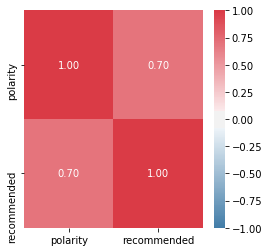

In [24]:
plot_cmap.plot_cmap(matrix_values=corr_values, 
                    figsize_w=4, 
                    figsize_h=4, 
                    filename='../Results/02/Corr.png')

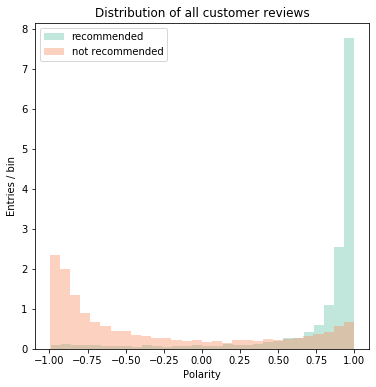

In [25]:
plot_two_hists_comp_sns.plot_two_hists_comp_sns(df_1=df_nlp[df_nlp['recommended']==True],
                                                df_2=df_nlp[df_nlp['recommended']==False],
                                                label_1='recommended',
                                                label_2='not recommended',
                                                feat='polarity',
                                                bins=30,
                                                title='Distribution of all customer reviews',
                                                x_label='Polarity',
                                                y_label='Entries / bin',
                                                filename='../Results/02/HistPolarityByRecommendation.png')

**DISCUSSION**:  
*What could be the limitations of this approach? Would you expect it to perform well on the customer reviews?*

### 3.3 - Preprocess review text

#### 3.3.1 - Import packages

In [26]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nanakin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nanakin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nanakin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### 3.3.2 - Stop words

In [27]:
# Stop words.
# Airlines appearing in the dataset. This is the official name of the airlines. These words should be removed from the review text.
airlines_lower = df_nlp['airline'].str.lower().unique().tolist()
# Words appearing in the official name of the airlines. These words should be removed from the review text.
airlines_identifier = ['airlines',
                       'air lines',
                       'airline',
                       'air line',
                       'airways',
                       'air']
# In addition to the official name of the airlines, customers can use shortened versions of this name.
airlines_informal_lower = []
for airline in airlines_lower:
    found = False
    for airline_identifier in airlines_identifier:
        if found == False:
            if str(' '+airline_identifier) in airline:
                airline_informal = airline.replace(str(' '+airline_identifier),'')
                airlines_informal_lower.append(airline_informal)
                found = True
# Other stop words.
additional_stopwords = ['one','get','also','however','even','make']

In [28]:
print(airlines_lower)

['turkish airlines', 'qatar airways', 'emirates', 'lufthansa', 'klm royal dutch airlines', 'virgin america', 'american airlines', 'delta air lines', 'southwest airlines', 'united airlines', 'jetblue airways', 'aegean airlines', 'aeroflot russian airlines', 'aeromexico', 'air canada', 'air new zealand', 'alitalia', 'airasia', 'asiana airlines', 'avianca', 'austrian airlines', 'british airways', 'brussels airlines', 'china eastern airlines', 'china southern airlines', 'copa airlines', 'ethiopian airlines', 'egyptair', 'finnair', 'iberia', 'ana all nippon airways', 'easyjet', 'korean air', 'latam airlines', 'lot polish airlines', 'qantas airways', 'air france', 'etihad airways', 'pegasus airlines', 'royal jordanian airlines', 'ryanair', 'south african airways', 'saudi arabian airlines', 'tap portugal', 'eurowings', 'eva air', 'royal air maroc', 'singapore airlines', 'sas scandinavian', 'swiss intl air lines', 'thai airways', 'air india', 'air europa', 'air canada rouge', 'airbaltic', 'air

In [29]:
print(airlines_identifier)

['airlines', 'air lines', 'airline', 'air line', 'airways', 'air']


In [30]:
print(airlines_informal_lower)

['turkish', 'qatar', 'klm royal dutch', 'american', 'delta', 'southwest', 'united', 'jetblue', 'aegean', 'aeroflot russian', 'asiana', 'austrian', 'british', 'brussels', 'china eastern', 'china southern', 'copa', 'ethiopian', 'ana all nippon', 'korean', 'latam', 'lot polish', 'qantas', 'etihad', 'pegasus', 'royal jordanian', 'south african', 'saudi arabian', 'eva', 'royal maroc', 'singapore', 'swiss intl', 'thai', 'cathay pacific', 'wizz', 'spirit', 'vueling', 'sunwing', 'bangkok', 'frontier', 'adria', 'alaska', 'thai smile', 'gulf', 'kuwait', 'wow']


In [31]:
nltk_stopwords = stopwords.words('english')
nltk_stopwords_extended = nltk_stopwords + airlines_lower + airlines_identifier + airlines_informal_lower + additional_stopwords
print('Number of stopwords in NLTK: {:d}'.format(len(nltk_stopwords)))
print('Number of stopwords after extension: {:d}'.format(len(nltk_stopwords_extended)))

Number of stopwords in NLTK: 179
Number of stopwords after extension: 318


#### 3.3.3 - Lower/upper case, punctuation, tokenization, stop words, POS tagging and lemmatization

First of all, we convert all characters in the review text to lower case.

After that, we remove the punctuation and tokenize each customer review into a list of individual words. 

As a next step, we need to select only those words in the review text that could be relevant to solve the problem at hand. In particular, all stop words should be filtered out as they do not affect the meaning of the sentence.  
We can download the stopwords from NLTK and specify that we want to use those corresponding to the English language.

We then proceed to POS tagging, which allows to identify the role of each word in the sentence, according to the categories noun, verb, adjective, adverb and others. This is needed for a correct lemmatization of the words in the review text.

The lemmatization consists in bringing the words to their "standard" form, e.g. to convert "wrote" to "write" or "writing" to write.

In [32]:
def get_clean_text(text):
    # Transform the text so that all words are lower case.
    # print(text)
    text = text.lower()
    # Remove stop words corresponding to airlines. This is needed here as airline names can consist of multiple words and will not be removed after splitting by words.
    # print(text)
    for airline_lower in airlines_lower:
        text = text.replace(airline_lower, '')
    # Remove punctuation and tokenize the text into individual words.
    # print(text)
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # Remove words that contain numbers.
    # print(text)
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # Remove stop words.
    # print(text)
    text = [word for word in text if word not in nltk_stopwords_extended]
    # Remove empty tokens.
    # print(text)
    text = [word for word in text if len(word)>0]
    # POS tagging of the text.
    # print(text)
    pos_tags = pos_tag(text)
    # Lemmatize the text.
    # print(text)
    text = [WordNetLemmatizer().lemmatize(i_pos_tag[0], get_wordnet_pos.get_wordnet_pos(i_pos_tag[1])) for i_pos_tag in pos_tags]
    # Remove words with only one letter.
    # print(text)
    text = [word for word in text if len(word)>1]
    # Join the text with space as a word delimiter.
    # print(text)
    text = " ".join(text)
    # Remove non-ASCII characters.
    printable = set(string.printable)
    text = ''.join(filter(lambda x: x in printable, text))
    return text

In [33]:
# Example of POS tagging.
pos_tag(tokenize.word_tokenize('This is a simple test for you.'))

[('This', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('simple', 'JJ'),
 ('test', 'NN'),
 ('for', 'IN'),
 ('you', 'PRP'),
 ('.', '.')]

In [34]:
# Example of lemmatization.
WordNetLemmatizer().lemmatize('written',wordnet.VERB)

'write'

In [35]:
reviews_list[0]

' First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and planes are very good, ground staff and call centre 

In [36]:
get_clean_text(reviews_list[0])

'first time id flown tk find good cabin crew plane food nice great ground ground staff call centre computer system flight lhr delay miss connection istanbul ground staff dont speak english give contradictory instruction could speak little english eventually get flight izmir three hour later wasnt easy process make bad vast distance walk gate cavernous new airport id phone tk call centre base ukraine pay extra way extra leg room seat departure time keep change seat keep change return leg london istanbul give extra leg room seat luckily spare exit row seat cabin crew sort overall think cabin crew plane good ground staff call centre staff need good train need good computer system software work'

In [37]:
df_nlp['review_text_clean'] = df_nlp['review_text'].apply(lambda x: get_clean_text(x))

In [38]:
df_nlp['review_text_clean'][0]

'first time id flown tk find good cabin crew plane food nice great ground ground staff call centre computer system flight lhr delay miss connection istanbul ground staff dont speak english give contradictory instruction could speak little english eventually get flight izmir three hour later wasnt easy process make bad vast distance walk gate cavernous new airport id phone tk call centre base ukraine pay extra way extra leg room seat departure time keep change seat keep change return leg london istanbul give extra leg room seat luckily spare exit row seat cabin crew sort overall think cabin crew plane good ground staff call centre staff need good train need good computer system software work'

#### 3.3.4 - Vectorization

We convert the text of each customer review from a textual representation to a numerical representation. The vectors of the numerical representation correspond to the words that appear in the preprocessed text of the customer reviews. The values in the numerical representation correspond to the occurrences of the specified word in the customer review. To avoid to end up with too many features in the numerical representation, we limit the dictionary to the words that appear at least a minimum number of times in the customer reviews. This threshold is specified through the parameter `min_df` of `CountVectorizer`.  

For example, if we want to use a 3D numerical representation, we might have features corresponding to the words `flight`, `service`, `food`. For a certain customer review, the value of the feature `flight` will correspond to how many times `flight` is mentioned in the text, and similar for the other two features `service` and `food`.

It should be noted that, up to this point, there is no "meaning" associated to the words in the dictionary. The numerical representation does not take the similarity between two words into account. Embeddings are a way to map words to meanings and are an interesting option, but for the sake of simplicity they are not implemented in this exercise.

In [39]:
# List of reviews.
corpus = df_nlp['review_text_clean'].values

In [40]:
corpus[0]

'first time id flown tk find good cabin crew plane food nice great ground ground staff call centre computer system flight lhr delay miss connection istanbul ground staff dont speak english give contradictory instruction could speak little english eventually get flight izmir three hour later wasnt easy process make bad vast distance walk gate cavernous new airport id phone tk call centre base ukraine pay extra way extra leg room seat departure time keep change seat keep change return leg london istanbul give extra leg room seat luckily spare exit row seat cabin crew sort overall think cabin crew plane good ground staff call centre staff need good train need good computer system software work'

In [41]:
len(corpus)

22822

In [42]:
vectorizer_ngrams = CountVectorizer(binary=False, ngram_range=(1, 1), analyzer='word', min_df=50)

In [43]:
vectorizer_ngrams.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=50,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [44]:
vec_review_text_clean_feats = vectorizer_ngrams.get_feature_names()

In [45]:
vec_review_text_clean_feats[:10]

['aa',
 'ababa',
 'ability',
 'able',
 'aboard',
 'abrupt',
 'absolute',
 'absolutely',
 'abu',
 'abysmal']

In [46]:
len(vec_review_text_clean_feats)

2442

In [47]:
vec_review_text_clean = vectorizer_ngrams.transform(df_nlp['review_text_clean'])

In [48]:
vec_review_text_clean.shape

(22822, 2442)

In [49]:
vec_review_text_clean.dtype

dtype('int64')

In [50]:
vec_review_text_clean

<22822x2442 sparse matrix of type '<class 'numpy.int64'>'
	with 1108120 stored elements in Compressed Sparse Row format>

In [51]:
vec_review_text_clean_feats_new = ['count_'+feat for feat in vec_review_text_clean_feats]

In [52]:
# Add features to the dataset.
df_vec_review_text_clean = pd.DataFrame(vec_review_text_clean.toarray(),columns=vec_review_text_clean_feats_new)

In [53]:
df_vec_review_text_clean.head()

,count_aa,count_ababa,count_ability,count_able,count_aboard,count_abrupt,count_absolute,count_absolutely,count_abu,count_abysmal,...,count_yet,count_yoghurt,count_york,count_young,count_youre,count_yvr,count_yyz,count_zero,count_zone,count_zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
df_nlp['review_text_clean'][0]

'first time id flown tk find good cabin crew plane food nice great ground ground staff call centre computer system flight lhr delay miss connection istanbul ground staff dont speak english give contradictory instruction could speak little english eventually get flight izmir three hour later wasnt easy process make bad vast distance walk gate cavernous new airport id phone tk call centre base ukraine pay extra way extra leg room seat departure time keep change seat keep change return leg london istanbul give extra leg room seat luckily spare exit row seat cabin crew sort overall think cabin crew plane good ground staff call centre staff need good train need good computer system software work'

In [55]:
df_vec_review_text_clean.iloc[0]['count_lose']

0

In [56]:
df_nlp_final = pd.concat([df_nlp,df_vec_review_text_clean], axis=1)

In [57]:
df_nlp_final.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,count_yet,count_yoghurt,count_york,count_young,count_youre,count_yvr,count_yyz,count_zero,count_zone,count_zurich
0,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,0,0,0,0,0,0,0,0,0,0
1,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,0,0,0,0,0,0,0,0,0,0
3,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,0,0,0,0,0,0,0,0,0,0
4,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [58]:
df_nlp_final['cabin'].head()

0    Economy Class
1    Economy Class
2    Economy Class
3    Economy Class
4    Economy Class
Name: cabin, dtype: object

## 4 - Save the dataset

In [59]:
df_nlp_final_types = df_nlp_final.dtypes.to_frame('dtypes').reset_index()

df_nlp_types = df_nlp.dtypes.to_frame('dtypes').reset_index()

In [60]:
df_nlp_final.to_csv('../Results/NLPFinalDataLight.csv')
df_nlp_final_types.to_csv('../Results/NLPFinalDataLightTypes.csv')

df_nlp.to_csv('../Results/NLPDataLight.csv')
df_nlp_types.to_csv('../Results/NLPDataLightTypes.csv')

In [61]:
with open('../Results/VecReviewTextCleanFeats.csv', 'w') as f:
    f.write(', '.join(vec_review_text_clean_feats_new))

In [62]:
with open('../Results/NLTKStopWordsExtended.csv', 'w') as f:
    f.write(', '.join(nltk_stopwords_extended))